In [1]:
library(dplyr)
library(readr)
install.packages("caret")
library(caret)
install.packages("ggplot2")
library(ggplot2)
install.packages("randomForest")
library(randomForest)
library(lubridate)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Loading required package: ggplot2

Loading required package: lattice

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggpl

In [2]:
# Instalar y cargar las bibliotecas necesarias
install.packages("googledrive")
library(googledrive)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [81]:
# Autenticarse con Google Drive
drive_auth()

The googledrive package is requesting access to your Google account.
Enter '1' to start a new auth process or select a pre-authorized account.
1: Send me to the browser for a new auth process.
2: cesar.garcia@catolica.edu.sv


Selection: 1


Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=76773421f036f2ed3b644223151f6a26&access_type=offline&prompt=consent



Enter authorization code: eyJjb2RlIjoiNC8wQVFsRWQ4d2VfOS16Q0k4aW1Qbnh0THpYRy14bl92NlBrYkVXSlEzNE1KNXU3VFRuT2MyWmxTLXlDVzAwOUZJR3pGenJRUSIsInN0YXRlIjoiNzY3NzM0MjFmMDM2ZjJlZDNiNjQ0MjIzMTUxZjZhMjYifQ==


In [82]:
# Especificar el ID del archivo y la ruta de destino
file_id <- "https://drive.google.com/file/d/1c8ATZ5VxKEo1hCmjyALNGkxGY_KmI-xx/view?usp=drivesdk"  # Reemplaza este ID con el ID de tu archivo
drive_download(as_id(file_id), path = "archivo.csv", overwrite = TRUE)

File downloaded:

• Documento de César García <id: 1c8ATZ5VxKEo1hCmjyALNGkxGY_KmI-xx>

Saved locally as:

• archivo.csv



In [83]:
# Leer el archivo CSV desde la URL
urlAge <- "https://raw.githubusercontent.com/cesargar1507/DatasetsUB/main/machine_age.csv"
urlMechanic <- "https://raw.githubusercontent.com/cesargar1507/DatasetsUB/main/mechanic_antiquity.csv"
df <- read_csv("archivo.csv", show_col_types = FALSE)
df_age <- read_csv(urlAge, show_col_types = FALSE)
df_mechanic <- read_csv(urlMechanic, show_col_types = FALSE)

In [84]:
summary(df)

   equipment        operation           wo_type           base_model       
 Min.   : 100268   Length:135860      Length:135860      Length:135860     
 1st Qu.:1024525   Class :character   Class :character   Class :character  
 Median :1078769   Mode  :character   Mode  :character   Mode  :character  
 Mean   :1020927                                                           
 3rd Qu.:1149222                                                           
 Max.   :1169630                                                           
 problem_code       problem_desc       failure_code       failure_desc      
 Length:135860      Length:135860      Length:135860      Length:135860     
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
      

In [85]:
head(df,5)

equipment,operation,wo_type,base_model,problem_code,problem_desc,failure_code,failure_desc,cause_code,cause_desc,⋯,action_desc,mechanic,date,downtime_gross,pit_coverage,real_downtime,parts_cost,repair_hours,waiting_hours,changed_pcs
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
100268,BIND LEG,Corrective Maintenance,VC1700,SEWP002,It sews with defect / Cose con defecto,SEWF001,Machine head failure stopping sewing / Falla cabezal dejando de coser,SEWC017,Misadjusted machine head teeth / Dientes de cabezal desajustados,⋯,Adjust machine head teeth / Ajustar dientes de cabezal,Jaime Rivera,10/3/2023,1.25,0,1.25,$16.81,1.25,0,1
100268,BIND LEG,Corrective Maintenance,VC1700,SEWP002,It sews with defect / Cose con defecto,SEWF001,Machine head failure stopping sewing / Falla cabezal dejando de coser,SEWC017,Misadjusted machine head teeth / Dientes de cabezal desajustados,⋯,Adjust machine head teeth / Ajustar dientes de cabezal,Jaime Rivera,10/3/2023,1.25,0,1.25,$16.81,1.25,0,1
100268,BIND LEG,Corrective Maintenance,VC1700,SEWP002,It sews with defect / Cose con defecto,SEWF001,Machine head failure stopping sewing / Falla cabezal dejando de coser,SEWC012,Misadjusted machine head needle bar / Barra de aguja de cabezal desajustada,⋯,Adjust machine head teeth / Ajustar dientes de cabezal,Jaime Rivera,1/17/2024,3.00,3,0.00,$12.50,2.00,1,2
100312,BARTACK,Corrective Maintenance,VC1700,SEWP001,It does not sew / No cose,SEWF001,Machine head failure stopping sewing / Falla cabezal dejando de coser,SEWC005,Broken machine head ball joint / Rotura de biela de cabezal,⋯,Replace machine head ball joint / Reemplazar biela de cabezal,JERONIMO FUNEZ,3/18/2023,0.25,0,0.25,$2.67,0.25,0,0
100312,BARTACK,Corrective Maintenance,VC1700,SEWP001,It does not sew / No cose,SEWF001,Machine head failure stopping sewing / Falla cabezal dejando de coser,SEWC005,Broken machine head ball joint / Rotura de biela de cabezal,⋯,Replace machine head ball joint / Reemplazar biela de cabezal,JERONIMO FUNEZ,3/18/2023,0.25,0,0.25,$2.67,0.25,0,0


# **LIMPIEZA DE DATOS**

In [86]:
sapply(df, function(x) sum(is.na(x)))
#Fiabilidad suficiente para continuar con el trabajo

equipment      operation        wo_type     base_model   problem_code 
             0              0              0              0              0 
  problem_desc   failure_code   failure_desc     cause_code     cause_desc 
             0              0              0              0              0 
   action_code    action_desc       mechanic           date downtime_gross 
             0              0              0              0              0 
  pit_coverage  real_downtime     parts_cost   repair_hours  waiting_hours 
             0              0              0              0              0 
   changed_pcs 
             0

In [87]:
# Remover el símbolo de dólar y las comas, y convertir a float
df$parts_cost <- as.numeric(gsub("[\\$,()]", "", df$parts_cost))

In [88]:
# Convertir la columna 'Date' al formato adecuado
df$date <- as.Date(df$date, format="%m/%d/%Y")  # Ajusta el formato según tus datos
# Ordenar el DataFrame por fecha
df <- df %>%
  arrange(date)

In [89]:
mean(df$downtime_gross < 0)

[1] 1.472104e-05

In [90]:
# Filtrar registros donde downtimeGross no sea negativo
df <- df %>%
  filter(downtime_gross >= 0)

In [91]:
mean(df$repair_hours < 0)

[1] 0

In [92]:
#Eliminar columnas que no seran utilizadas
df <- select(df, -problem_code, -failure_code, -cause_code, -action_code, -pit_coverage, -real_downtime, -repair_hours)
#Se han eliminado codigos y variables calculadas

In [93]:
# Calcular la diferencia en días entre fechas consecutivas
df <- df %>%
  group_by(equipment) %>%
  mutate(Days_Between_Failures = difftime(date, lag(date), units = "days"))

# Reemplazar los valores NA en Days_Between_Failures
df$Days_Between_Failures[is.na(df$Days_Between_Failures)] <- as.numeric(difftime(df$date[is.na(df$Days_Between_Failures)], as.Date("2023-01-01"), units = "days"))

In [94]:
# Convertir 'Days_Between_Failures' a numeric
df$Days_Between_Failures <- as.numeric(df$Days_Between_Failures, units = "days")

In [95]:
#Cambio de nombre de mecánico cuyo nombre está escrito de dos formas
df <- df %>%
  mutate(mechanic = ifelse(mechanic == "GALEAS PEREZ EDWIN ROGELIO", "Edwin Rogelio Galeas Perez", mechanic))

In [96]:
# Calcular la tabla de frecuencias de mechanic
freq_mechanic <- table(df$mechanic)

# Ordenar las frecuencias de menor a mayor
freq_sorted_mechanic <- sort(freq_mechanic)

# Calcular la frecuencia relativa acumulada
freq_relative_mechanic <- cumsum(freq_sorted_mechanic) / sum(freq_sorted_mechanic)

# Definir umbral de frecuencia acumulada
umbral <- 0.2

# Identificar categorías con frecuencia relativa acumulada menor que el umbral
categorias_baja_frecuencia_mechanic <- names(freq_sorted_mechanic[freq_relative_mechanic < umbral])

# Reemplazar categorías con baja frecuencia por "Otros"
df$mechanic[df$mechanic %in% categorias_baja_frecuencia_mechanic] <- "Otros"

In [97]:
# Calcular la tabla de frecuencias de problem_desc
freq_problem <- table(df$problem_desc)

# Ordenar las frecuencias de menor a mayor
freq_sorted_problem <- sort(freq_problem)

# Calcular la frecuencia relativa acumulada
freq_relative_problem <- cumsum(freq_sorted_problem) / sum(freq_sorted_problem)

# Definir umbral de frecuencia acumulada
umbral <- 0.2

# Identificar categorías con frecuencia relativa acumulada menor que el umbral
categorias_baja_frecuencia_problem <- names(freq_sorted_problem[freq_relative_problem < umbral])

# Reemplazar categorías con baja frecuencia por "Otros"
df$problem_desc[df$problem_desc %in% categorias_baja_frecuencia_problem] <- "Otros"

In [98]:
# Calcular la tabla de frecuencias de failure_desc
freq_failure <- table(df$failure_desc)

# Ordenar las frecuencias de menor a mayor
freq_sorted_failure <- sort(freq_failure)

# Calcular la frecuencia relativa acumulada
freq_relative_failure <- cumsum(freq_sorted_failure) / sum(freq_sorted_failure)

# Definir umbral de frecuencia acumulada
umbral <- 0.2

# Identificar categorías con frecuencia relativa acumulada menor que el umbral
categorias_baja_frecuencia_failure <- names(freq_sorted_failure[freq_relative_failure < umbral])

# Reemplazar categorías con baja frecuencia por "Otros"
df$failure_desc[df$failure_desc %in% categorias_baja_frecuencia_failure] <- "Otros"

In [99]:
#Convertir horas a minutos
df$downtime_gross <-df$downtime_gross*60

In [100]:
write.csv(df,"arhivo2.csv")

# **ANALISIS DE VARIABLES**

In [101]:
dim(df)

[1] 135858     15

**Variable "Operación"**

In [102]:
# Calcular la frecuencia de cada operación
operation_freq <- df %>%
  group_by(operation) %>%
  summarise(count = n()) %>%
  arrange(desc(count))

# Calcular la frecuencia relativa
operation_freq <- operation_freq %>%
  mutate(relative_freq = count / sum(count))

operation_freq

operation,count,relative_freq
<chr>,<int>,<dbl>
HEM SLEEVE,38311,0.281992963
HEM BOTTOM,15840,0.116592324
JOIN PANEL,7799,0.057405526
SET SLEEVE,7743,0.056993331
TAPE SHOULDER,7556,0.055616894
HEM AROUND,5256,0.038687453
FLAT SEAM,4987,0.036707445
JOIN SHOULDER,4857,0.035750563
ATTACH ELASTIC,4704,0.034624387


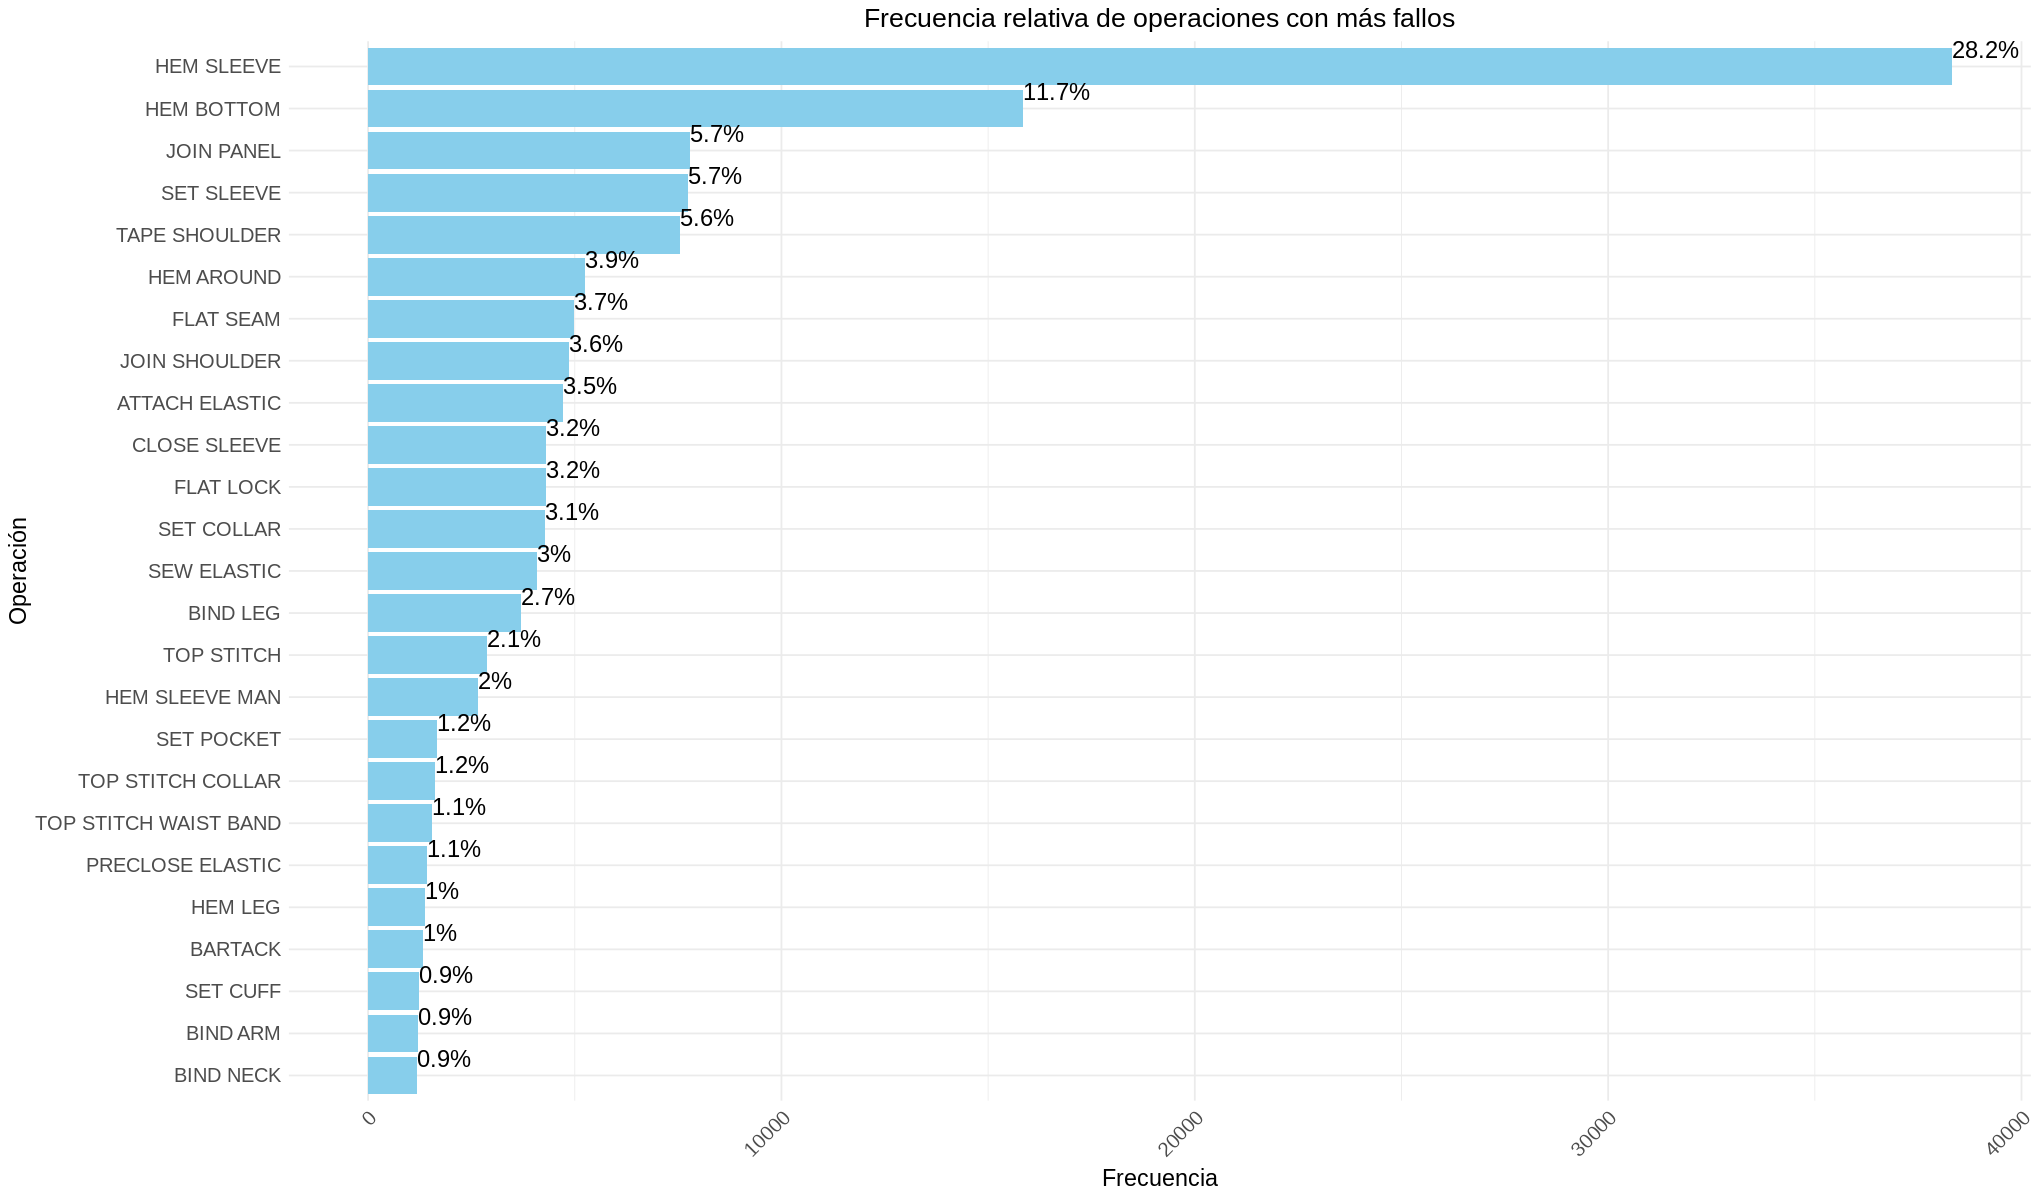

In [103]:
# Ordenar los datos por frecuencia descendente
operation_freq <- operation_freq %>%
  arrange(desc(count))

options(repr.plot.width=17, repr.plot.height=10)

ggplot(operation_freq, aes(y = reorder(operation, count), x = count)) +
  geom_bar(stat = "identity", fill = 'skyblue') +
  geom_text(aes(label = paste0(round(relative_freq * 100, 1), "%")), vjust = -0.5, hjust = 0, size = 5) +
  labs(title = "Frecuencia relativa de operaciones con más fallos",
       y = "Operación",
       x = "Frecuencia") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 12), # Cambia el tamaño del texto del eje x
    axis.text.y = element_text(size = 12),                         # Cambia el tamaño del texto del eje y
    axis.title.x = element_text(size = 14),                        # Cambia el tamaño del título del eje x
    axis.title.y = element_text(size = 14),                        # Cambia el tamaño del título del eje y
    plot.title = element_text(size = 16, hjust = 0.5)              # Cambia el tamaño del título del gráfico y lo centra
  )

**Variable "problem_desc"**

In [104]:
# Calcular la frecuencia de problemas de maquinaria
problem_freq <- df %>%
  group_by(problem_desc) %>%
  summarise(count = n()) %>%
  arrange(desc(count))

# Calcular la frecuencia relativa
problem_freq <- problem_freq %>%
  mutate(relative_freq = count / sum(count))

problem_freq

problem_desc,count,relative_freq
<chr>,<int>,<dbl>
It sews with defect / Cose con defecto,95025,0.69944354
It does not sew / No cose,31928,0.23501008
Otros,8905,0.06554638


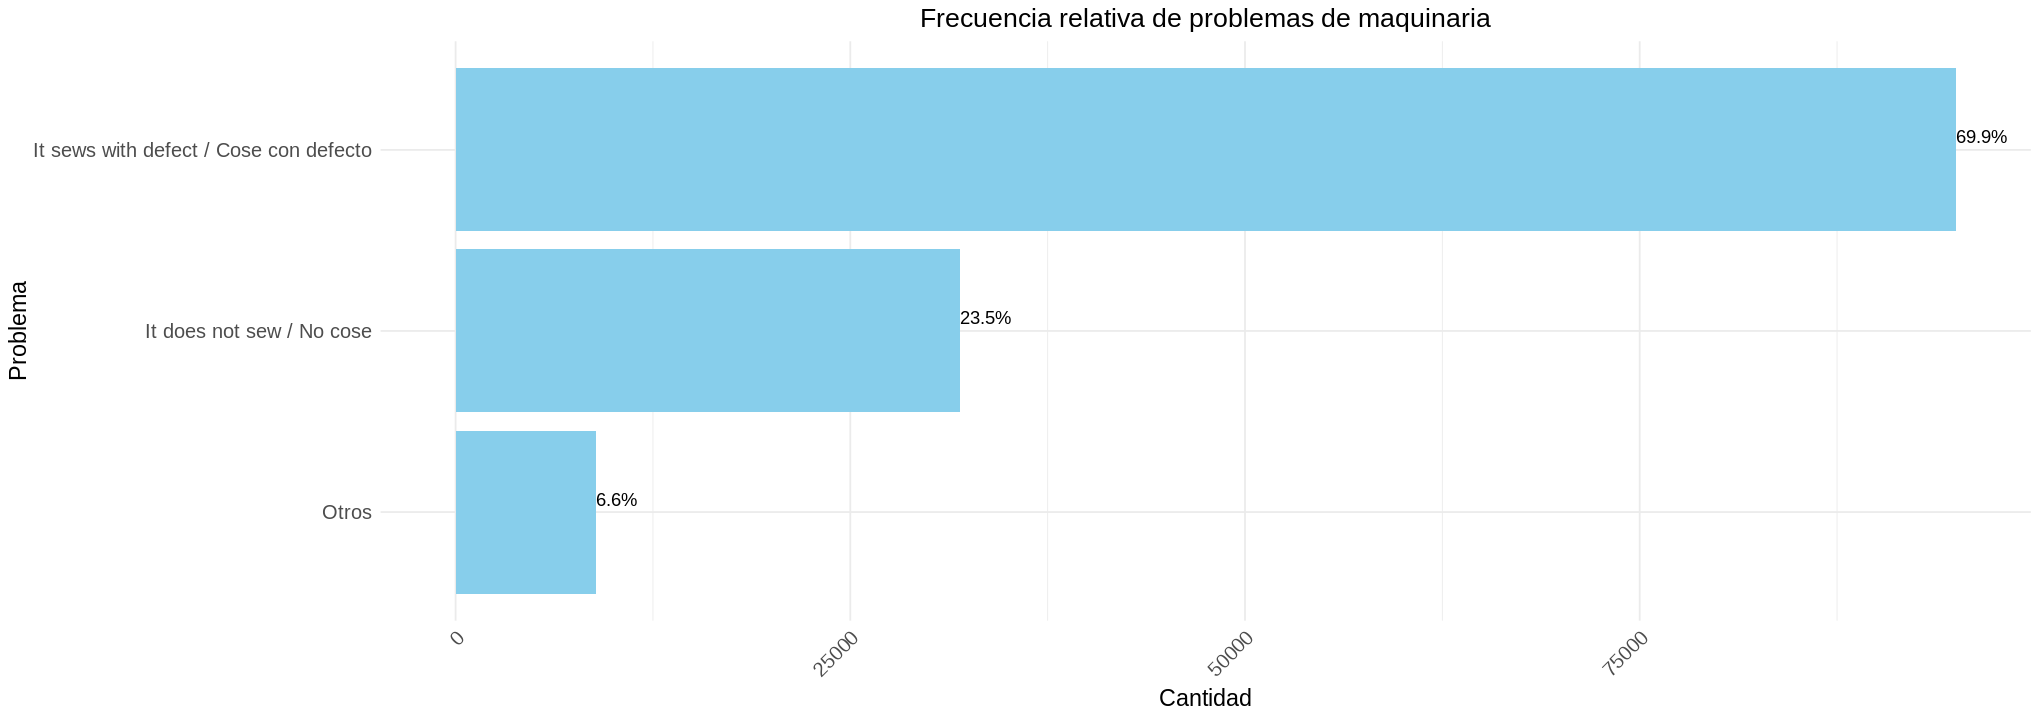

In [105]:
# Ordenar los datos por frecuencia descendente
problem_freq <- problem_freq %>%
  arrange(desc(count))

options(repr.plot.width=17, repr.plot.height=6)

ggplot(problem_freq, aes(y = reorder(problem_desc, count), x = count)) +
  geom_bar(stat = "identity", fill = 'skyblue') +
  geom_text(aes(label = paste0(round(relative_freq * 100, 1), "%")), vjust = -0.5, hjust = 0) +
  labs(title = "Frecuencia relativa de problemas de maquinaria",
       y = "Problema",
       x = "Cantidad") +
  theme_minimal() +
   theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 12), # Cambia el tamaño del texto del eje x
    axis.text.y = element_text(size = 12),                         # Cambia el tamaño del texto del eje y
    axis.title.x = element_text(size = 14),                        # Cambia el tamaño del título del eje x
    axis.title.y = element_text(size = 14),                        # Cambia el tamaño del título del eje y
    plot.title = element_text(size = 16, hjust = 0.5)              # Cambia el tamaño del título del gráfico y lo centra
  )

**Variable "failure_desc"**

In [106]:
# Calcular la frecuencia de fallos de maquinaria
failure_freq <- df %>%
  group_by(failure_desc) %>%
  summarise(count = n()) %>%
  arrange(desc(count))

# Calcular la frecuencia relativa
failure_freq <- failure_freq %>%
  mutate(relative_freq = count / sum(count))

failure_freq

failure_desc,count,relative_freq
<chr>,<int>,<dbl>
Machine head failure stopping sewing / Falla cabezal dejando de coser,64019,0.4712200
Machine head failure sewing with defect / Falla cabezal cosiendo con defecto,36833,0.2711140
Otros,21302,0.1567961
Trim off device failure / Falla dispositivo corta desperdicio,13704,0.1008700


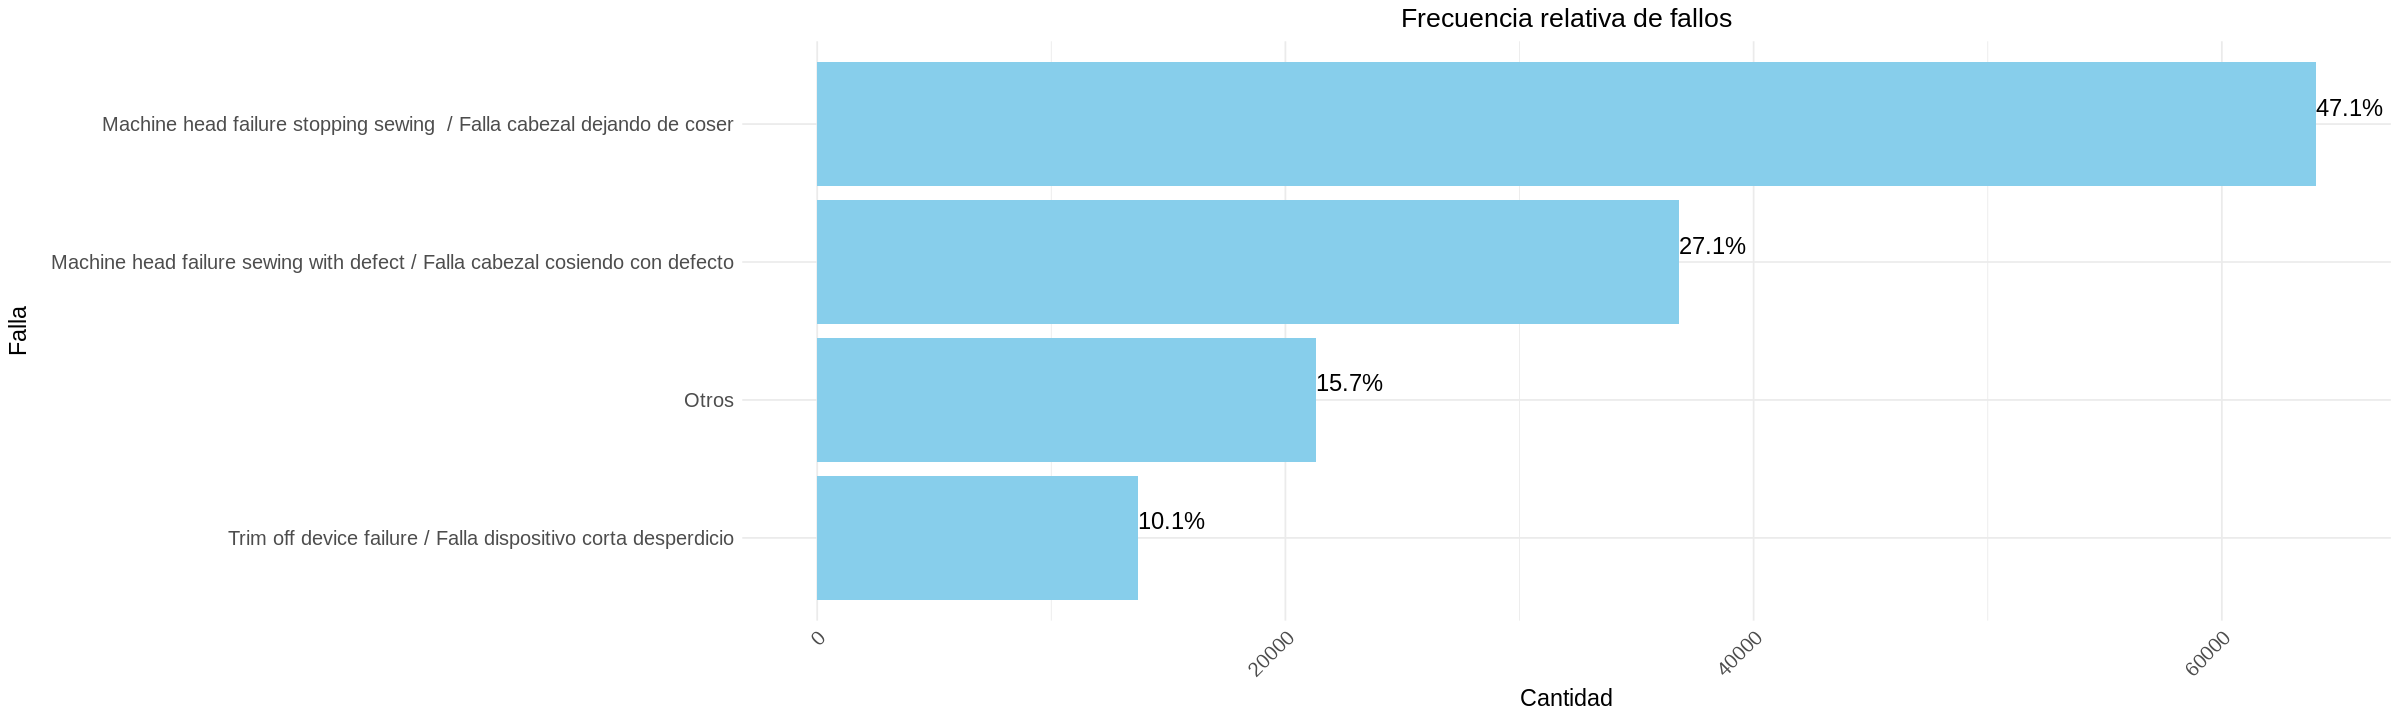

In [107]:
# Ordenar los datos por frecuencia descendente
failure_freq <- failure_freq %>%
  arrange(desc(count))

options(repr.plot.width=20, repr.plot.height=6)

ggplot(failure_freq, aes(y = reorder(failure_desc, count), x = count)) +
  geom_bar(stat = "identity", fill = 'skyblue') +
  geom_text(aes(label = paste0(round(relative_freq * 100, 1), "%")), vjust = -0.5, hjust = 0, size = 5) +  # Etiquetas de porcentaje acumulado
  labs(title = "Frecuencia relativa de fallos",
       y = "Falla",
       x = "Cantidad") +
  theme_minimal() +
   theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 12), # Cambia el tamaño del texto del eje x
    axis.text.y = element_text(size = 12),                         # Cambia el tamaño del texto del eje y
    axis.title.x = element_text(size = 14),                        # Cambia el tamaño del título del eje x
    axis.title.y = element_text(size = 14),                        # Cambia el tamaño del título del eje y
    plot.title = element_text(size = 16, hjust = 0.5)              # Cambia el tamaño del título del gráfico y lo centra
  )

**Variable "cause_desc"**

In [108]:
# Calcular la frecuencia de causas de fallo
cause_freq <- df %>%
  group_by(cause_desc) %>%
  summarise(count = n()) %>%
  arrange(desc(count))

# Calcular la frecuencia relativa
cause_freq <- cause_freq %>%
  mutate(relative_freq = count / sum(count))

cause_freq

cause_desc,count,relative_freq
<chr>,<int>,<dbl>
Misadjusted machine head looper / Enlazador de cabezal desajustado,51007,0.375443478
Damaged trim off system knife / Cuchilla de corta desperdicio en mal estado,12994,0.095643981
Misadjusted machine head needle guard / Guarda aguja de cabezal desajustada,11344,0.083498947
Broken machine head ball joint / Rotura de biela de cabezal,8785,0.064663104
Misadjusted machine head presser foot / Prensatela de cabezal desajustado,6193,0.045584360
Misadjusted machine head teeth / Dientes de cabezal desajustados,5733,0.042198472
Misadjusted machine head chopper / Cuchilla de cabezal desajustada,5387,0.039651695
Misadjusted machine head needle bar / Barra de aguja de cabezal desajustada,4551,0.033498211
Oil leak in machine head / Fuga de aceite lubricante en cabezal,3194,0.023509841


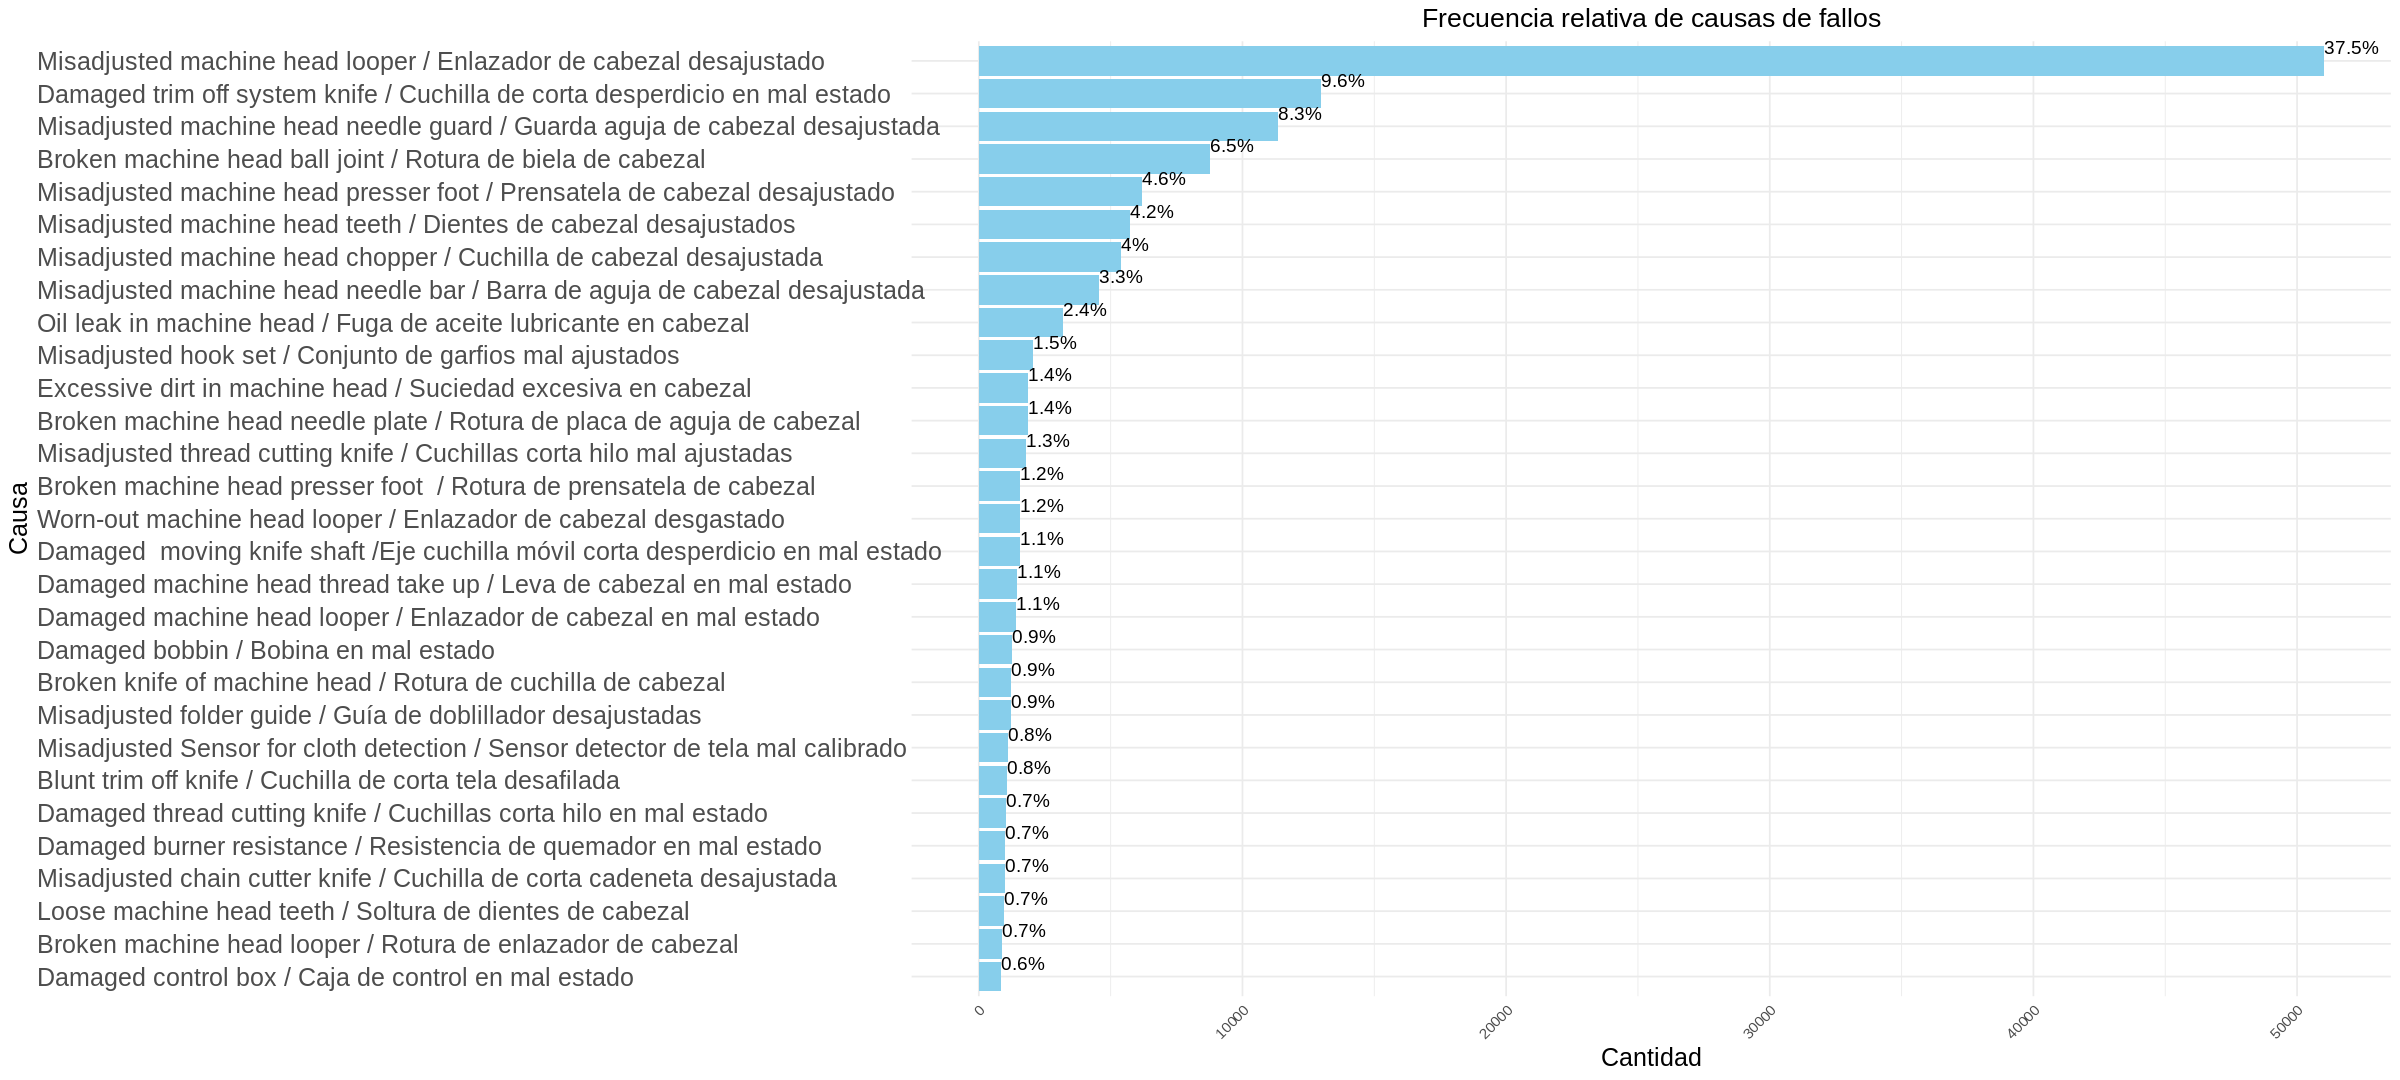

In [109]:
# Ordenar los datos por frecuencia descendente
cause_freq <- cause_freq %>%
  arrange(desc(count))

options(repr.plot.width=20, repr.plot.height=9)

ggplot(cause_freq, aes(y = reorder(cause_desc, count), x = count)) +
  geom_bar(stat = "identity", fill = 'skyblue') +
  geom_text(aes(label = paste0(round(relative_freq * 100, 1), "%")), vjust = -0.5, hjust = 0,  size = 4) +  # Etiquetas de porcentaje acumulado
  labs(title = "Frecuencia relativa de causas de fallos",
       y = "Causa",
       x = "Cantidad") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    axis.text.y = element_text(size = 15, hjust = 0),
    axis.title.x = element_text(size = 15),
    axis.title.y = element_text(size = 15),
    plot.title = element_text(size = 16, hjust = 0.5)
  )

**Variable "action_desc"**

In [110]:
# Calcular la frecuencia de acciones correctivas
action_freq <- df %>%
  group_by(action_desc) %>%
  summarise(count = n()) %>%
  arrange(desc(count))

# Calcular la frecuencia relativa
action_freq <- action_freq %>%
  mutate(relative_freq = count / sum(count))

action_freq

action_desc,count,relative_freq
<chr>,<int>,<dbl>
Adjust machine head looper / Ajustar enlazador de cabezal,44919,0.330631983
Adjust machine head needle guard / Ajustar guarda aguja de cabezal,11409,0.083977388
Adjust machine head teeth / Ajustar dientes de cabezal,9699,0.071390717
Sharpen knife / Afilar cuchillas,9087,0.066886013
Replace machine head ball joint / Reemplazar biela de cabezal,8825,0.064957529
Replace machine head looper / Reemplazar enlazador de cabezal,7719,0.056816676
Adjusted machine head presser foot / Ajustar prensatela de cabezal,6842,0.050361407
Replace trim off knife / Reemplazar cuchilla de corta desperdicio,6205,0.045672688
Adjust machine head knife / Ajustar cuchilla de cabezal,4188,0.030826304


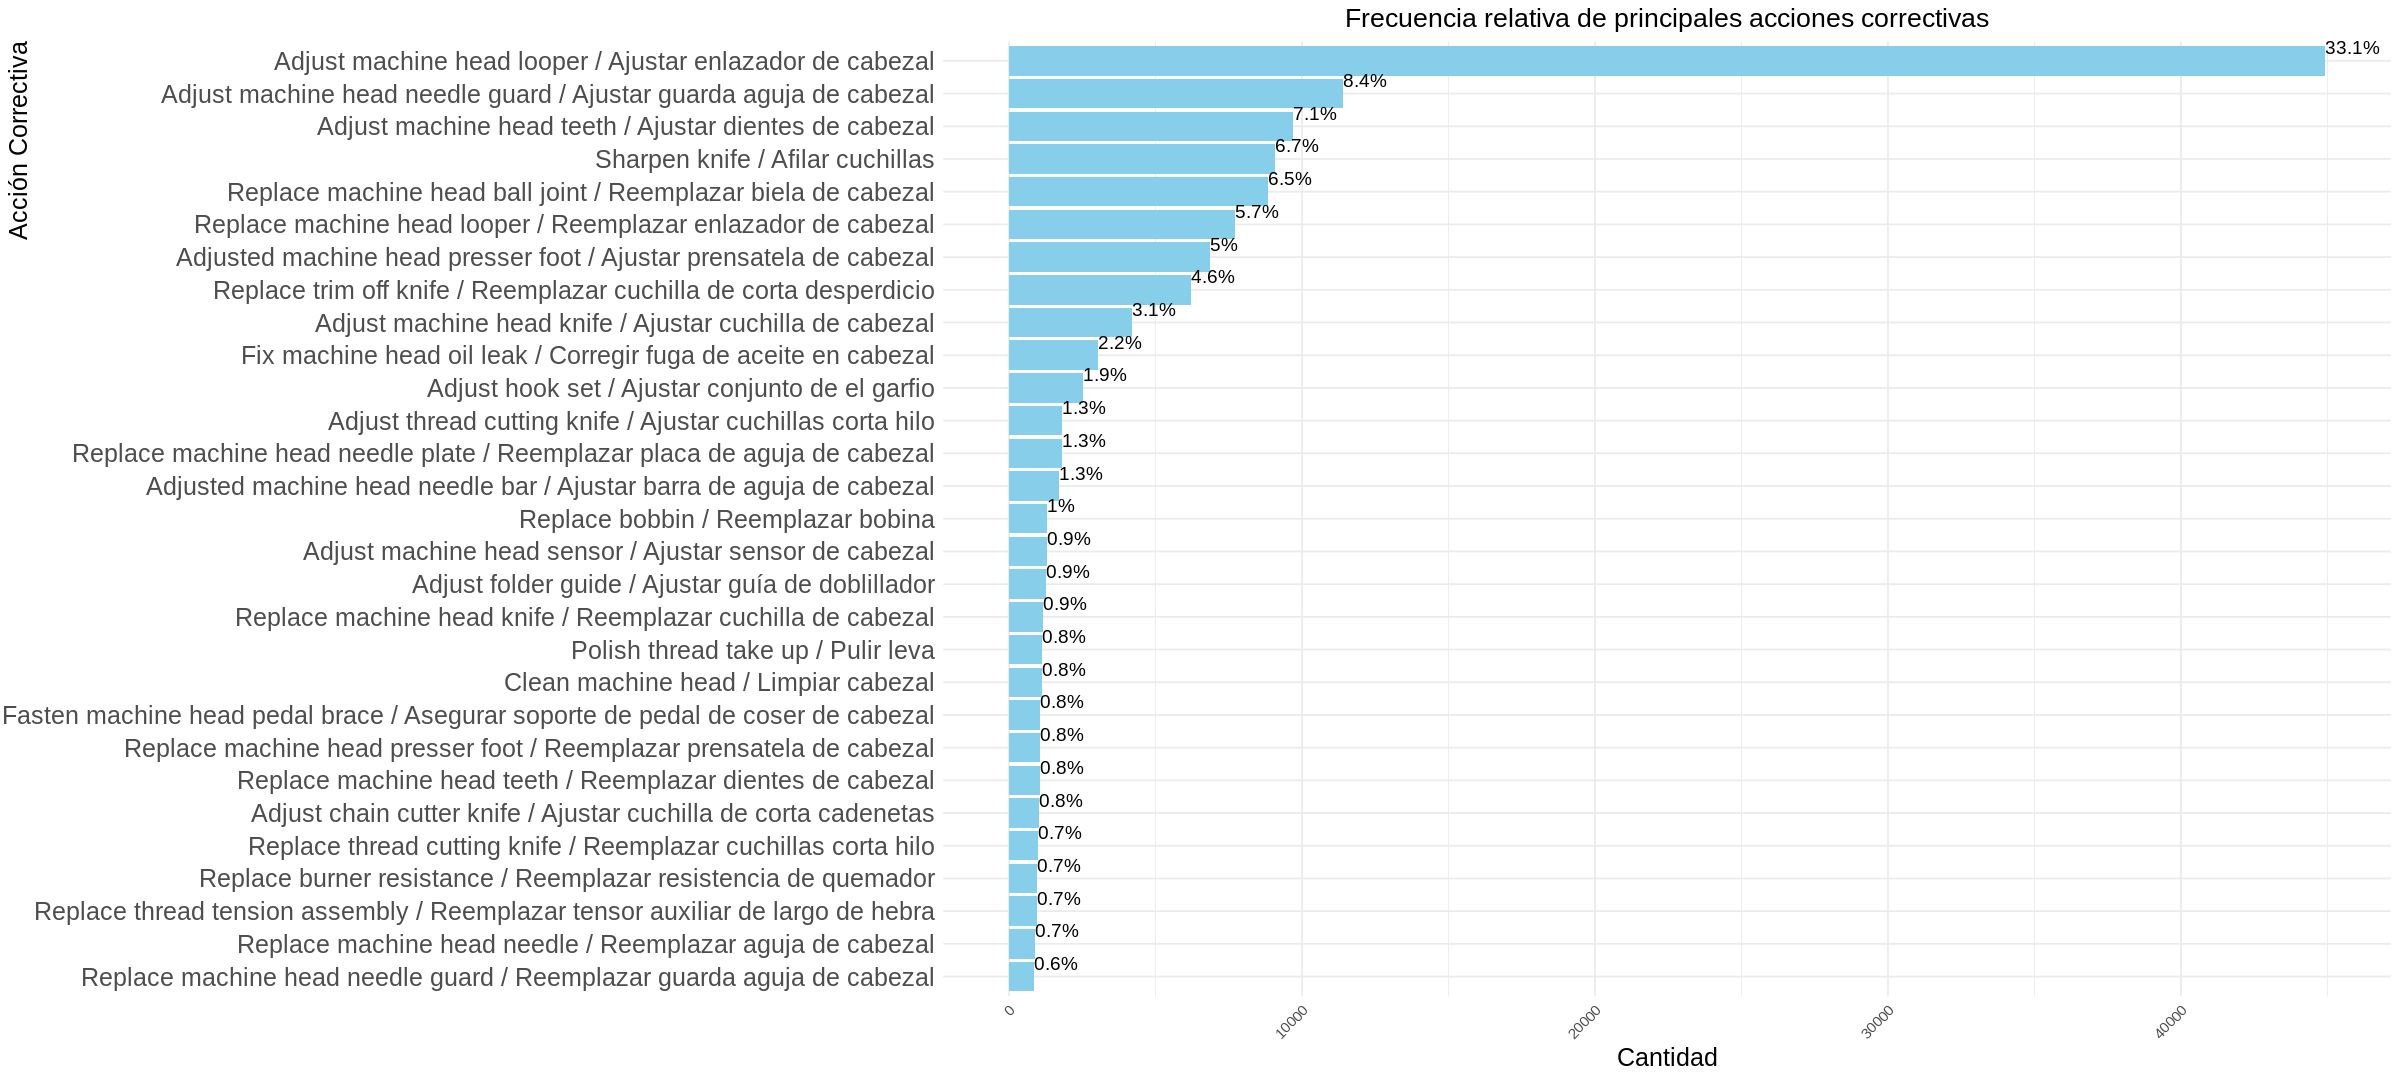

In [111]:
# Ordenar los datos por frecuencia descendente
action_freq <- action_freq %>%
  arrange(desc(count))

options(repr.plot.width=20, repr.plot.height=9)

ggplot(action_freq, aes(y = reorder(action_desc, count), x = count)) +
  geom_bar(stat = "identity", fill = 'skyblue') +
  geom_text(aes(label = paste0(round(relative_freq * 100, 1), "%")),
            vjust = -0.5, hjust = 0, size = 4) +  # Ajuste del tamaño del texto
  labs(title = "Frecuencia relativa de principales acciones correctivas",
       y = "Acción Correctiva",
       x = "Cantidad") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    axis.text.y = element_text(size = 15),
    axis.title.x = element_text(size = 15),
    axis.title.y = element_text(size = 15, hjust = 1),
    plot.title = element_text(size = 16, hjust = 0.5)
  )

**Variable "parts cost"**

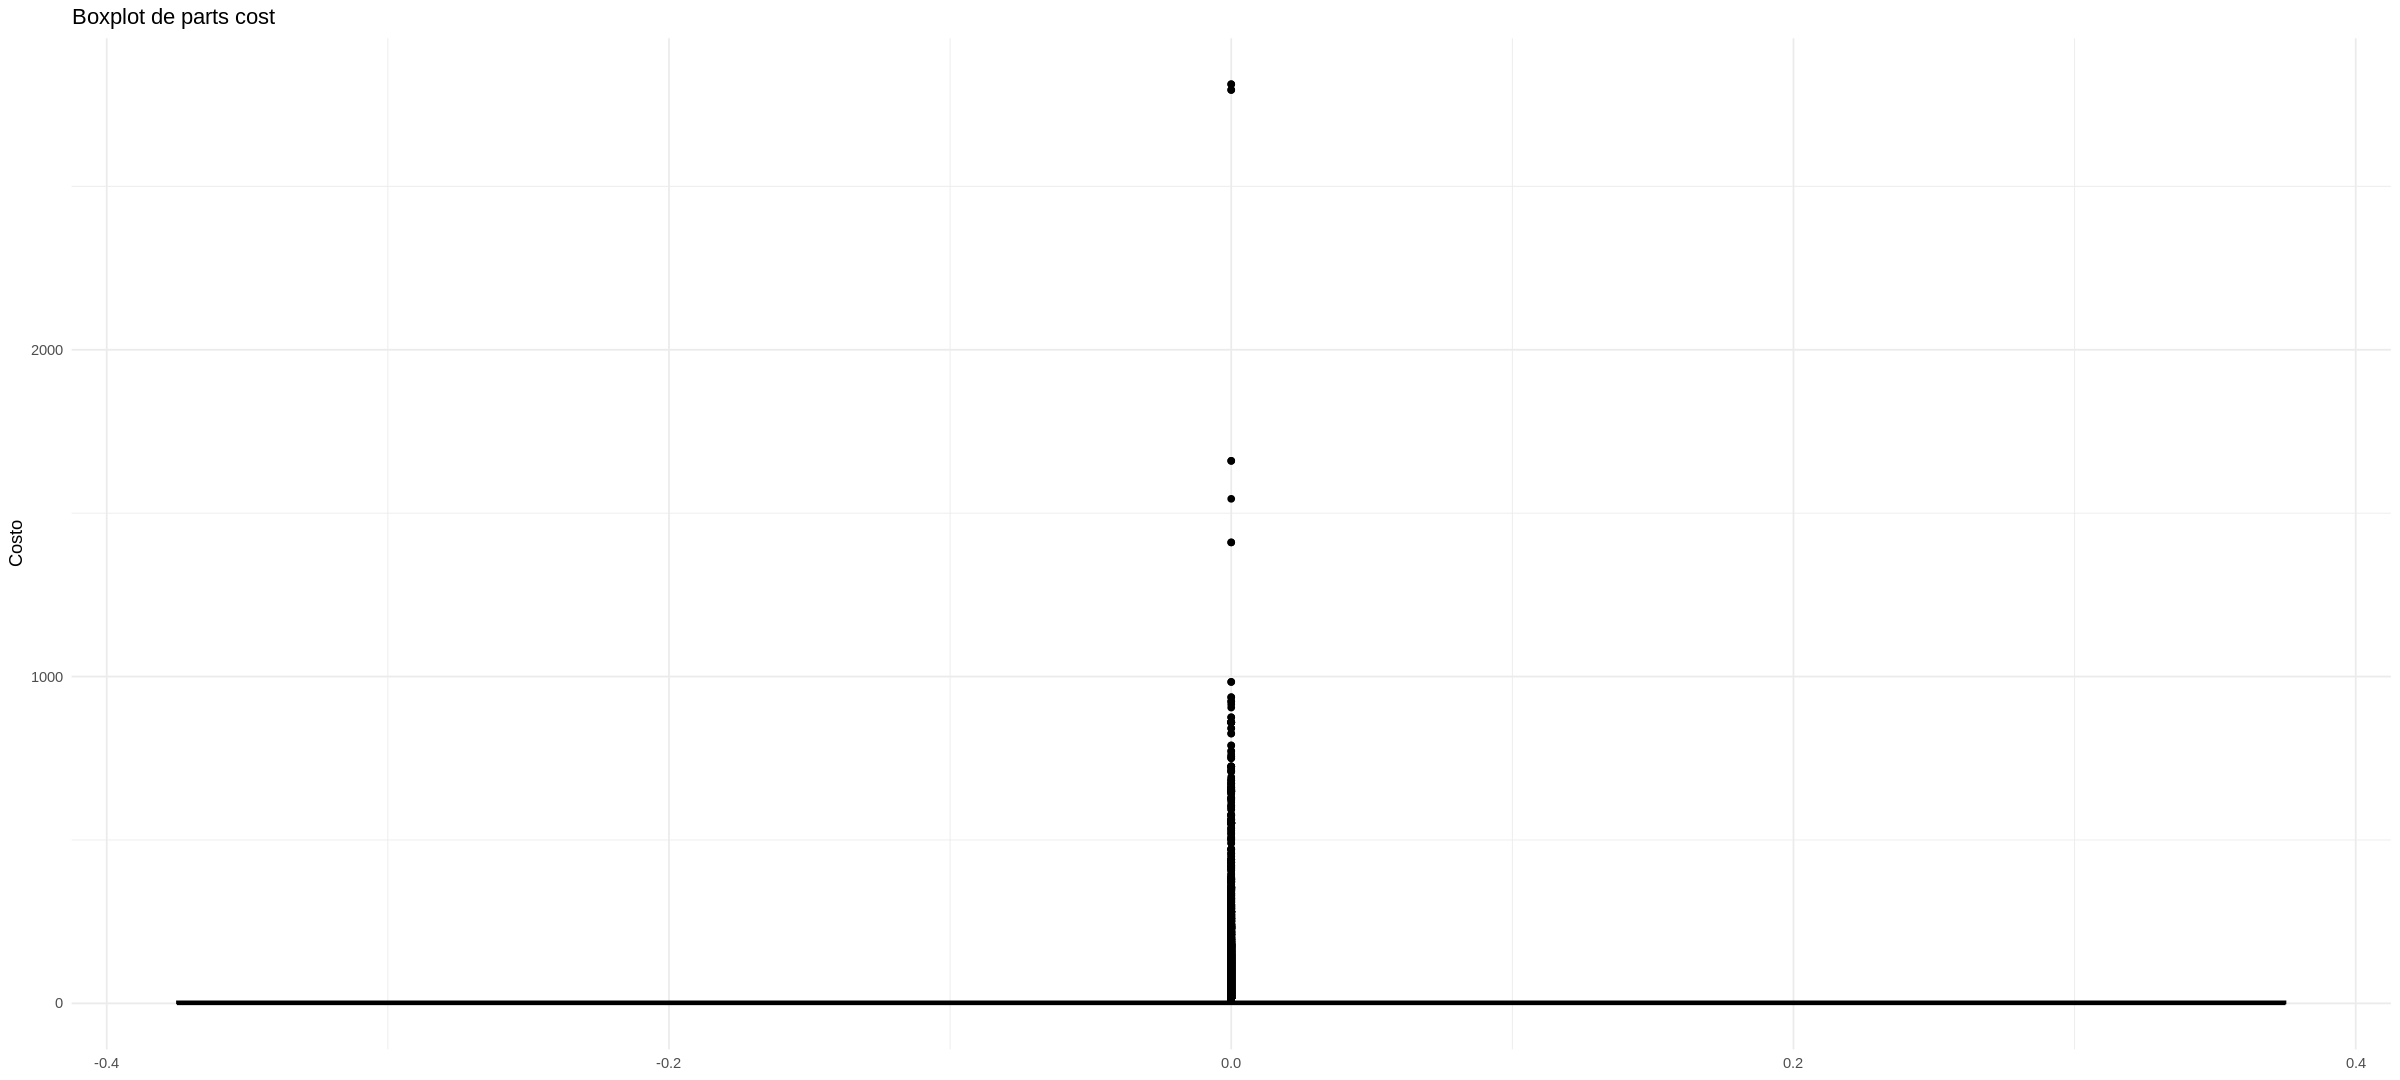

In [112]:
# Crear el boxplot de costo de partes
ggplot(df, aes(y = parts_cost)) +
  geom_boxplot(fill = 'skyblue', color = 'black') +
  labs(title = 'Boxplot de parts cost',
       y = 'Costo') +
  theme_minimal()

Warning message:
“Removed 9408 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


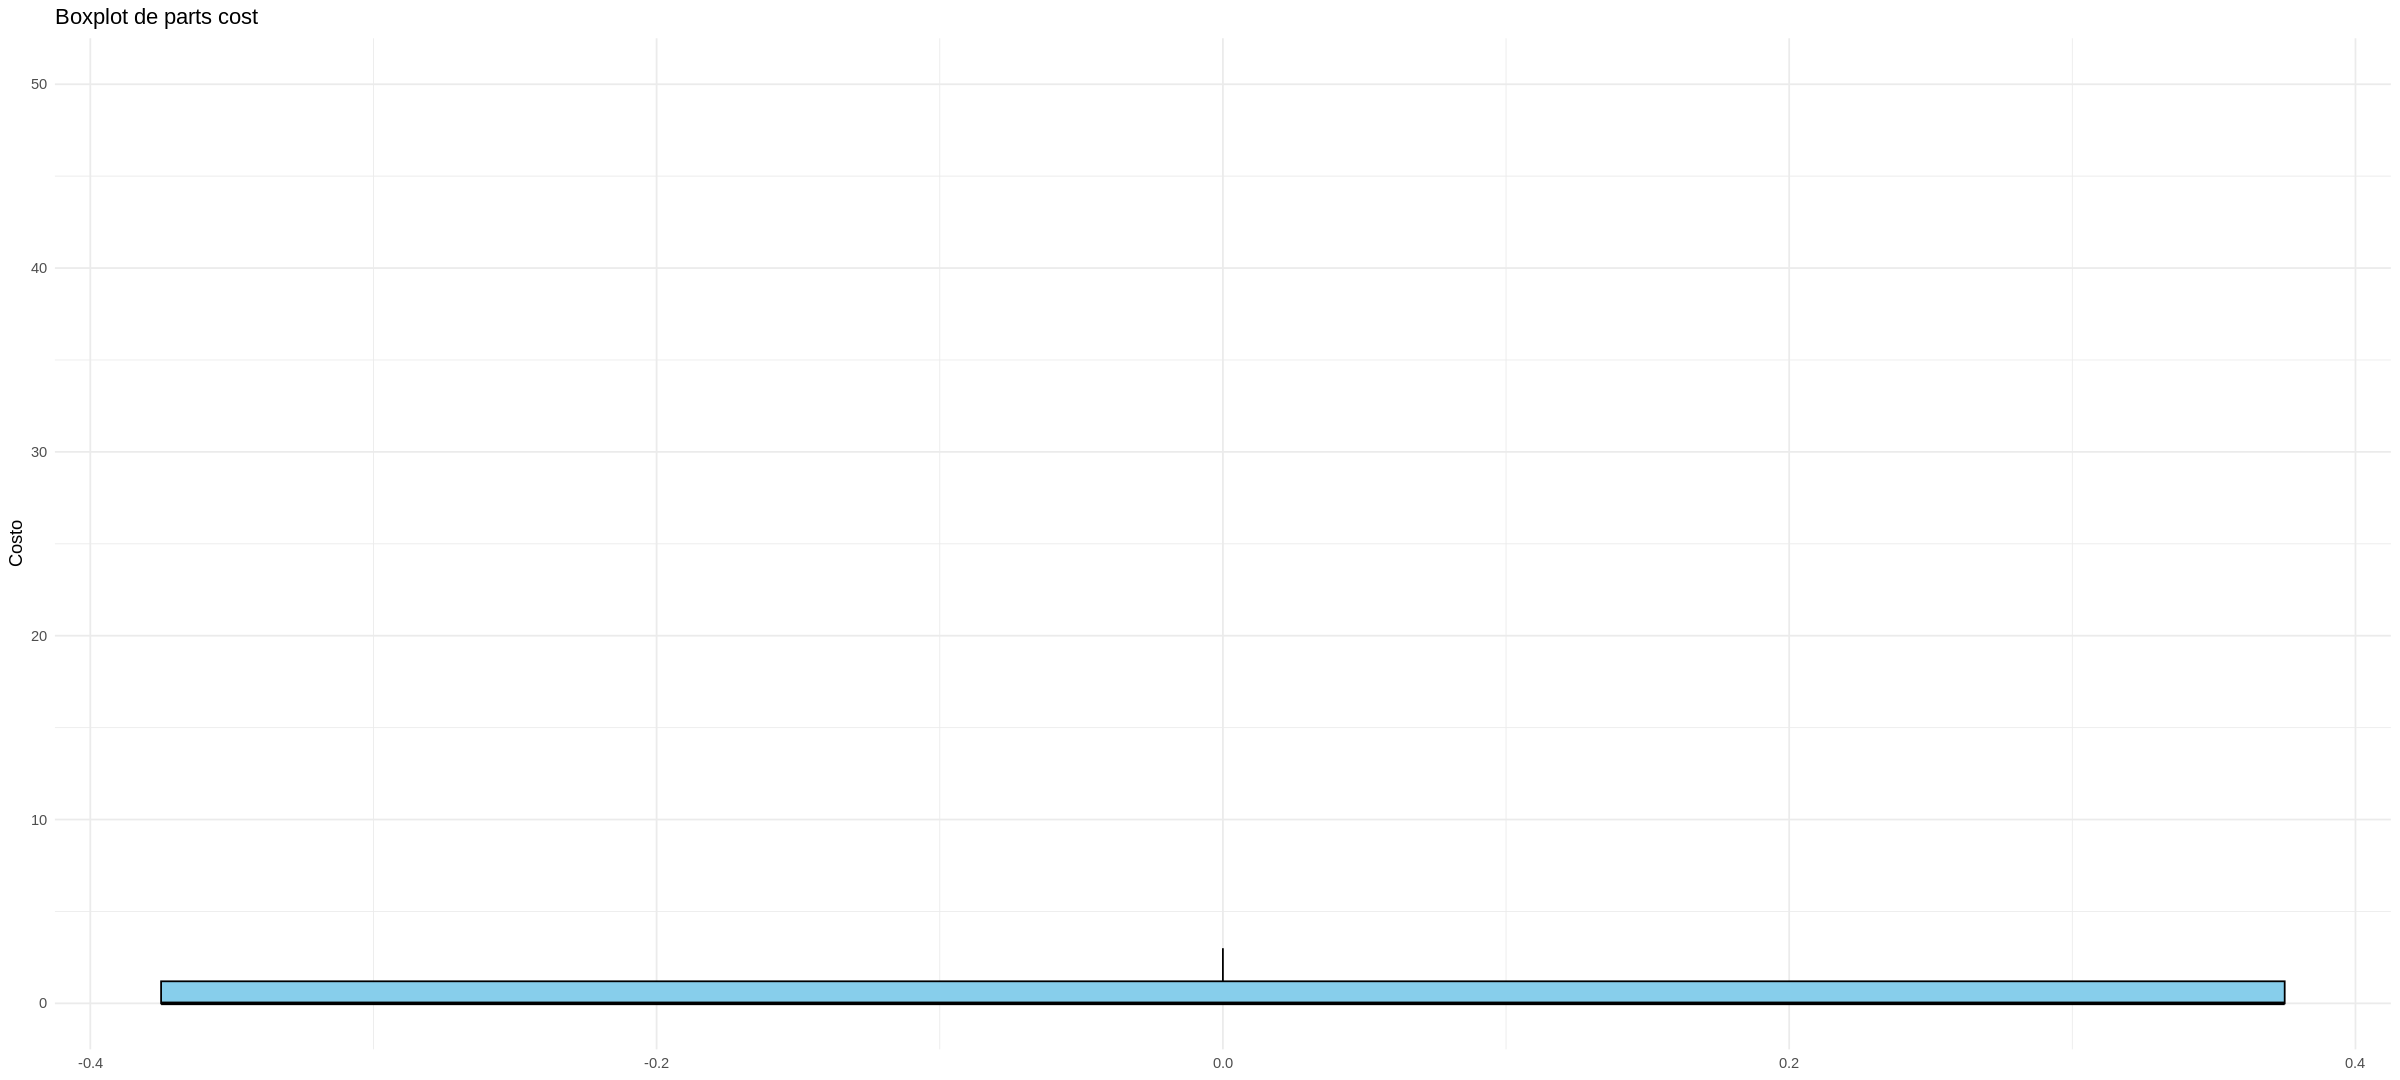

In [113]:
ggplot(df, aes(y = parts_cost)) +
  geom_boxplot(fill = 'skyblue', color = 'black', outlier.shape = NA) +
  labs(title = 'Boxplot de parts cost',
       y = 'Costo') +
  theme_minimal() +
  ylim(0, 50)

In [114]:
mean(df$parts_cost, na.rm = TRUE)      # Media
median(df$parts_cost, na.rm = TRUE)    # Mediana
sd(df$parts_cost, na.rm = TRUE)        # Desviación estándar
var(df$parts_cost, na.rm = TRUE)        # Varianza
range(df$parts_cost, na.rm = TRUE)      # Rango

[1] 12.11324

[1] 0

[1] 41.73935

[1] 1742.173

[1]    0.00 2812.49

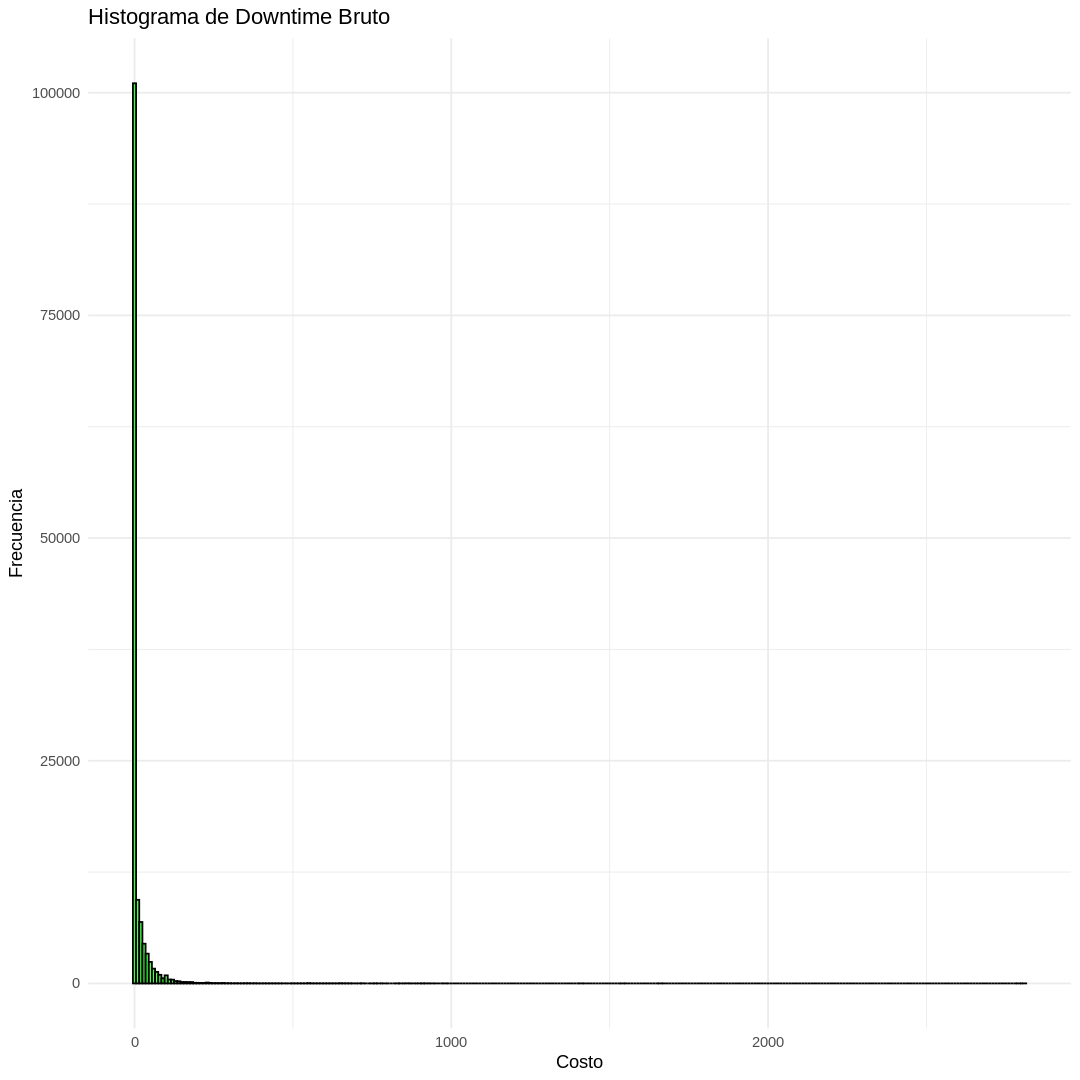

In [115]:
# Histograma de 'parts cost'
options(repr.plot.width=9, repr.plot.height=9)

hist_parts <- ggplot(df, aes(x = parts_cost)) +
  geom_histogram(binwidth = 10, fill = "green", color = "black", alpha = 0.7) +
  labs(title = "Histograma de Downtime Bruto",
       x = "Costo",
       y = "Frecuencia") +
  theme_minimal()

# Mostrar histogramas
print(hist_parts)

# **ANALISIS DE VARIABLE OBJETIVO "DOWNTIME GROSS"**

In [116]:
summary(df$downtime_gross)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   25.00   50.00   87.97  110.00  835.00 

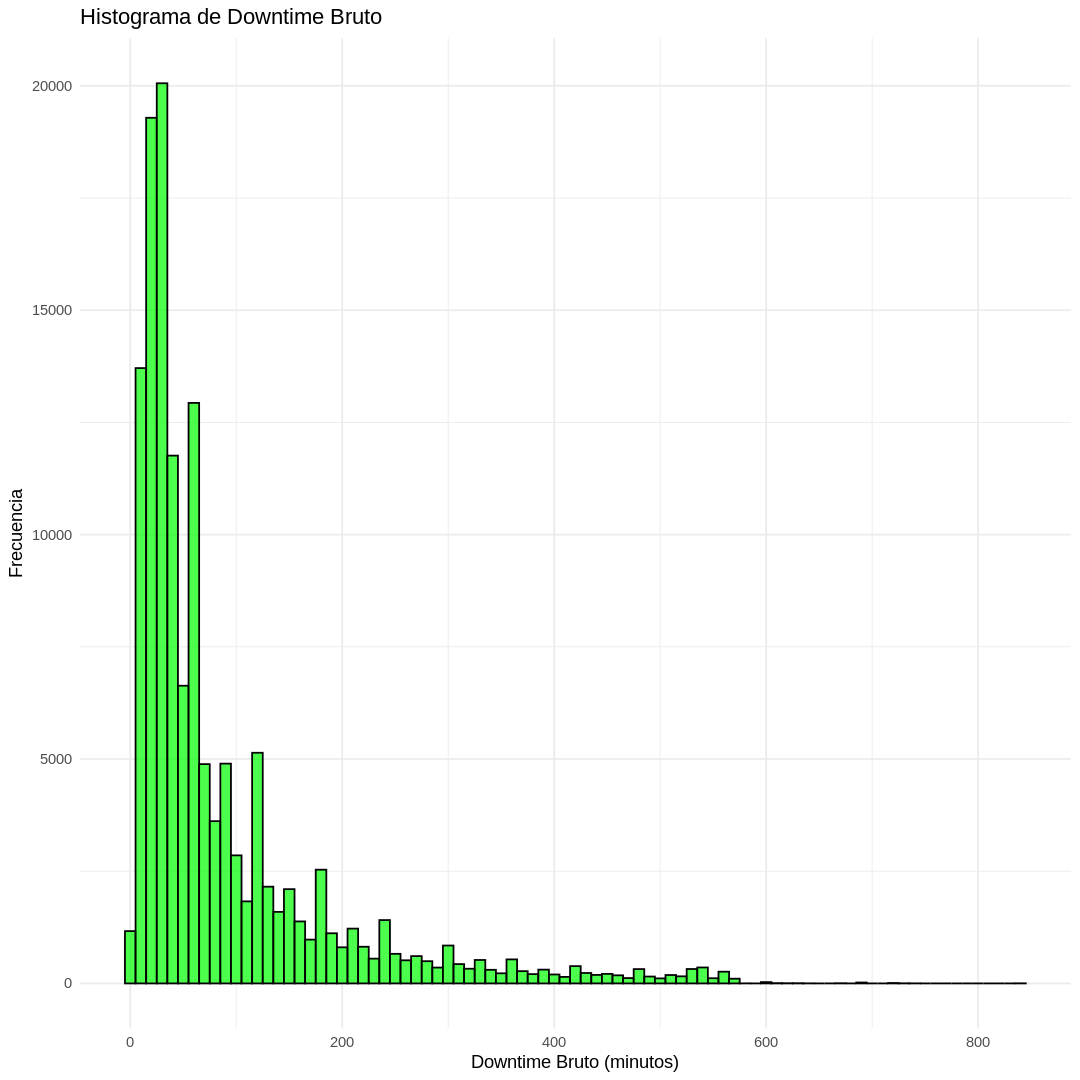

In [117]:
# Histograma de 'downtimeGross'
hist_downtimeGross <- ggplot(df, aes(x = downtime_gross)) +
  geom_histogram(binwidth = 10, fill = "green", color = "black", alpha = 0.7) +
  labs(title = "Histograma de Downtime Bruto",
       x = "Downtime Bruto (minutos)",
       y = "Frecuencia") +
  theme_minimal()

# Mostrar histogramas
print(hist_downtimeGross)

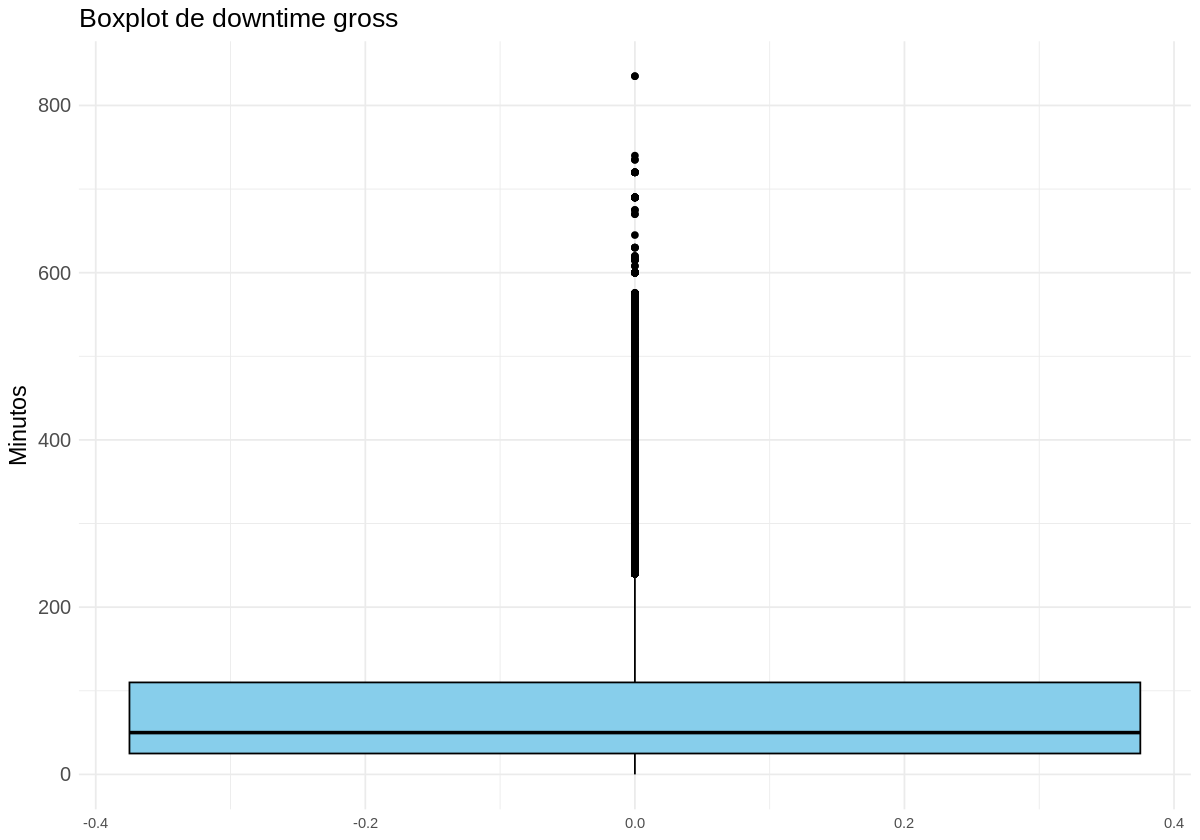

In [118]:
# Crear el boxplot de downtime gross
options(repr.plot.width=10, repr.plot.height=7)
ggplot(df, aes(y = downtime_gross)) +
  geom_boxplot(fill = 'skyblue', color = 'black') +
  labs(title = 'Boxplot de downtime gross',
       y = 'Minutos') +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 12), # Tamaño del texto del eje y
    axis.title.y = element_text(size = 14), # Tamaño del título del eje y
    plot.title = element_text(size = 16)    # Tamaño del título del gráfico
  )

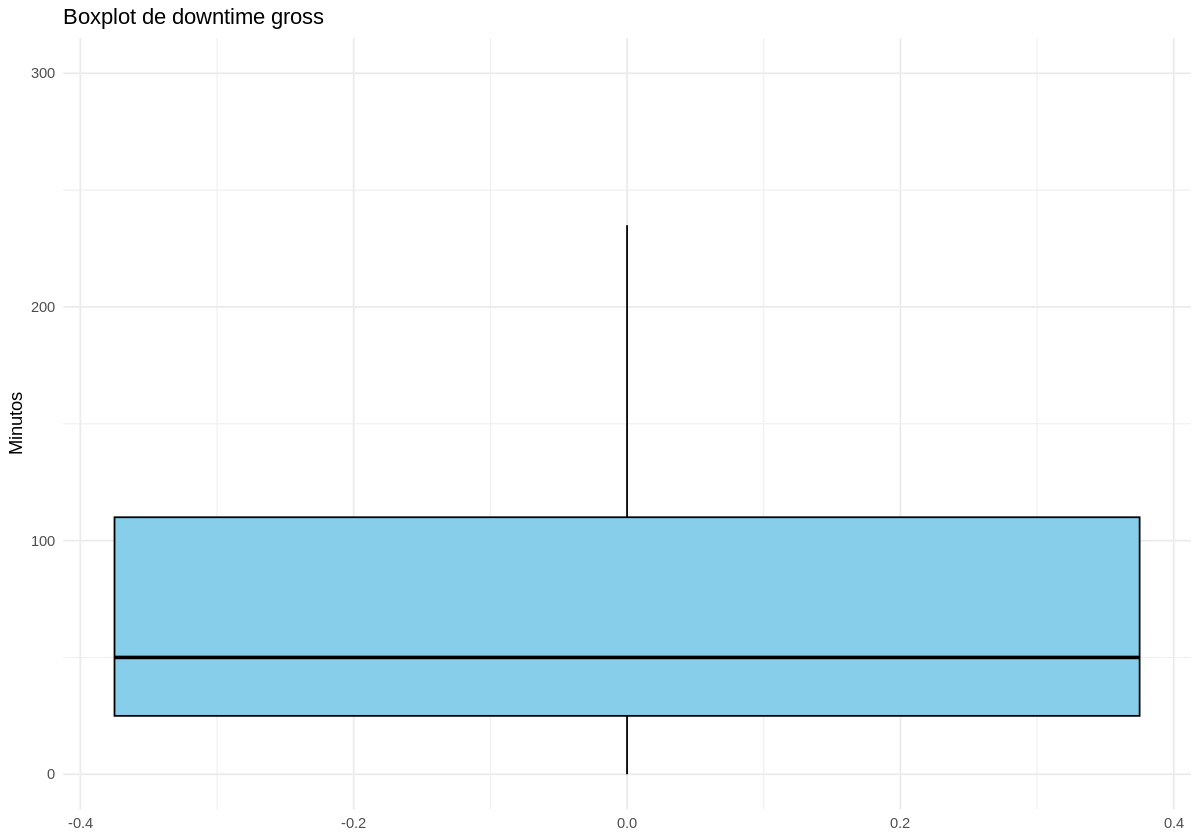

In [119]:
# Crear el boxplot de downtime gross
ggplot(df, aes(y = downtime_gross)) +
  geom_boxplot(fill = 'skyblue', color = 'black', outlier.shape = NA) +
  labs(title = 'Boxplot de downtime gross',
       y = 'Minutos') +
  theme_minimal() + coord_cartesian(ylim = c(0, 300))

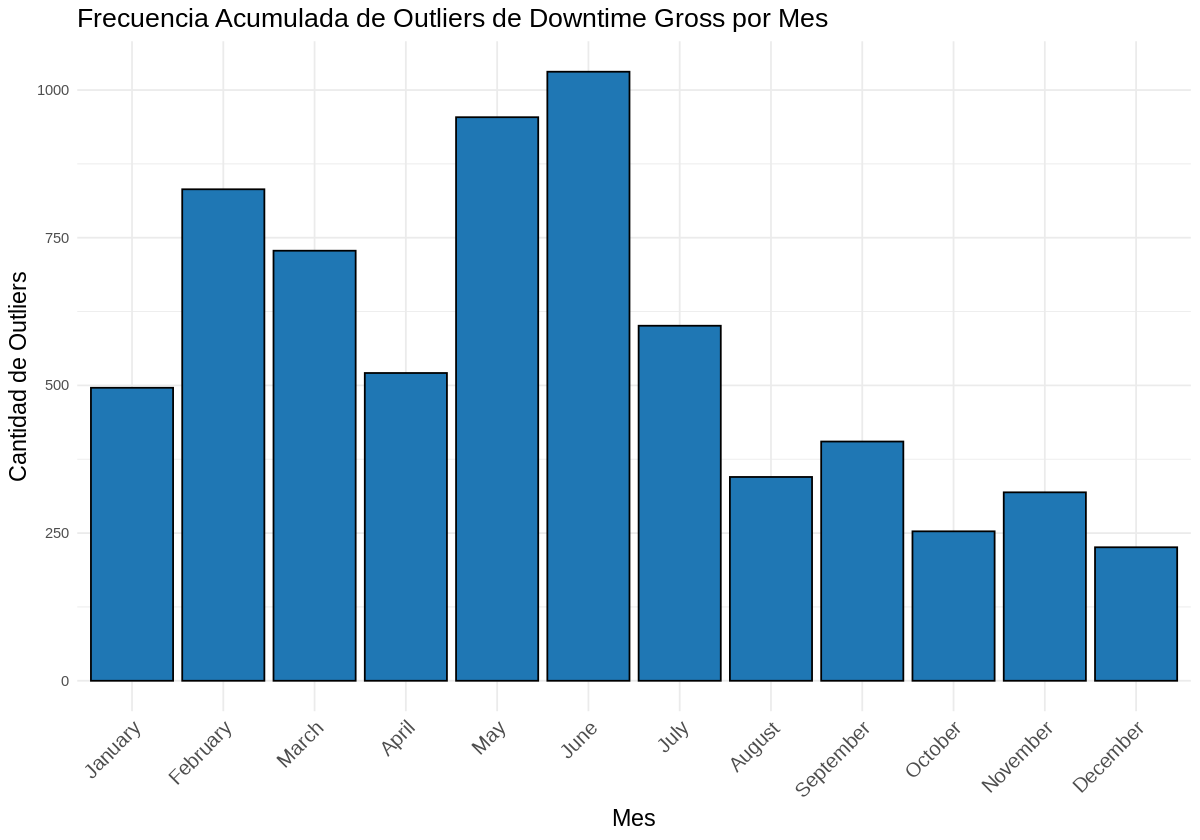

In [120]:
# Calcular el umbral de outliers (95% percentil)
outlier_threshold <- quantile(df$downtime_gross, 0.95)

# Identificar outliers
df$outlier <- ifelse(df$downtime_gross > outlier_threshold, TRUE, FALSE)

# Convertir la columna 'Date' a formato de fecha
df$date <- as.Date(df$date)

# Extraer solo el mes (sin el año) de la fecha
df <- df %>%
  mutate(Month = format(date, "%B")) # Nombre del mes

# Agrupar por mes y calcular la frecuencia acumulada de outliers
df_outliers <- df %>%
  group_by(Month) %>%
  summarise(Outliers = sum(outlier), .groups = 'drop') %>%
  arrange(match(Month, month.name)) # Ordenar por el orden de los meses

# Convertir la columna 'Month' a factor con el orden correcto
df_outliers$Month <- factor(df_outliers$Month, levels = month.name)

# Crear un gráfico de barras de la frecuencia acumulada de outliers por mes
ggplot(df_outliers, aes(x = Month, y = Outliers)) +
  geom_bar(stat = "identity", fill = "#1f77b4", color = 'black') + # Usar un color fijo
  labs(title = 'Frecuencia Acumulada de Outliers de Downtime Gross por Mes',
       x = 'Mes',
       y = 'Cantidad de Outliers') +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 12), # Tamaño y ángulo del texto del eje x
    axis.title.x = element_text(size = 14),                      # Tamaño del título del eje x
    axis.title.y = element_text(size = 14),                      # Tamaño del título del eje y
    plot.title = element_text(size = 16)                         # Tamaño del título del gráfico
  )

In [121]:
# Calcular el umbral de outliers (95% percentil)
outlier_threshold <- quantile(df$downtime_gross, 0.95)

# Identificar outliers en el conjunto de datos original
df$outlier <- ifelse(df$downtime_gross > outlier_threshold, TRUE, FALSE)

# Filtrar por la operación "Hem Sleeve"
df_hem_sleeve <- df %>% filter(operation == "HEM SLEEVE")

# Contar los outliers para la operación "Hem Sleeve"
outliers_count <- sum(df_hem_sleeve$outlier)

# Imprimir el resultado
print(outliers_count)

[1] 2951


In [122]:
# Calcular el umbral de outliers (95% percentil)
outlier_threshold <- quantile(df$downtime_gross, 0.95)

# Identificar outliers en el conjunto de datos original
df$outlier <- ifelse(df$downtime_gross > outlier_threshold, TRUE, FALSE)

# Filtrar por la operación "Hem Sleeve"
df_hem_sleeve <- df %>% filter(operation == "HEM SLEEVE")

# Contar los outliers para la operación "Hem Sleeve"
hem_sleeve_outliers_count <- sum(df_hem_sleeve$outlier)

# Contar el total de outliers en el DataFrame original
total_outliers_count <- sum(df$outlier)

# Calcular el porcentaje de outliers de "Hem Sleeve" respecto al total de outliers
percentage_hem_sleeve_outliers <- (hem_sleeve_outliers_count / total_outliers_count) * 100

# Imprimir el resultado
print(paste("El porcentaje de outliers de 'Hem Sleeve' respecto al total es:", round(percentage_hem_sleeve_outliers, 2), "%"))

[1] "El porcentaje de outliers de 'Hem Sleeve' respecto al total es: 43.97 %"


# **PRUEBA DE HIPOTESIS**

In [123]:
# Instalar e importar el paquete nortest
if (!require(nortest)) install.packages("nortest")
library(nortest)

In [124]:
ad_test <- ad.test(df$downtime_gross)
print(ad_test)


	Anderson-Darling normality test

data:  df$downtime_gross
A = 12836, p-value < 2.2e-16



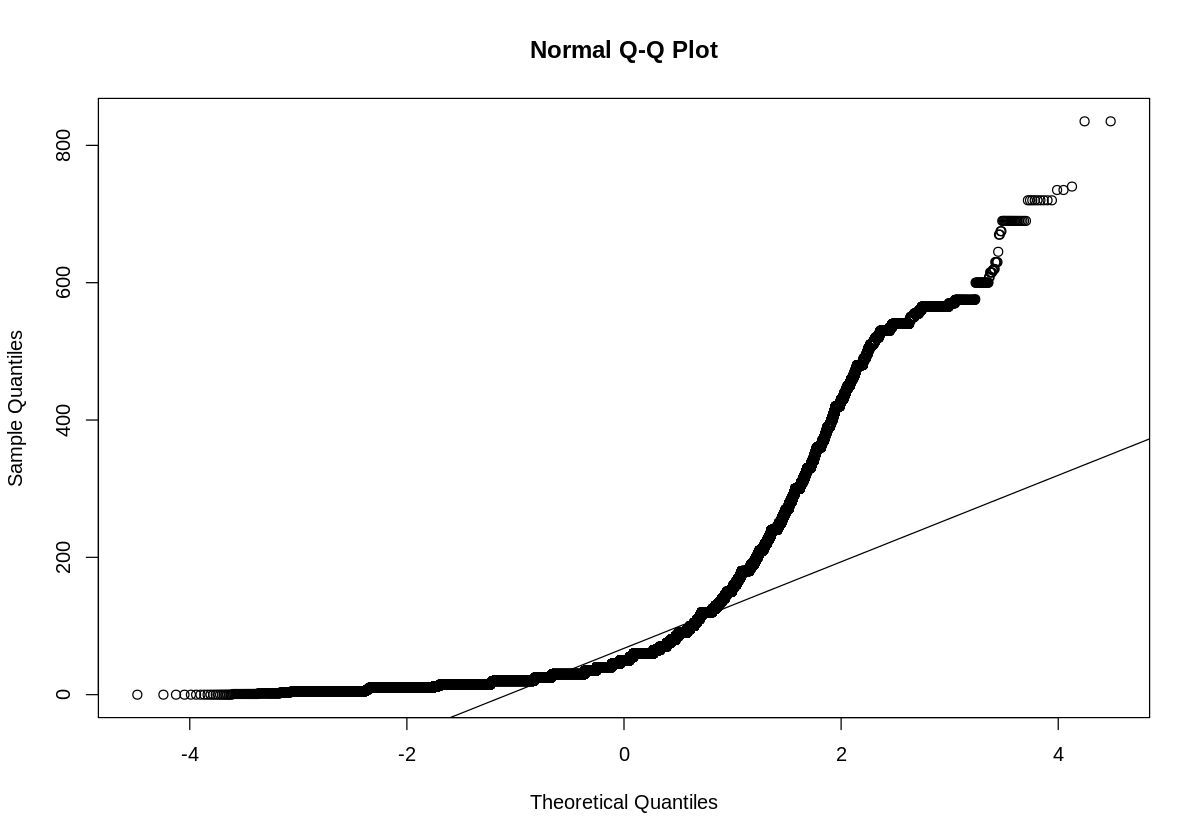

In [125]:
# Crear un gráfico Q-Q
qqnorm(df$downtime_gross)
qqline(df$downtime_gross)

In [126]:
kruskal.test(downtime_gross ~ failure_desc, data = df)


	Kruskal-Wallis rank sum test

data:  downtime_gross by failure_desc
Kruskal-Wallis chi-squared = 1801.9, df = 3, p-value < 2.2e-16


In [127]:
install.packages("dunn.test")
library(dunn.test)

# Realizar la prueba de Dunn
dunn.test(df$downtime_gross, df$failure_desc, kw = TRUE)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 1801.8627, df = 3, p-value = 0


                           Comparison of x by group                            
                                (No adjustment)                                
Col Mean-|
Row Mean |   Machine    Machine       Otros
---------+---------------------------------
Machine  |   18.30044
         |    0.0000*
         |
   Otros |   2.677381  -12.21734
         |    0.0037*    0.0000*
         |
Trim off |   40.56975   30.41336   34.96585
         |    0.0000*    0.0000*    0.0000*

alpha = 0.05
Reject Ho if p <= alpha/2


In [128]:
# Calcular la mediana de downtime_gross por cada categoría de failure_desc
median_values <- df %>%
  group_by(failure_desc) %>%
  summarise(median_downtime = median(downtime_gross))

# Mostrar los resultados
print(median_values)

# A tibble: 4 × 2
  failure_desc                                                   median_downtime
  <chr>                                                                    <dbl>
1 Machine head failure sewing with defect / Falla cabezal cosie…            60  
2 Machine head failure stopping sewing  / Falla cabezal dejando…            50.0
3 Otros                                                                     55.0
4 Trim off device failure / Falla dispositivo corta desperdicio             35.0


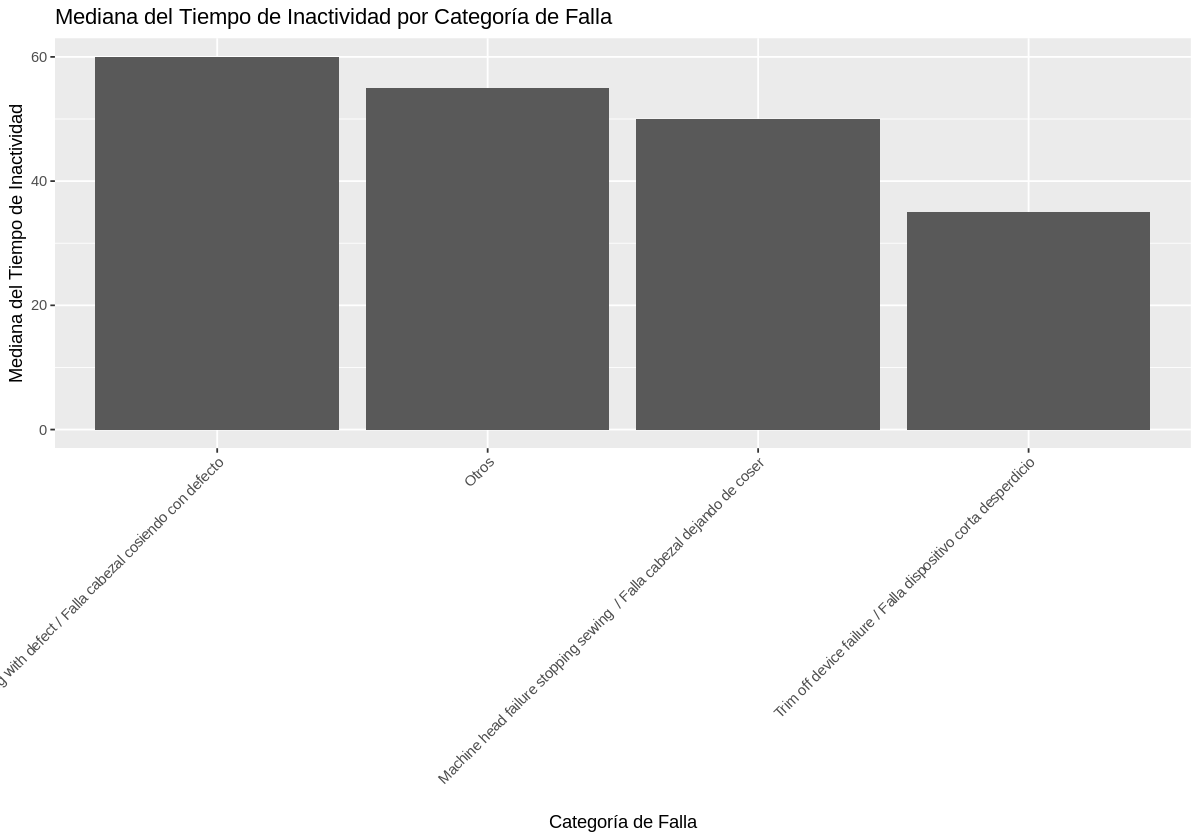

In [129]:
# Crear un gráfico de barras de las medianas
ggplot(median_values, aes(x = reorder(failure_desc, -median_downtime), y = median_downtime)) +
  geom_bar(stat = "identity") +
  xlab("Categoría de Falla") +
  ylab("Mediana del Tiempo de Inactividad") +
  ggtitle("Mediana del Tiempo de Inactividad por Categoría de Falla") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# **MODELOS GLM**



In [130]:
df <- select(df, -wo_type, -outlier, -Month)
#Comparar con un glm

In [131]:
head(df,5)

equipment,operation,base_model,problem_desc,failure_desc,cause_desc,action_desc,mechanic,date,downtime_gross,parts_cost,waiting_hours,changed_pcs,Days_Between_Failures
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1011144,HEM SLEEVE,VC2700,Otros,Trim off device failure / Falla dispositivo corta desperdicio,Damaged trim off system knife / Cuchilla de corta desperdicio en mal estado,Sharpen knife / Afilar cuchillas,DIEGO CUELLAR,2023-01-03,10,51.00,0,0,2
1013453,TOP STITCH,VC2713,It sews with defect / Cose con defecto,Machine head failure stopping sewing / Falla cabezal dejando de coser,Misadjusted machine head needle guard / Guarda aguja de cabezal desajustada,Adjust machine head needle guard / Ajustar guarda aguja de cabezal,Adalberto Jeremias Rodriguez Zometa,2023-01-03,60,19.20,0,1,2
1013453,TOP STITCH,VC2713,It sews with defect / Cose con defecto,Machine head failure stopping sewing / Falla cabezal dejando de coser,Misadjusted machine head needle guard / Guarda aguja de cabezal desajustada,Adjust machine head needle guard / Ajustar guarda aguja de cabezal,Adalberto Jeremias Rodriguez Zometa,2023-01-03,60,19.20,0,1,0
1027243,SET SLEEVE,VC2700,It sews with defect / Cose con defecto,Machine head failure sewing with defect / Falla cabezal cosiendo con defecto,Oil leak in machine head / Fuga de aceite lubricante en cabezal,Fix machine head oil leak / Corregir fuga de aceite en cabezal,Otros,2023-01-03,30,60.69,0,1,2
1027243,SET SLEEVE,VC2700,It sews with defect / Cose con defecto,Machine head failure sewing with defect / Falla cabezal cosiendo con defecto,Oil leak in machine head / Fuga de aceite lubricante en cabezal,Fix machine head oil leak / Corregir fuga de aceite en cabezal,Otros,2023-01-03,30,60.69,0,1,0


In [132]:
# Establecer una semilla para reproducibilidad
set.seed(123)

# Definir proporciones para entrenamiento, validación y prueba
train_proportion <- 0.70
validation_proportion <- 0.20
test_proportion <- 0.10

# Calcular tamaños de cada conjunto
n <- nrow(df)
n_train <- floor(train_proportion * n)
n_validation <- floor(validation_proportion * n)
n_test <- n - n_train - n_validation  # El resto para prueba

# Crear índices para conjunto de entrenamiento, validación y prueba
trainIndex <- sample(1:n, n_train)
remaining <- setdiff(1:n, trainIndex)
validationIndex <- sample(remaining, n_validation)
testIndex <- setdiff(remaining, validationIndex)

# Crear conjuntos de entrenamiento, validación y prueba
train_data1 <- df[trainIndex, ]
validation_data1 <- df[validationIndex, ]
test_data1 <- df[testIndex, ]

# Comprobar las dimensiones de cada conjunto
cat("Dimensiones del conjunto de entrenamiento: ", dim(train_data1), "\n")
cat("Dimensiones del conjunto de validación: ", dim(validation_data1), "\n")
cat("Dimensiones del conjunto de prueba: ", dim(test_data1), "\n")

Dimensiones del conjunto de entrenamiento:  95100 14 
Dimensiones del conjunto de validación:  27171 14 
Dimensiones del conjunto de prueba:  13587 14 


In [133]:
# Inicializar y ajustar el modelo de regresión lineal
#Dividir en entrenamiento, test, validación por ejemplo 70,20,10
start_time <- Sys.time()
model1 <- glm(downtime_gross~. -equipment -downtime_gross -Days_Between_Failures -date -changed_pcs, data = train_data1)
end_time <- Sys.time()
training_time1 <- end_time - start_time
training_time1
# Resumen del modelo
summary(model1)

Time difference of 7.018229 secs


Call:
glm(formula = downtime_gross ~ . - equipment - downtime_gross - 
    Days_Between_Failures - date - changed_pcs, data = train_data1)

Coefficients:
                                                                                             Estimate
(Intercept)                                                                                 17.010838
operationBARTACK                                                                             3.916412
operationBIND ARM                                                                           -5.673010
operationBIND LEG                                                                            2.637063
operationBIND NECK                                                                          -5.634968
operationCLOSE SLEEVE                                                                        4.823515
operationFLAT LOCK                                                                           1.430791
operationFLAT SEAM           

In [134]:
# Predecir con el conjunto de validación
validation_predictions <- predict(model1, newdata = validation_data1)

# Calcular métricas de rendimiento para el conjunto de validación
validation_actuals <- validation_data1$downtime_gross
validation_rmse <- sqrt(mean((validation_predictions - validation_actuals)^2))
validation_mae <- mean(abs(validation_predictions - validation_actuals))
validation_r2 <- 1 - (sum((validation_predictions - validation_actuals)^2) / sum((validation_actuals - mean(validation_actuals))^2))

cat("Validation RMSE: ", validation_rmse, "\n")
cat("Validation MAE: ", validation_mae, "\n")
cat("Validation R-squared: ", validation_r2, "\n")

Validation RMSE:  67.07267 
Validation MAE:  39.48481 
Validation R-squared:  0.5589545 


In [135]:
# Predecir con el conjunto de prueba
test_predictions <- predict(model1, newdata = test_data1)

# Calcular métricas de rendimiento para el conjunto de prueba
test_actuals <- test_data1$downtime_gross
test_rmse <- sqrt(mean((test_predictions - test_actuals)^2))
test_mae <- mean(abs(test_predictions - test_actuals))
test_r2 <- 1 - (sum((test_predictions - test_actuals)^2) / sum((test_actuals - mean(test_actuals))^2))

cat("Test RMSE: ", test_rmse, "\n")
cat("Test MAE: ", test_mae, "\n")
cat("Test R-squared: ", test_r2, "\n")

Test RMSE:  66.92019 
Test MAE:  39.54054 
Test R-squared:  0.5657469 


**CALCULO DE VARIABLES**

In [136]:
#Calcular los fallos acumulativos
df <- df %>%
  group_by(equipment) %>%
  mutate(Cumulative_Failure_Count = row_number())

In [137]:
# Calcular el costo acumulado de mantenimiento
df <- df %>%
  group_by(equipment) %>%
  mutate(Cumulative_Maintenance_Cost = cumsum(parts_cost))

In [138]:
# Establecer una semilla para reproducibilidad
set.seed(123)

# Definir proporciones para entrenamiento, validación y prueba
train_proportion <- 0.70
validation_proportion <- 0.20
test_proportion <- 0.10

# Calcular tamaños de cada conjunto
n <- nrow(df)
n_train <- floor(train_proportion * n)
n_validation <- floor(validation_proportion * n)
n_test <- n - n_train - n_validation  # El resto para prueba

# Crear índices para conjunto de entrenamiento, validación y prueba
trainIndex <- sample(1:n, n_train)
remaining <- setdiff(1:n, trainIndex)
validationIndex <- sample(remaining, n_validation)
testIndex <- setdiff(remaining, validationIndex)

# Crear conjuntos de entrenamiento, validación y prueba
train_data2 <- df[trainIndex, ]
validation_data2 <- df[validationIndex, ]
test_data2 <- df[testIndex, ]

# Comprobar las dimensiones de cada conjunto
cat("Dimensiones del conjunto de entrenamiento: ", dim(train_data2), "\n")
cat("Dimensiones del conjunto de validación: ", dim(validation_data2), "\n")
cat("Dimensiones del conjunto de prueba: ", dim(test_data2), "\n")

Dimensiones del conjunto de entrenamiento:  95100 16 
Dimensiones del conjunto de validación:  27171 16 
Dimensiones del conjunto de prueba:  13587 16 


**GLM PARA PREDECIR DOWNTIME CON VARIABLES CALCULADAS**

In [139]:
# Inicializar y ajustar el modelo de regresión lineal
start_time <- Sys.time()
model2 <- glm(downtime_gross~. -equipment -downtime_gross -date -changed_pcs, data = train_data2)
end_time <- Sys.time()
training_time2 <- end_time - start_time
training_time2
# Resumen del modelo
summary(model2)

Time difference of 7.106801 secs


Call:
glm(formula = downtime_gross ~ . - equipment - downtime_gross - 
    date - changed_pcs, data = train_data2)

Coefficients:
                                                                                             Estimate
(Intercept)                                                                                 1.963e+01
operationBARTACK                                                                            3.825e+00
operationBIND ARM                                                                          -5.856e+00
operationBIND LEG                                                                           2.342e+00
operationBIND NECK                                                                         -5.626e+00
operationCLOSE SLEEVE                                                                       4.889e+00
operationFLAT LOCK                                                                          1.204e+00
operationFLAT SEAM                                   

In [140]:
# Predecir con el conjunto de validación
validation_predictions <- predict(model2, newdata = validation_data2)

# Calcular métricas de rendimiento para el conjunto de validación
validation_actuals <- validation_data2$downtime_gross
validation_rmse <- sqrt(mean((validation_predictions - validation_actuals)^2))
validation_mae <- mean(abs(validation_predictions - validation_actuals))
validation_r2 <- 1 - (sum((validation_predictions - validation_actuals)^2) / sum((validation_actuals - mean(validation_actuals))^2))

cat("Validation RMSE: ", validation_rmse, "\n")
cat("Validation MAE: ", validation_mae, "\n")
cat("Validation R-squared: ", validation_r2, "\n")

Validation RMSE:  67.0423 
Validation MAE:  39.46484 
Validation R-squared:  0.5593538 


In [141]:
# Predecir con el conjunto de prueba (ya calculado, pero repitiendo para claridad)
test_predictions <- predict(model2, newdata = test_data2)

# Calcular métricas de rendimiento para el conjunto de prueba
test_actuals <- test_data2$downtime_gross
test_rmse <- sqrt(mean((test_predictions - test_actuals)^2))
test_mae <- mean(abs(test_predictions - test_actuals))
test_r2 <- 1 - (sum((test_predictions - test_actuals)^2) / sum((test_actuals - mean(test_actuals))^2))

cat("Test RMSE: ", test_rmse, "\n")
cat("Test MAE: ", test_mae, "\n")
cat("Test R-squared: ", test_r2, "\n")

Test RMSE:  66.86983 
Test MAE:  39.51634 
Test R-squared:  0.5664002 


**MODELO INCLUYENDO LA VARIABLE "MACHINE AGE"**

In [142]:
# Renombrar la columna 'Equipment' a 'equipment' en df_age
df_age <- df_age %>% rename(equipment = Equipment)

In [143]:
df_merged <- df %>%
  left_join(df_age %>% select(equipment, Age), by = "equipment")

In [144]:
head(df_merged,3)

equipment,operation,base_model,problem_desc,failure_desc,cause_desc,action_desc,mechanic,date,downtime_gross,parts_cost,waiting_hours,changed_pcs,Days_Between_Failures,Cumulative_Failure_Count,Cumulative_Maintenance_Cost,Age
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1011144,HEM SLEEVE,VC2700,Otros,Trim off device failure / Falla dispositivo corta desperdicio,Damaged trim off system knife / Cuchilla de corta desperdicio en mal estado,Sharpen knife / Afilar cuchillas,DIEGO CUELLAR,2023-01-03,10,51.0,0,0,2,1,51.0,26
1013453,TOP STITCH,VC2713,It sews with defect / Cose con defecto,Machine head failure stopping sewing / Falla cabezal dejando de coser,Misadjusted machine head needle guard / Guarda aguja de cabezal desajustada,Adjust machine head needle guard / Ajustar guarda aguja de cabezal,Adalberto Jeremias Rodriguez Zometa,2023-01-03,60,19.2,0,1,2,1,19.2,23
1013453,TOP STITCH,VC2713,It sews with defect / Cose con defecto,Machine head failure stopping sewing / Falla cabezal dejando de coser,Misadjusted machine head needle guard / Guarda aguja de cabezal desajustada,Adjust machine head needle guard / Ajustar guarda aguja de cabezal,Adalberto Jeremias Rodriguez Zometa,2023-01-03,60,19.2,0,1,0,2,38.4,23


In [145]:
# Establecer una semilla para reproducibilidad
set.seed(123)

# Definir proporciones para entrenamiento, validación y prueba
train_proportion <- 0.70
validation_proportion <- 0.20
test_proportion <- 0.10

# Calcular tamaños de cada conjunto
n <- nrow(df_merged)
n_train <- floor(train_proportion * n)
n_validation <- floor(validation_proportion * n)
n_test <- n - n_train - n_validation  # El resto para prueba

# Crear índices para conjunto de entrenamiento, validación y prueba
trainIndex <- sample(1:n, n_train)
remaining <- setdiff(1:n, trainIndex)
validationIndex <- sample(remaining, n_validation)
testIndex <- setdiff(remaining, validationIndex)

# Crear conjuntos de entrenamiento, validación y prueba
train_data3 <- df_merged[trainIndex, ]
validation_data3 <- df_merged[validationIndex, ]
test_data3 <- df_merged[testIndex, ]

# Comprobar las dimensiones de cada conjunto
cat("Dimensiones del conjunto de entrenamiento: ", dim(train_data3), "\n")
cat("Dimensiones del conjunto de validación: ", dim(validation_data3), "\n")
cat("Dimensiones del conjunto de prueba: ", dim(test_data3), "\n")

Dimensiones del conjunto de entrenamiento:  95100 17 
Dimensiones del conjunto de validación:  27171 17 
Dimensiones del conjunto de prueba:  13587 17 


In [146]:
# Inicializar y ajustar el modelo de regresión lineal
start_time <- Sys.time()
model3 <- glm(downtime_gross~. -equipment -downtime_gross -date -changed_pcs, data = train_data3)
end_time <- Sys.time()
training_time3 <- end_time - start_time
training_time3
# Resumen del modelo
summary(model3)

Time difference of 6.844643 secs


Call:
glm(formula = downtime_gross ~ . - equipment - downtime_gross - 
    date - changed_pcs, data = train_data3)

Coefficients:
                                                                                             Estimate
(Intercept)                                                                                 1.357e+01
operationBARTACK                                                                            4.893e+00
operationBIND ARM                                                                          -5.516e+00
operationBIND LEG                                                                           2.977e+00
operationBIND NECK                                                                         -5.032e+00
operationCLOSE SLEEVE                                                                       5.701e+00
operationFLAT LOCK                                                                          2.303e+00
operationFLAT SEAM                                   

In [147]:
# Predecir con el conjunto de validación
validation_predictions <- predict(model3, newdata = validation_data3)

# Calcular métricas de rendimiento para el conjunto de validación
validation_actuals <- validation_data3$downtime_gross
validation_rmse <- sqrt(mean((validation_predictions - validation_actuals)^2))
validation_mae <- mean(abs(validation_predictions - validation_actuals))
validation_r2 <- 1 - (sum((validation_predictions - validation_actuals)^2) / sum((validation_actuals - mean(validation_actuals))^2))

cat("Validation RMSE: ", validation_rmse, "\n")
cat("Validation MAE: ", validation_mae, "\n")
cat("Validation R-squared: ", validation_r2, "\n")

Validation RMSE:  67.01504 
Validation MAE:  39.44415 
Validation R-squared:  0.5597121 


In [148]:
# Predecir con el conjunto de prueba
test_predictions <- predict(model3, newdata = test_data3)

# Calcular métricas de rendimiento para el conjunto de prueba
test_actuals <- test_data3$downtime_gross
test_rmse <- sqrt(mean((test_predictions - test_actuals)^2))
test_mae <- mean(abs(test_predictions - test_actuals))
test_r2 <- 1 - (sum((test_predictions - test_actuals)^2) / sum((test_actuals - mean(test_actuals))^2))

cat("Test RMSE: ", test_rmse, "\n")
cat("Test MAE: ", test_mae, "\n")
cat("Test R-squared: ", test_r2, "\n")

Test RMSE:  66.84893 
Test MAE:  39.49358 
Test R-squared:  0.5666711 


**MODELO INCLUYENDO LA VARIABLE "MECHANIC ANTIQUITY"**

In [149]:
# Primero, calcula la media de antiquity
mean_antiquity <- mean(df_mechanic$antiquity, na.rm = TRUE)

# Realiza el left join y luego reemplaza los NA en antiquity con la media calculada
df_merged2 <- df_merged %>%
  left_join(df_mechanic %>% select(mechanic, antiquity), by = "mechanic") %>%
  mutate(antiquity = ifelse(is.na(antiquity), mean_antiquity, antiquity))

In [150]:
# Establecer una semilla para reproducibilidad
set.seed(123)

# Definir proporciones para entrenamiento, validación y prueba
train_proportion <- 0.70
validation_proportion <- 0.20
test_proportion <- 0.10

# Calcular tamaños de cada conjunto
n <- nrow(df_merged2)
n_train <- floor(train_proportion * n)
n_validation <- floor(validation_proportion * n)
n_test <- n - n_train - n_validation  # El resto para prueba

# Crear índices para conjunto de entrenamiento, validación y prueba
trainIndex <- sample(1:n, n_train)
remaining <- setdiff(1:n, trainIndex)
validationIndex <- sample(remaining, n_validation)
testIndex <- setdiff(remaining, validationIndex)

# Crear conjuntos de entrenamiento, validación y prueba
train_data4 <- df_merged2[trainIndex, ]
validation_data4 <- df_merged2[validationIndex, ]
test_data4 <- df_merged2[testIndex, ]

# Comprobar las dimensiones de cada conjunto
cat("Dimensiones del conjunto de entrenamiento: ", dim(train_data4), "\n")
cat("Dimensiones del conjunto de validación: ", dim(validation_data4), "\n")
cat("Dimensiones del conjunto de prueba: ", dim(test_data4), "\n")

Dimensiones del conjunto de entrenamiento:  95100 18 
Dimensiones del conjunto de validación:  27171 18 
Dimensiones del conjunto de prueba:  13587 18 


In [151]:
# Inicializar y ajustar el modelo de regresión lineal
start_time <- Sys.time()
model4 <- glm(downtime_gross~. -equipment -downtime_gross -date -changed_pcs, data = train_data4)
end_time <- Sys.time()
training_time4 <- end_time - start_time
training_time4
# Resumen del modelo
summary(model4)

Time difference of 7.834243 secs


Call:
glm(formula = downtime_gross ~ . - equipment - downtime_gross - 
    date - changed_pcs, data = train_data4)

Coefficients: (1 not defined because of singularities)
                                                                                             Estimate
(Intercept)                                                                                 1.357e+01
operationBARTACK                                                                            4.893e+00
operationBIND ARM                                                                          -5.516e+00
operationBIND LEG                                                                           2.977e+00
operationBIND NECK                                                                         -5.032e+00
operationCLOSE SLEEVE                                                                       5.701e+00
operationFLAT LOCK                                                                          2.303e+00
operationFLA

In [152]:
# Predecir con el conjunto de validación
validation_predictions <- predict(model4, newdata = validation_data4)

# Calcular métricas de rendimiento para el conjunto de validación
validation_actuals <- validation_data4$downtime_gross
validation_rmse <- sqrt(mean((validation_predictions - validation_actuals)^2))
validation_mae <- mean(abs(validation_predictions - validation_actuals))
validation_r2 <- 1 - (sum((validation_predictions - validation_actuals)^2) / sum((validation_actuals - mean(validation_actuals))^2))

cat("Validation RMSE: ", validation_rmse, "\n")
cat("Validation MAE: ", validation_mae, "\n")
cat("Validation R-squared: ", validation_r2, "\n")

Validation RMSE:  67.01504 
Validation MAE:  39.44415 
Validation R-squared:  0.5597121 


In [153]:
# Predecir con el conjunto de prueba
test_predictions <- predict(model4, newdata = test_data4)

# Calcular métricas de rendimiento para el conjunto de prueba
test_actuals <- test_data4$downtime_gross
test_rmse <- sqrt(mean((test_predictions - test_actuals)^2))
test_mae <- mean(abs(test_predictions - test_actuals))
test_r2 <- 1 - (sum((test_predictions - test_actuals)^2) / sum((test_actuals - mean(test_actuals))^2))

cat("Test RMSE: ", test_rmse, "\n")
cat("Test MAE: ", test_mae, "\n")
cat("Test R-squared: ", test_r2, "\n")

Test RMSE:  66.84893 
Test MAE:  39.49358 
Test R-squared:  0.5666711 


**MODELO INCLUYENDO LA VARIABLE "CHANGED_PCS"**

In [154]:
# Inicializar y ajustar el modelo de regresión lineal
start_time <- Sys.time()
model5 <- glm(downtime_gross~. -equipment -downtime_gross -date -antiquity, data = train_data4)
end_time <- Sys.time()
training_time5 <- end_time - start_time
training_time5
# Resumen del modelo
summary(model5)

Time difference of 7.107959 secs


Call:
glm(formula = downtime_gross ~ . - equipment - downtime_gross - 
    date - antiquity, data = train_data4)

Coefficients:
                                                                                             Estimate
(Intercept)                                                                                 1.409e+00
operationBARTACK                                                                            4.406e-02
operationBIND ARM                                                                          -7.398e-01
operationBIND LEG                                                                          -1.162e+00
operationBIND NECK                                                                         -4.564e-01
operationCLOSE SLEEVE                                                                       5.049e-01
operationFLAT LOCK                                                                          5.458e-01
operationFLAT SEAM                                     

In [155]:
# Predecir con el conjunto de validación
validation_predictions <- predict(model5, newdata = validation_data4)

# Calcular métricas de rendimiento para el conjunto de validación
validation_actuals <- validation_data4$downtime_gross
validation_rmse <- sqrt(mean((validation_predictions - validation_actuals)^2))
validation_mae <- mean(abs(validation_predictions - validation_actuals))
validation_r2 <- 1 - (sum((validation_predictions - validation_actuals)^2) / sum((validation_actuals - mean(validation_actuals))^2))

cat("Validation RMSE: ", validation_rmse, "\n")
cat("Validation MAE: ", validation_mae, "\n")
cat("Validation R-squared: ", validation_r2, "\n")

Validation RMSE:  17.72352 
Validation MAE:  14.92842 
Validation R-squared:  0.9692041 


In [156]:
# Predecir con el conjunto de prueba
test_predictions <- predict(model5, newdata = test_data4)

# Calcular métricas de rendimiento para el conjunto de prueba
test_actuals <- test_data4$downtime_gross
test_rmse <- sqrt(mean((test_predictions - test_actuals)^2))
test_mae <- mean(abs(test_predictions - test_actuals))
test_r2 <- 1 - (sum((test_predictions - test_actuals)^2) / sum((test_actuals - mean(test_actuals))^2))

cat("Test RMSE: ", test_rmse, "\n")
cat("Test MAE: ", test_mae, "\n")
cat("Test R-squared: ", test_r2, "\n")

Test RMSE:  17.56808 
Test MAE:  14.76287 
Test R-squared:  0.970072 


**IMPLEMENTACION DE FRONTWARD**

In [157]:
sapply(df_merged2, function(x) sum(is.na(x)))

equipment                   operation 
                          0                           0 
                 base_model                problem_desc 
                          0                           0 
               failure_desc                  cause_desc 
                          0                           0 
                action_desc                    mechanic 
                          0                           0 
                       date              downtime_gross 
                          0                           0 
                 parts_cost               waiting_hours 
                          0                           0 
                changed_pcs       Days_Between_Failures 
                          0                           0 
   Cumulative_Failure_Count Cumulative_Maintenance_Cost 
                          0                           0 
                        Age                   antiquity 
                          0                           0

In [158]:
# Realizar frontward elimination
model_null <- lm(downtime_gross ~ 1, data = train_data4)
model_forward <- step(model_null,
                      scope = list(lower = model_null, upper = model5),
                      direction = "forward")
model_forward$anova

Start:  AIC=879713.1
downtime_gross ~ 1

                              Df Sum of Sq       RSS    AIC
+ waiting_hours                1 506148508 483701696 811615
+ changed_pcs                  1 500060218 489789987 812805
+ mechanic                    85 132541098 857309106 866212
+ operation                   24  37878912 951971293 876050
+ base_model                  21  31230275 958619930 876706
+ action_desc                 28  27301122 962549082 877109
+ cause_desc                  28  25936370 963913834 877244
+ problem_desc                 2  23905344 965944861 877392
+ parts_cost                   1   9364447 980485758 878811
+ failure_desc                 3   7565519 982284685 878989
+ Age                          1   5831346 984018859 879153
+ Days_Between_Failures        1   3883037 985967168 879341
+ Cumulative_Maintenance_Cost  1   3396562 986453643 879388
+ Cumulative_Failure_Count     1   1080976 988769228 879611
<none>                                     989850205 879713

Step,Df,Deviance,Resid. Df,Resid. Dev,AIC
<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
,NA,NA,95099,989850205,879713.1
+ waiting_hours,-1,5.061485e+08,95098,483701696,811615.4
+ changed_pcs,-1,4.527020e+08,95097,30999742,550331.2
+ mechanic,-85,1.099658e+06,95012,29900084,547066.4
+ action_desc,-28,5.859497e+04,94984,29841489,546935.8
+ parts_cost,-1,1.690838e+04,94983,29824581,546883.9
+ base_model,-21,2.132620e+04,94962,29803254,546857.9
+ cause_desc,-28,2.668795e+04,94934,29776566,546828.7
+ failure_desc,-3,6.760718e+03,94931,29769806,546813.1


In [159]:
formula = as.formula("downtime_gross ~ changed_pcs + mechanic + operation + cause_desc +
    problem_desc + Age + base_model + action_desc + failure_desc +
    Days_Between_Failures + Cumulative_Maintenance_Cost + parts_cost")

In [160]:
# Inicializar y ajustar el modelo de regresión lineal
start_time <- Sys.time()
model6 <- glm(formula = formula, data = train_data4)
end_time <- Sys.time()
training_time6 <- end_time - start_time
training_time6
# Resumen del modelo
summary(model6)

Time difference of 6.731102 secs


Call:
glm(formula = formula, data = train_data4)

Coefficients:
                                                                                             Estimate
(Intercept)                                                                                 4.991e+01
changed_pcs                                                                                 5.500e+01
mechanicAdalberto Jeremias Rodriguez Zometa                                                -2.583e+01
mechanicAlfonso Escobar                                                                    -3.554e+01
mechanicAnthony Murillo                                                                    -2.291e+01
mechanicAntony Ulloa                                                                       -2.035e+01
mechanicCain Alfredo Ramirez                                                               -1.380e+00
mechanicCarlos Alberto Alfaro Salamanca                                                     2.651e+01
mechanicCARLOS CA

In [161]:
# Predecir con el conjunto de prueba
test_predictions <- predict(model6, newdata = test_data4)

# Calcular métricas de rendimiento para el conjunto de prueba
test_actuals <- test_data4$downtime_gross
test_rmse <- sqrt(mean((test_predictions - test_actuals)^2))
test_mae <- mean(abs(test_predictions - test_actuals))
test_r2 <- 1 - (sum((test_predictions - test_actuals)^2) / sum((test_actuals - mean(test_actuals))^2))

cat("Test RMSE: ", test_rmse, "\n")
cat("Test MAE: ", test_mae, "\n")
cat("Test R-squared: ", test_r2, "\n")

Test RMSE:  66.48855 
Test MAE:  39.68728 
Test R-squared:  0.5713308 


In [162]:
formula2 = as.formula("downtime_gross ~ changed_pcs*mechanic + operation +
    cause_desc + action_desc + Cumulative_Maintenance_Cost + problem_desc +
    failure_desc + base_model + Days_Between_Failures +
    Age + Cumulative_Failure_Count")

**MODELO CON INTERACCIÓN DE MECHANIC Y CHANGED PIECES**

In [163]:
# Inicializar y ajustar el modelo de regresión lineal
# Medir el tiempo de entrenamiento
start_time <- Sys.time()
model7 <- glm(formula = formula2, data = train_data4)
end_time <- Sys.time()
training_time8 <- end_time - start_time
training_time8
# Resumen del modelo
summary(model7)

Time difference of 14.45506 secs


Call:
glm(formula = formula2, data = train_data4)

Coefficients:
                                                                                             Estimate
(Intercept)                                                                                 5.098e+01
changed_pcs                                                                                 5.335e+01
mechanicAdalberto Jeremias Rodriguez Zometa                                                -2.171e+01
mechanicAlfonso Escobar                                                                    -3.966e+01
mechanicAnthony Murillo                                                                    -2.090e+01
mechanicAntony Ulloa                                                                       -2.112e+01
mechanicCain Alfredo Ramirez                                                               -3.792e+00
mechanicCarlos Alberto Alfaro Salamanca                                                     2.579e+01
mechanicCARLOS C

In [164]:
# Predecir con el conjunto de prueba
test_predictions <- predict(model7, newdata = test_data4)

# Calcular métricas de rendimiento para el conjunto de prueba
test_actuals <- test_data4$downtime_gross
test_rmse <- sqrt(mean((test_predictions - test_actuals)^2))
test_mae <- mean(abs(test_predictions - test_actuals))
test_r2 <- 1 - (sum((test_predictions - test_actuals)^2) / sum((test_actuals - mean(test_actuals))^2))

cat("Test RMSE: ", test_rmse, "\n")
cat("Test MAE: ", test_mae, "\n")
cat("Test R-squared: ", test_r2, "\n")

Test RMSE:  66.40156 
Test MAE:  39.24249 
Test R-squared:  0.5724517 


In [165]:
# Predecir con el conjunto de validación
validation_predictions <- predict(model7, newdata = validation_data4)

# Calcular métricas de rendimiento para el conjunto de validación
validation_actuals <- validation_data4$downtime_gross
validation_rmse <- sqrt(mean((validation_predictions - validation_actuals)^2))
validation_mae <- mean(abs(validation_predictions - validation_actuals))
validation_r2 <- 1 - (sum((validation_predictions - validation_actuals)^2) / sum((validation_actuals - mean(validation_actuals))^2))

cat("Validation RMSE: ", validation_rmse, "\n")
cat("Validation MAE: ", validation_mae, "\n")
cat("Validation R-squared: ", validation_r2, "\n")

Validation RMSE:  66.65351 
Validation MAE:  39.35493 
Validation R-squared:  0.5644498 


In [166]:
# Lista de todas las variables independientes disponibles
variables <- c("changed_pcs", "mechanic", "operation", "cause_desc",
               "problem_desc", "Age", "base_model", "action_desc",
               "failure_desc", "Days_Between_Failures",
               "Cumulative_Maintenance_Cost", "parts_cost")

# Crear una lista para almacenar los modelos y un data frame para los resultados
modelos <- list()
resultados <- data.frame(Modelo = character(), Variables = character(), Error = numeric(), R_Squared = numeric(), stringsAsFactors = FALSE)

set.seed(123)  # Fijar semilla para reproducibilidad

# Bucle para iterar y ajustar 50 modelos
for (i in 1:50) {
  # Seleccionar aleatoriamente un subconjunto de variables
  selected_vars <- sample(variables, size = sample(1:length(variables), 1))  # Tamaño del subconjunto también aleatorio

  # Definir la fórmula del modelo usando las variables seleccionadas
  formula <- as.formula(paste("downtime_gross ~", paste(selected_vars, collapse = " + ")))

  # Ajustar el modelo GLM
  modelo <- glm(formula, data = train_data4, family = gaussian())  # Puedes cambiar 'gaussian' por otra familia

  # Almacenar el modelo en la lista
  modelos[[paste("modelo", i, sep = "_")]] <- modelo

  # Calcular el Error Absoluto Medio (MAE)
  predicciones <- predict(modelo, validation_data4)
  mae <- mean(abs(validation_data4$downtime_gross - predicciones))

  # Calcular el R cuadrado
  ss_total <- sum((validation_data4$downtime_gross - mean(validation_data4$downtime_gross))^2)
  ss_residual <- sum((validation_data4$downtime_gross - predicciones)^2)
  r_squared <- 1 - (ss_residual / ss_total)

  # Almacenar los resultados en el data frame
  resultados <- rbind(resultados, data.frame(Modelo = paste("Modelo", i), Variables = paste(selected_vars, collapse = ", "), Error = mae, R_Squared = r_squared))
}

# Ver los resultados
resultados

Modelo,Variables,Error,R_Squared
<chr>,<chr>,<dbl>,<dbl>
Modelo 1,"operation, Days_Between_Failures, mechanic",62.22792,0.132524802
Modelo 2,"Cumulative_Maintenance_Cost, problem_desc, cause_desc, Age, changed_pcs, mechanic",39.76164,0.558035377
Modelo 3,"problem_desc, operation, failure_desc, Days_Between_Failures, changed_pcs, parts_cost, Cumulative_Maintenance_Cost, mechanic, Age, base_model, action_desc",39.72790,0.563170010
Modelo 4,"cause_desc, changed_pcs, base_model",41.50751,0.524649859
Modelo 5,"parts_cost, Days_Between_Failures, base_model, failure_desc, changed_pcs",41.64831,0.519976934
Modelo 6,"base_model, Cumulative_Maintenance_Cost, problem_desc, parts_cost, Days_Between_Failures, operation, Age, changed_pcs, mechanic, action_desc",39.73214,0.562837366
Modelo 7,"action_desc, mechanic, changed_pcs, failure_desc, operation",39.69479,0.561437110
Modelo 8,"Age, problem_desc, failure_desc, cause_desc, parts_cost, action_desc, operation, changed_pcs, mechanic",39.71215,0.562477580
Modelo 9,"changed_pcs, mechanic",39.73268,0.555478877


In [167]:
write.csv(resultados, "resultados.csv", row.names = TRUE)

# **MODELO RANDOM FOREST**

In [ ]:
# Entrenar el modelo de Random Forest
start_time <- Sys.time()
model_rf <- randomForest(formula = formula, data = train_data4, importance = TRUE)
end_time <- Sys.time()
training_time7 <- end_time - start_time
training_time7
# Ver el resumen del modelo
print(model_rf)

In [ ]:
# Predecir con el conjunto de validación
validation_predictions <- predict(model_rf, newdata = validation_data4)

# Calcular métricas de rendimiento para el conjunto de validación
validation_actuals <- validation_data4$downtime_gross
validation_rmse <- sqrt(mean((validation_predictions - validation_actuals)^2))
validation_mae <- mean(abs(validation_predictions - validation_actuals))
validation_r2 <- 1 - (sum((validation_predictions - validation_actuals)^2) / sum((validation_actuals - mean(validation_actuals))^2))

cat("Validation RMSE: ", validation_rmse, "\n")
cat("Validation MAE: ", validation_mae, "\n")
cat("Validation R-squared: ", validation_r2, "\n")

In [ ]:
# Predecir con el conjunto de prueba
test_predictions <- predict(model_rf, newdata = test_data4)

# Calcular métricas de rendimiento para el conjunto de prueba
test_actuals <- test_data4$downtime_gross
test_rmse <- sqrt(mean((test_predictions - test_actuals)^2))
test_mae <- mean(abs(test_predictions - test_actuals))
test_r2 <- 1 - (sum((test_predictions - test_actuals)^2) / sum((test_actuals - mean(test_actuals))^2))

cat("Test RMSE: ", test_rmse, "\n")
cat("Test MAE: ", test_mae, "\n")
cat("Test R-squared: ", test_r2, "\n")

In [ ]:
residuals <- test_data4$downtime_gross - test_predictions

In [ ]:
qqnorm(residuals)
qqline(residuals, col = "red")

In [ ]:
# Ver la importancia de las variables
importance(model_rf)
varImpPlot(model_rf)

In [ ]:
install.packages("nortest")
library(nortest)

In [ ]:
ad_test <- ad.test(residuals)
print(ad_test)

# MODELO SVM

In [ ]:
# Instalar el paquete e1071 si no lo tienes
install.packages("e1071")

# Cargar el paquete
library(e1071)

In [ ]:
# Medir el tiempo de entrenamiento
start_time <- Sys.time()

# Ajustar el modelo SVM
model_svm <- svm(formula, data = train_data4, kernel = "radial", cost = 1, gamma = 0.1)

end_time <- Sys.time()
training_time_svm <- end_time - start_time

# Mostrar el tiempo de entrenamiento
print(training_time_svm)

# Ver el resumen del modelo SVM
print(model_svm)

In [ ]:
# Predecir con el conjunto de validación usando el modelo SVM
validation_predictions_svm <- predict(model_svm, newdata = validation_data4)

# Calcular métricas de rendimiento para el conjunto de validación
validation_actuals <- validation_data4$downtime_gross
validation_rmse_svm <- sqrt(mean((validation_predictions_svm - validation_actuals)^2))
validation_mae_svm <- mean(abs(validation_predictions_svm - validation_actuals))
validation_r2_svm <- 1 - (sum((validation_predictions_svm - validation_actuals)^2) / sum((validation_actuals - mean(validation_actuals))^2))

cat("Validation RMSE (SVM): ", validation_rmse_svm, "\n")
cat("Validation MAE (SVM): ", validation_mae_svm, "\n")
cat("Validation R-squared (SVM): ", validation_r2_svm, "\n")

In [ ]:
# Predecir con el conjunto de prueba usando el modelo SVM
test_predictions_svm <- predict(model_svm, newdata = test_data4)

# Calcular métricas de rendimiento para el conjunto de prueba
test_actuals <- test_data4$downtime_gross
test_rmse_svm <- sqrt(mean((test_predictions_svm - test_actuals)^2))
test_mae_svm <- mean(abs(test_predictions_svm - test_actuals))
test_r2_svm <- 1 - (sum((test_predictions_svm - test_actuals)^2) / sum((test_actuals - mean(test_actuals))^2))

cat("Test RMSE (SVM): ", test_rmse_svm, "\n")
cat("Test MAE (SVM): ", test_mae_svm, "\n")
cat("Test R-squared (SVM): ", test_r2_svm, "\n")

# **MODELO GRADIENT BOOSTING**

**Cargamos la librería gbm**

In [ ]:
install.packages('gbm')
library(gbm)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loaded gbm 2.2.2

This version of gbm is no longer under development. Consider transitioning to gbm3, https://github.com/gbm-developers/gbm3



In [ ]:
dim(train_data4)
dim(validation_data4)
dim(test_data4)

[1] 104343     20

[1] 29812    20

[1] 14907    20

In [ ]:
glimpse(test_data4)

Rows: 14,907
Columns: 20
Groups: equipment [4,599]
$ equipment                   <dbl> 1013453, 1021474, 1026745, 1036287, 109357…
$ operation                   <chr> "TOP STITCH", "TOP STITCH SEAM CROTCH", "H…
$ wo_type                     <chr> "Corrective Maintenance", "Calibration", "…
$ base_model                  <chr> "VC2713", "DDL5550", "VC2713", "VC2700", "…
$ problem_desc                <chr> "It sews with defect / Cose con defecto", …
$ failure_desc                <chr> "Machine head failure stopping sewing  / F…
$ cause_desc                  <chr> "Misadjusted machine head needle guard / G…
$ action_desc                 <chr> "Adjust machine head needle guard / Ajusta…
$ mechanic                    <chr> "Adalberto Jeremias Rodriguez Zometa", "Lu…
$ date                        <date> 2023-01-03, 2023-01-03, 2023-01-03, 2023-…
$ downtime_gross              <dbl> 60, 60, 20, 5, 5, 35, 5, 20, 15, 5, 5, 10,…
$ parts_cost                  <dbl> 19.20, 41.80, 0.74, 0.74, 0.74, 0

**Numerización**

Convertimos a numérico las variables **operation, base_model, problem_desc, failure_desc, cause_desc, action_desc, mechanic** que contienen datos textuales.

In [ ]:
install.packages("superml")
library(superml)
library(scales)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘assertthat’, ‘Metrics’, ‘BH’, ‘RcppArmadillo’


Loading required package: R6


Attaching package: ‘scales’


The following object is masked from ‘package:readr’:

    col_factor




In [ ]:
encoder1 <- LabelEncoder$new()
encoder2 <- LabelEncoder$new()
encoder3 <- LabelEncoder$new()
encoder4 <- LabelEncoder$new()
encoder5 <- LabelEncoder$new()
encoder6 <- LabelEncoder$new()
encoder7 <- LabelEncoder$new()

data_for_gb <- rbind(rbind(train_data4, validation_data4), test_data4)

data_for_gb$operation <- encoder1$fit_transform(data_for_gb$operation)
data_for_gb$base_model <- encoder2$fit_transform(data_for_gb$base_model)
data_for_gb$problem_desc <- encoder3$fit_transform(data_for_gb$problem_desc)
data_for_gb$failure_desc <- encoder4$fit_transform(data_for_gb$failure_desc)
data_for_gb$cause_desc <- encoder5$fit_transform(data_for_gb$cause_desc)
data_for_gb$action_desc <- encoder6$fit_transform(data_for_gb$action_desc)
data_for_gb$mechanic <- encoder7$fit_transform(data_for_gb$mechanic)

data_for_gb$changed_pcs <- rescale(data_for_gb$changed_pcs)
data_for_gb$mechanic <- rescale(data_for_gb$mechanic)
data_for_gb$operation <- rescale(data_for_gb$operation)
data_for_gb$cause_desc <- rescale(data_for_gb$cause_desc)
data_for_gb$problem_desc <- rescale(data_for_gb$problem_desc)
data_for_gb$Age <- rescale(data_for_gb$Age)
data_for_gb$base_model <- rescale(data_for_gb$base_model)
data_for_gb$action_desc <- rescale(data_for_gb$action_desc)
data_for_gb$failure_desc <- rescale(data_for_gb$failure_desc)
data_for_gb$Days_Between_Failures <- rescale(data_for_gb$Days_Between_Failures)
data_for_gb$Cumulative_Maintenance_Cost <- rescale(data_for_gb$Cumulative_Maintenance_Cost)
data_for_gb$parts_cost <- rescale(data_for_gb$parts_cost)

head(data_for_gb, 6)

equipment,operation,wo_type,base_model,problem_desc,failure_desc,cause_desc,action_desc,mechanic,date,downtime_gross,parts_cost,changed_pcs,Days_Between_Failures,outlier,Month,Cumulative_Failure_Count,Cumulative_Maintenance_Cost,Age,antiquity
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1164187,0.00000000,Corrective Maintenance,0.000000000,0,0.0000000,0.000000000,0.000000000,0.00000000,2024-04-04,70,0.0000000000,0.07142857,0.12014787,FALSE,April,20,0.005854966,0.7500000,5.000000
1145366,0.01724138,Corrective Maintenance,0.008196721,0,0.0000000,0.000000000,0.000000000,0.01098901,2024-02-06,30,0.0000000000,0.07142857,0.74121996,FALSE,February,1,0.000000000,0.1250000,8.325991
1011110,0.03448276,Corrective Maintenance,0.016393443,0,0.0000000,0.000000000,0.000000000,0.02197802,2023-11-09,75,0.0000000000,0.07142857,0.04066543,FALSE,November,49,0.268849439,0.6666667,7.000000
1053466,0.05172414,Corrective Maintenance,0.024590164,0,0.3333333,0.003584229,0.003597122,0.03296703,2024-02-08,15,0.0088889205,0.00000000,0.01293900,FALSE,February,222,0.166270306,0.7083333,5.000000
1145733,0.01724138,Corrective Maintenance,0.008196721,0,0.0000000,0.007168459,0.007194245,0.04395604,2023-05-11,15,0.0137600489,0.00000000,0.24029575,FALSE,May,1,0.004320884,0.4166667,8.325991
1031618,0.01724138,Corrective Maintenance,0.032786885,0,0.6666667,0.010752688,0.010791367,0.05494505,2023-06-30,280,0.0003555568,0.07142857,0.00000000,FALSE,June,34,0.020708982,0.9166667,8.000000


In [ ]:
# Crear conjuntos de entrenamiento, validación y prueba para el modelo de Gradient Boosting

train_data5 <- data_for_gb[1:nrow(train_data4),]
validation_data5 <- data_for_gb[(nrow(train_data4)+1):(nrow(train_data4) + nrow(validation_data4)),]
test_data5 <- data_for_gb[(nrow(train_data4) + nrow(validation_data4)+1):(nrow(train_data4) + nrow(validation_data4)+nrow(test_data4)),]

dim(train_data5)
dim(validation_data5)
dim(test_data5)

[1] 104343     20

[1] 29812    20

[1] 14907    20

In [ ]:
formula

downtime_gross ~ changed_pcs + mechanic + operation + cause_desc + 
    problem_desc + Age + base_model + action_desc + failure_desc + 
    Days_Between_Failures + Cumulative_Maintenance_Cost + parts_cost

**Modelización y Evaluación**

Entrenamos el modelo para varios valores de la máxima profundidad de árboles (max_depth) de 1 a 30.

In [ ]:
n_estimators <- 1000
learning_rate <-  0.01

max_depth_list <- c()
train_rmse_list <- c()
train_mae_list <- c()
train_r2_list <- c()
val_rmse_list <-c()
val_mae_list <- c()
val_r2_list <- c()

for (max_depth in 1:30) {
 cat("\nLa profundidad maxima de árboles: ", max_depth, "\n")
 start_time <- Sys.time()
 model_gbm = gbm(formula=formula, data = train_data5,
                 distribution = "gaussian",
                # cv.folds = 10,
                 shrinkage = learning_rate,
                 n.trees = n_estimators,
                 interaction.depth = max_depth)
 end_time <- Sys.time()
 training_time8 <- end_time - start_time
 training_time8

 # Predecir con el conjunto de entrenamiento
 train_predictions <- predict(model_gbm, newdata = train_data5)

 # Calcular métricas de rendimiento para el conjunto de entrenamiento
 train_actuals <- train_data5$downtime_gross
 train_rmse <- sqrt(mean((train_predictions - train_actuals)^2))
 train_mae <- mean(abs(train_predictions - train_actuals))
 train_r2 <- 1 - (sum((train_predictions - train_actuals)^2) / sum((train_actuals - mean(train_actuals))^2))

 cat("Train RMSE: ", train_rmse, "\n")
 cat("Train MAE: ", train_mae, "\n")
 cat("Train R-squared: ", train_r2, "\n\n")

 # Predecir con el conjunto de validación
 validation_predictions <- predict(model_gbm, newdata = validation_data5)

 # Calcular métricas de rendimiento para el conjunto de validación
 validation_actuals <- validation_data5$downtime_gross
 validation_rmse <- sqrt(mean((validation_predictions - validation_actuals)^2))
 validation_mae <- mean(abs(validation_predictions - validation_actuals))
 validation_r2 <- 1 - (sum((validation_predictions - validation_actuals)^2) / sum((validation_actuals - mean(validation_actuals))^2))

 cat("Validation RMSE: ", validation_rmse, "\n")
 cat("Validation MAE: ", validation_mae, "\n")
 cat("Validation R-squared: ", validation_r2, "\n")

 max_depth_list[max_depth] <- max_depth
 train_rmse_list[max_depth] <- train_rmse
 train_mae_list[max_depth] <- train_mae
 train_r2_list[max_depth] <- train_r2
 val_rmse_list[max_depth] <-validation_rmse
 val_mae_list[max_depth] <- validation_mae
 val_r2_list[max_depth] <- validation_r2

}



La profundidad maxima de árboles:  1 


Using 1000 trees...




Train RMSE:  72.93557 
Train MAE:  41.83623 
Train R-squared:  0.5159127 



Using 1000 trees...




Validation RMSE:  71.7516 
Validation MAE:  41.40094 
Validation R-squared:  0.5236908 

La profundidad maxima de árboles:  2 


Using 1000 trees...




Train RMSE:  71.70647 
Train MAE:  40.76419 
Train R-squared:  0.5320908 



Using 1000 trees...




Validation RMSE:  70.51451 
Validation MAE:  40.36049 
Validation R-squared:  0.5399735 

La profundidad maxima de árboles:  3 


Using 1000 trees...




Train RMSE:  70.72207 
Train MAE:  40.16653 
Train R-squared:  0.5448496 



Using 1000 trees...




Validation RMSE:  69.49058 
Validation MAE:  39.76678 
Validation R-squared:  0.5532365 

La profundidad maxima de árboles:  4 


Using 1000 trees...




Train RMSE:  69.89342 
Train MAE:  39.66664 
Train R-squared:  0.5554532 



Using 1000 trees...




Validation RMSE:  68.6435 
Validation MAE:  39.27765 
Validation R-squared:  0.5640621 

La profundidad maxima de árboles:  5 


Using 1000 trees...




Train RMSE:  69.26243 
Train MAE:  39.30939 
Train R-squared:  0.5634435 



Using 1000 trees...




Validation RMSE:  68.02868 
Validation MAE:  38.9225 
Validation R-squared:  0.5718362 

La profundidad maxima de árboles:  6 


Using 1000 trees...




Train RMSE:  68.67633 
Train MAE:  38.98413 
Train R-squared:  0.5708007 



Using 1000 trees...




Validation RMSE:  67.44199 
Validation MAE:  38.59158 
Validation R-squared:  0.5791895 

La profundidad maxima de árboles:  7 


Using 1000 trees...




Train RMSE:  68.32985 
Train MAE:  38.78561 
Train R-squared:  0.5751204 



Using 1000 trees...




Validation RMSE:  67.19148 
Validation MAE:  38.42171 
Validation R-squared:  0.5823099 

La profundidad maxima de árboles:  8 


Using 1000 trees...




Train RMSE:  67.89464 
Train MAE:  38.54759 
Train R-squared:  0.5805155 



Using 1000 trees...




Validation RMSE:  66.74185 
Validation MAE:  38.18187 
Validation R-squared:  0.5878813 

La profundidad maxima de árboles:  9 


Using 1000 trees...




Train RMSE:  67.55331 
Train MAE:  38.33543 
Train R-squared:  0.5847227 



Using 1000 trees...




Validation RMSE:  66.47017 
Validation MAE:  37.98469 
Validation R-squared:  0.5912296 

La profundidad maxima de árboles:  10 


Using 1000 trees...




Train RMSE:  67.22105 
Train MAE:  38.15853 
Train R-squared:  0.5887977 



Using 1000 trees...




Validation RMSE:  66.16145 
Validation MAE:  37.82179 
Validation R-squared:  0.5950179 

La profundidad maxima de árboles:  11 


Using 1000 trees...




Train RMSE:  66.89692 
Train MAE:  37.9835 
Train R-squared:  0.5927537 



Using 1000 trees...




Validation RMSE:  65.9056 
Validation MAE:  37.67441 
Validation R-squared:  0.5981441 

La profundidad maxima de árboles:  12 


Using 1000 trees...




Train RMSE:  66.70609 
Train MAE:  37.86635 
Train R-squared:  0.5950738 



Using 1000 trees...




Validation RMSE:  65.80529 
Validation MAE:  37.5991 
Validation R-squared:  0.5993663 

La profundidad maxima de árboles:  13 


Using 1000 trees...




Train RMSE:  66.41557 
Train MAE:  37.70017 
Train R-squared:  0.5985932 



Using 1000 trees...




Validation RMSE:  65.58161 
Validation MAE:  37.46585 
Validation R-squared:  0.6020853 

La profundidad maxima de árboles:  14 


Using 1000 trees...




Train RMSE:  66.24991 
Train MAE:  37.60138 
Train R-squared:  0.6005932 



Using 1000 trees...




Validation RMSE:  65.46316 
Validation MAE:  37.39507 
Validation R-squared:  0.6035214 

La profundidad maxima de árboles:  15 


Using 1000 trees...




Train RMSE:  66.02321 
Train MAE:  37.47807 
Train R-squared:  0.603322 



Using 1000 trees...




Validation RMSE:  65.29362 
Validation MAE:  37.29789 
Validation R-squared:  0.6055724 

La profundidad maxima de árboles:  16 


Using 1000 trees...




Train RMSE:  65.803 
Train MAE:  37.35961 
Train R-squared:  0.6059636 



Using 1000 trees...




Validation RMSE:  65.12262 
Validation MAE:  37.19776 
Validation R-squared:  0.6076357 

La profundidad maxima de árboles:  17 


Using 1000 trees...




Train RMSE:  65.63256 
Train MAE:  37.25979 
Train R-squared:  0.6080022 



Using 1000 trees...




Validation RMSE:  65.06169 
Validation MAE:  37.14233 
Validation R-squared:  0.6083695 

La profundidad maxima de árboles:  18 


Using 1000 trees...




Train RMSE:  65.45332 
Train MAE:  37.178 
Train R-squared:  0.6101404 



Using 1000 trees...




Validation RMSE:  64.94615 
Validation MAE:  37.08993 
Validation R-squared:  0.6097592 

La profundidad maxima de árboles:  19 


Using 1000 trees...




Train RMSE:  65.27803 
Train MAE:  37.05337 
Train R-squared:  0.6122258 



Using 1000 trees...




Validation RMSE:  64.83303 
Validation MAE:  36.98529 
Validation R-squared:  0.6111175 

La profundidad maxima de árboles:  20 


Using 1000 trees...




Train RMSE:  65.09574 
Train MAE:  36.96635 
Train R-squared:  0.6143884 



Using 1000 trees...




Validation RMSE:  64.71815 
Validation MAE:  36.93873 
Validation R-squared:  0.6124944 

La profundidad maxima de árboles:  21 


Using 1000 trees...




Train RMSE:  64.93424 
Train MAE:  36.88586 
Train R-squared:  0.6162995 



Using 1000 trees...




Validation RMSE:  64.63307 
Validation MAE:  36.88175 
Validation R-squared:  0.6135125 

La profundidad maxima de árboles:  22 


Using 1000 trees...




Train RMSE:  64.79432 
Train MAE:  36.79748 
Train R-squared:  0.6179513 



Using 1000 trees...




Validation RMSE:  64.58075 
Validation MAE:  36.84188 
Validation R-squared:  0.614138 

La profundidad maxima de árboles:  23 


Using 1000 trees...




Train RMSE:  64.63995 
Train MAE:  36.72645 
Train R-squared:  0.6197695 



Using 1000 trees...




Validation RMSE:  64.51992 
Validation MAE:  36.82149 
Validation R-squared:  0.6148646 

La profundidad maxima de árboles:  24 


Using 1000 trees...




Train RMSE:  64.48246 
Train MAE:  36.64072 
Train R-squared:  0.6216201 



Using 1000 trees...




Validation RMSE:  64.43584 
Validation MAE:  36.75501 
Validation R-squared:  0.6158677 

La profundidad maxima de árboles:  25 


Using 1000 trees...




Train RMSE:  64.3818 
Train MAE:  36.58316 
Train R-squared:  0.6228005 



Using 1000 trees...




Validation RMSE:  64.3998 
Validation MAE:  36.7342 
Validation R-squared:  0.6162974 

La profundidad maxima de árboles:  26 


Using 1000 trees...




Train RMSE:  64.19328 
Train MAE:  36.48349 
Train R-squared:  0.6250062 



Using 1000 trees...




Validation RMSE:  64.25338 
Validation MAE:  36.65256 
Validation R-squared:  0.6180401 

La profundidad maxima de árboles:  27 


Using 1000 trees...




Train RMSE:  64.08581 
Train MAE:  36.43915 
Train R-squared:  0.6262607 



Using 1000 trees...




Validation RMSE:  64.23713 
Validation MAE:  36.64843 
Validation R-squared:  0.6182333 

La profundidad maxima de árboles:  28 


Using 1000 trees...




Train RMSE:  63.9644 
Train MAE:  36.35259 
Train R-squared:  0.6276756 



Using 1000 trees...




Validation RMSE:  64.16939 
Validation MAE:  36.58925 
Validation R-squared:  0.619038 

La profundidad maxima de árboles:  29 


Using 1000 trees...




Train RMSE:  63.82737 
Train MAE:  36.28878 
Train R-squared:  0.6292691 



Using 1000 trees...




Validation RMSE:  64.11728 
Validation MAE:  36.56088 
Validation R-squared:  0.6196564 

La profundidad maxima de árboles:  30 


Using 1000 trees...




Train RMSE:  63.70755 
Train MAE:  36.22514 
Train R-squared:  0.6306596 



Using 1000 trees...




Validation RMSE:  64.06995 
Validation MAE:  36.52048 
Validation R-squared:  0.6202178 


In [ ]:
df_metricas <- data.frame(max_depth_list, train_rmse_list, train_mae_list, train_r2_list, val_rmse_list,val_mae_list, val_r2_list)
colnames(df_metricas) <- c("max_depth", "train_rmse", "train_mae", "train_r2", "val_rmse", "val_mae", "val_r2")
df_metricas

max_depth,train_rmse,train_mae,train_r2,val_rmse,val_mae,val_r2
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,72.93557,41.83623,0.5159127,71.75160,41.40094,0.5236908
2,71.70647,40.76419,0.5320908,70.51451,40.36049,0.5399735
3,70.72207,40.16653,0.5448496,69.49058,39.76678,0.5532365
4,69.89342,39.66664,0.5554532,68.64350,39.27765,0.5640621
5,69.26243,39.30939,0.5634435,68.02868,38.92250,0.5718362
6,68.67633,38.98413,0.5708007,67.44199,38.59158,0.5791895
7,68.32985,38.78561,0.5751204,67.19148,38.42171,0.5823099
8,67.89464,38.54759,0.5805155,66.74185,38.18187,0.5878813
9,67.55331,38.33543,0.5847227,66.47017,37.98469,0.5912296


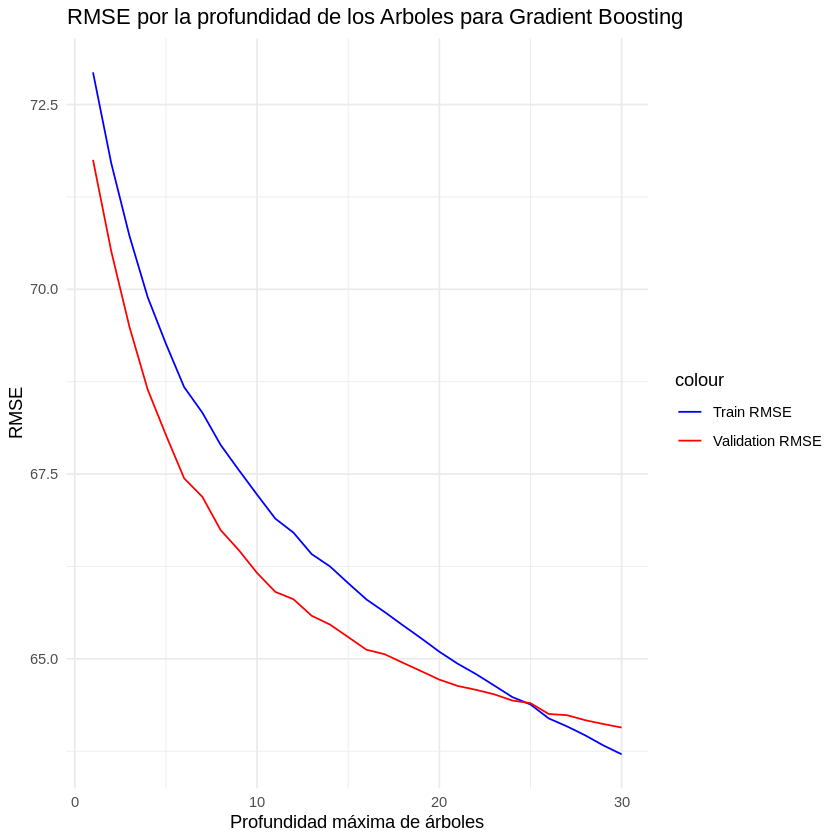

In [ ]:
ggplot(df_metricas, aes(x = max_depth)) +
    geom_line(aes(y = train_rmse, color = "Train RMSE")) +
    geom_line(aes(y = val_rmse, color = "Validation RMSE")) +
    labs(title = "RMSE por la profundidad de los Arboles para Gradient Boosting",
         x = "Profundidad máxima de árboles",
         y = "RMSE") +
    scale_color_manual(values = c("Train RMSE" = "blue", "Validation RMSE" = "red")) +
    theme_minimal()

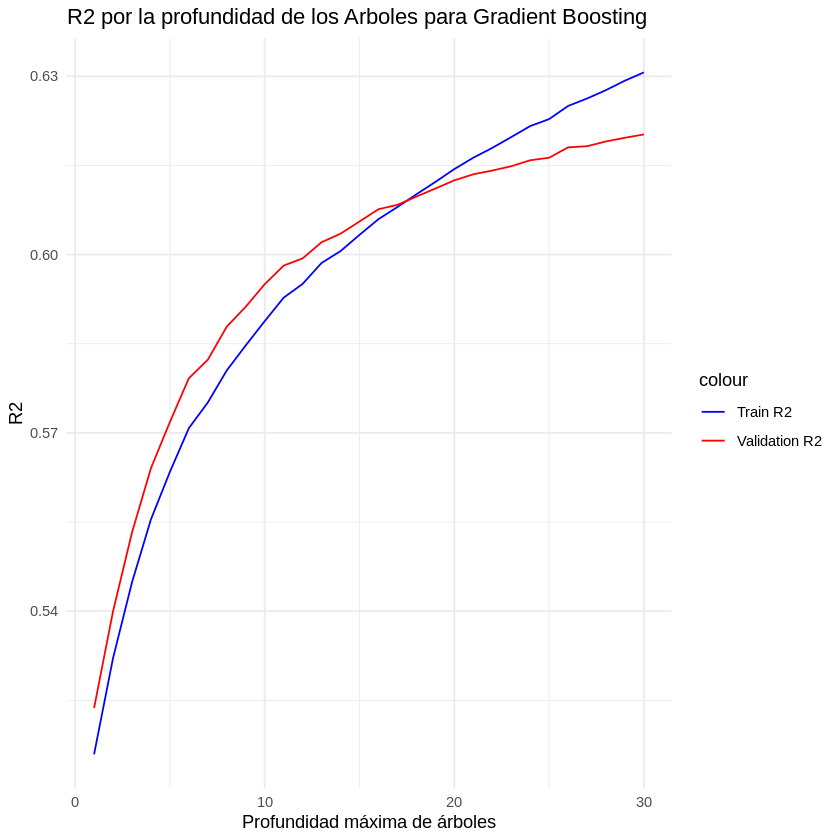

In [ ]:
ggplot(df_metricas, aes(x = max_depth)) +
    geom_line(aes(y = train_r2, color = "Train R2")) +
    geom_line(aes(y = val_r2, color = "Validation R2")) +
    labs(title = "R2 por la profundidad de los Arboles para Gradient Boosting",
         x = "Profundidad máxima de árboles",
         y = "R2") +
    scale_color_manual(values = c("Train R2" = "blue", "Validation R2" = "red")) +
    theme_minimal()

Entrenamos el modelo con valor optimo de max_depth = 20 para diferentes valores dl numero de árboles (n_estimators)


El numero árboles:  100 
Training time:  41.30429 


Using 100 trees...




Train RMSE:  76.42958 
Train MAE:  47.85458 
Train R-squared:  0.468421 



Using 100 trees...




Validation RMSE:  75.14547 
Validation MAE:  47.40165 
Validation R-squared:  0.477566 

El numero árboles:  200 
Training time:  1.386551 


Using 200 trees...




Train RMSE:  70.72656 
Train MAE:  41.37854 
Train R-squared:  0.5447919 



Using 200 trees...




Validation RMSE:  69.35696 
Validation MAE:  40.87413 
Validation R-squared:  0.554953 

El numero árboles:  300 
Training time:  2.057482 


Using 300 trees...




Train RMSE:  68.98817 
Train MAE:  39.56796 
Train R-squared:  0.566894 



Using 300 trees...




Validation RMSE:  67.69679 
Validation MAE:  39.08888 
Validation R-squared:  0.5760038 

El numero árboles:  400 
Training time:  2.822496 


Using 400 trees...




Train RMSE:  67.93951 
Train MAE:  38.68211 
Train R-squared:  0.5799609 



Using 400 trees...




Validation RMSE:  66.74826 
Validation MAE:  38.27433 
Validation R-squared:  0.5878021 

El numero árboles:  500 
Training time:  3.417485 


Using 500 trees...




Train RMSE:  67.15832 
Train MAE:  38.15214 
Train R-squared:  0.5895648 



Using 500 trees...




Validation RMSE:  66.08305 
Validation MAE:  37.79093 
Validation R-squared:  0.5959772 

El numero árboles:  600 
Training time:  4.101227 


Using 600 trees...




Train RMSE:  66.59139 
Train MAE:  37.78023 
Train R-squared:  0.5964652 



Using 600 trees...




Validation RMSE:  65.67461 
Validation MAE:  37.50158 
Validation R-squared:  0.600956 

El numero árboles:  700 
Training time:  4.788533 


Using 700 trees...




Train RMSE:  66.10794 
Train MAE:  37.52284 
Train R-squared:  0.6023032 



Using 700 trees...




Validation RMSE:  65.33072 
Validation MAE:  37.3084 
Validation R-squared:  0.605124 

El numero árboles:  800 
Training time:  5.41934 


Using 800 trees...




Train RMSE:  65.77293 
Train MAE:  37.32953 
Train R-squared:  0.6063237 



Using 800 trees...




Validation RMSE:  65.12948 
Validation MAE:  37.17396 
Validation R-squared:  0.6075529 

El numero árboles:  900 
Training time:  6.13174 


Using 900 trees...




Train RMSE:  65.41366 
Train MAE:  37.12989 
Train R-squared:  0.6106126 



Using 900 trees...




Validation RMSE:  64.93429 
Validation MAE:  37.05724 
Validation R-squared:  0.6099017 

El numero árboles:  1000 
Training time:  6.673694 


Using 1000 trees...




Train RMSE:  65.11023 
Train MAE:  36.96691 
Train R-squared:  0.6142167 



Using 1000 trees...




Validation RMSE:  64.74292 
Validation MAE:  36.93208 
Validation R-squared:  0.6121978 

El numero árboles:  1100 
Training time:  7.349514 


Using 1100 trees...




Train RMSE:  64.79276 
Train MAE:  36.80543 
Train R-squared:  0.6179696 



Using 1100 trees...




Validation RMSE:  64.5475 
Validation MAE:  36.83902 
Validation R-squared:  0.6145352 

El numero árboles:  1200 
Training time:  7.833956 


Using 1200 trees...




Train RMSE:  64.54734 
Train MAE:  36.6789 
Train R-squared:  0.6208582 



Using 1200 trees...




Validation RMSE:  64.44474 
Validation MAE:  36.77719 
Validation R-squared:  0.6157616 

El numero árboles:  1300 
Training time:  8.626962 


Using 1300 trees...




Train RMSE:  64.26221 
Train MAE:  36.54856 
Train R-squared:  0.6242005 



Using 1300 trees...




Validation RMSE:  64.29778 
Validation MAE:  36.68961 
Validation R-squared:  0.6175121 

El numero árboles:  1400 
Training time:  9.310609 


Using 1400 trees...




Train RMSE:  64.015 
Train MAE:  36.4281 
Train R-squared:  0.6270862 



Using 1400 trees...




Validation RMSE:  64.15406 
Validation MAE:  36.63288 
Validation R-squared:  0.6192201 

El numero árboles:  1500 
Training time:  9.929108 


Using 1500 trees...




Train RMSE:  63.77503 
Train MAE:  36.28346 
Train R-squared:  0.6298769 



Using 1500 trees...




Validation RMSE:  64.10472 
Validation MAE:  36.57189 
Validation R-squared:  0.6198055 

El numero árboles:  1600 
Training time:  10.70668 


Using 1600 trees...




Train RMSE:  63.55275 
Train MAE:  36.18151 
Train R-squared:  0.6324523 



Using 1600 trees...




Validation RMSE:  63.96978 
Validation MAE:  36.5058 
Validation R-squared:  0.6214044 

El numero árboles:  1700 
Training time:  11.18884 


Using 1700 trees...




Train RMSE:  63.35516 
Train MAE:  36.09596 
Train R-squared:  0.6347343 



Using 1700 trees...




Validation RMSE:  63.86366 
Validation MAE:  36.46494 
Validation R-squared:  0.6226595 

El numero árboles:  1800 
Training time:  11.88357 


Using 1800 trees...




Train RMSE:  63.11247 
Train MAE:  35.96665 
Train R-squared:  0.6375273 



Using 1800 trees...




Validation RMSE:  63.69556 
Validation MAE:  36.37356 
Validation R-squared:  0.6246433 

El numero árboles:  1900 
Training time:  12.66824 


Using 1900 trees...




Train RMSE:  62.94133 
Train MAE:  35.86386 
Train R-squared:  0.6394904 



Using 1900 trees...




Validation RMSE:  63.71047 
Validation MAE:  36.36379 
Validation R-squared:  0.6244676 

El numero árboles:  2000 
Training time:  13.28672 


Using 2000 trees...




Train RMSE:  62.70849 
Train MAE:  35.76006 
Train R-squared:  0.6421529 



Using 2000 trees...




Validation RMSE:  63.57675 
Validation MAE:  36.29776 
Validation R-squared:  0.6260424 


max_depth,train_rmse,train_mae,train_r2,val_rmse,val_mae,val_r2
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20,76.42958,47.85458,0.4684210,75.14547,47.40165,0.4775660
20,70.72656,41.37854,0.5447919,69.35696,40.87413,0.5549530
20,68.98817,39.56796,0.5668940,67.69679,39.08888,0.5760038
20,67.93951,38.68211,0.5799609,66.74826,38.27433,0.5878021
20,67.15832,38.15214,0.5895648,66.08305,37.79093,0.5959772
20,66.59139,37.78023,0.5964652,65.67461,37.50158,0.6009560
20,66.10794,37.52284,0.6023032,65.33072,37.30840,0.6051240
20,65.77293,37.32953,0.6063237,65.12948,37.17396,0.6075529
20,65.41366,37.12989,0.6106126,64.93429,37.05724,0.6099017


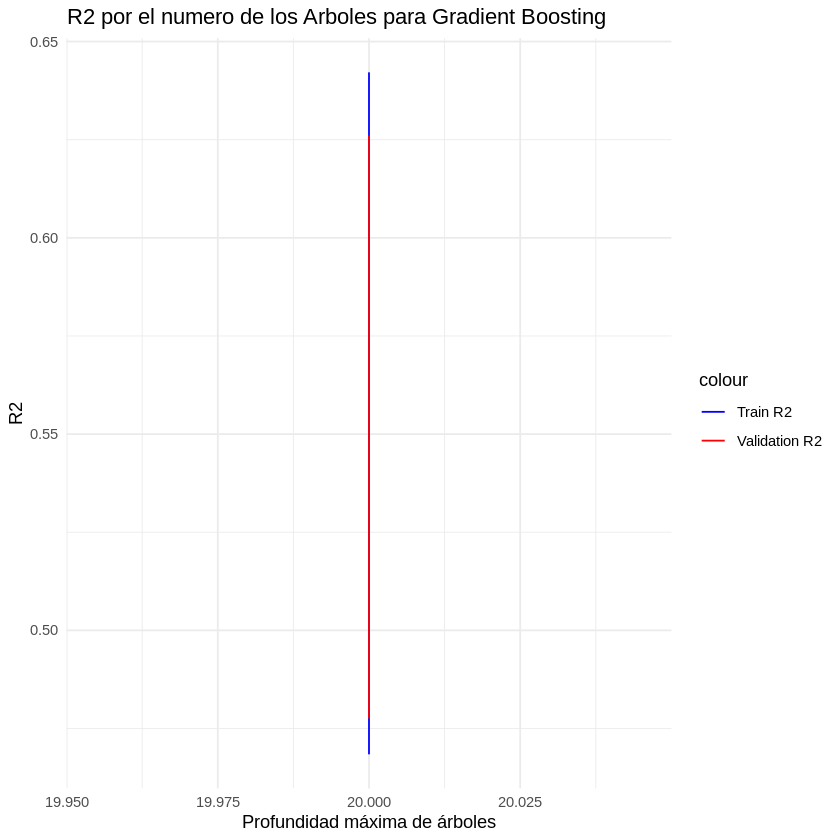

In [ ]:
learning_rate <-  0.01
max_depth <- 20

n_estimators_list <- c()
train_rmse_list <- c()
train_mae_list <- c()
train_r2_list <- c()
val_rmse_list <-c()
val_mae_list <- c()
val_r2_list <- c()
i <- 1

for (n_estimators in seq(100, 2000, by=100)) {
 cat("\nEl numero árboles: ", n_estimators, "\n")
 start_time <- Sys.time()
 model_gbm = gbm(formula=formula, data = train_data5,
                 distribution = "gaussian",
                # cv.folds = 10,
                 shrinkage = learning_rate,
                 n.trees = n_estimators,
                 interaction.depth = max_depth)
 end_time <- Sys.time()
 training_time8 <- end_time - start_time
 cat("Training time: ", training_time8, "\n")

 # Predecir con el conjunto de entrenamiento
 train_predictions <- predict(model_gbm, newdata = train_data5)

 # Calcular métricas de rendimiento para el conjunto de entrenamiento
 train_actuals <- train_data5$downtime_gross
 train_rmse <- sqrt(mean((train_predictions - train_actuals)^2))
 train_mae <- mean(abs(train_predictions - train_actuals))
 train_r2 <- 1 - (sum((train_predictions - train_actuals)^2) / sum((train_actuals - mean(train_actuals))^2))

 cat("Train RMSE: ", train_rmse, "\n")
 cat("Train MAE: ", train_mae, "\n")
 cat("Train R-squared: ", train_r2, "\n\n")

 # Predecir con el conjunto de validación
 validation_predictions <- predict(model_gbm, newdata = validation_data5)

 # Calcular métricas de rendimiento para el conjunto de validación
 validation_actuals <- validation_data5$downtime_gross
 validation_rmse <- sqrt(mean((validation_predictions - validation_actuals)^2))
 validation_mae <- mean(abs(validation_predictions - validation_actuals))
 validation_r2 <- 1 - (sum((validation_predictions - validation_actuals)^2) / sum((validation_actuals - mean(validation_actuals))^2))

 cat("Validation RMSE: ", validation_rmse, "\n")
 cat("Validation MAE: ", validation_mae, "\n")
 cat("Validation R-squared: ", validation_r2, "\n")

 n_estimators_list[i] <- n_estimators
 train_rmse_list[i] <- train_rmse
 train_mae_list[i] <- train_mae
 train_r2_list[i] <- train_r2
 val_rmse_list[i] <-validation_rmse
 val_mae_list[i] <- validation_mae
 val_r2_list[i] <- validation_r2
 i <- i + 1

}

df_metricas <- data.frame(n_estimators_list, train_rmse_list, train_mae_list, train_r2_list, val_rmse_list,val_mae_list, val_r2_list)
colnames(df_metricas) <- c("n_estimators", "train_rmse", "train_mae", "train_r2", "val_rmse", "val_mae", "val_r2")
df_metricas



In [ ]:
df_metricas

n_estimators,train_rmse,train_mae,train_r2,val_rmse,val_mae,val_r2
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100,76.42958,47.85458,0.4684210,75.14547,47.40165,0.4775660
200,70.72656,41.37854,0.5447919,69.35696,40.87413,0.5549530
300,68.98817,39.56796,0.5668940,67.69679,39.08888,0.5760038
400,67.93951,38.68211,0.5799609,66.74826,38.27433,0.5878021
500,67.15832,38.15214,0.5895648,66.08305,37.79093,0.5959772
600,66.59139,37.78023,0.5964652,65.67461,37.50158,0.6009560
700,66.10794,37.52284,0.6023032,65.33072,37.30840,0.6051240
800,65.77293,37.32953,0.6063237,65.12948,37.17396,0.6075529
900,65.41366,37.12989,0.6106126,64.93429,37.05724,0.6099017


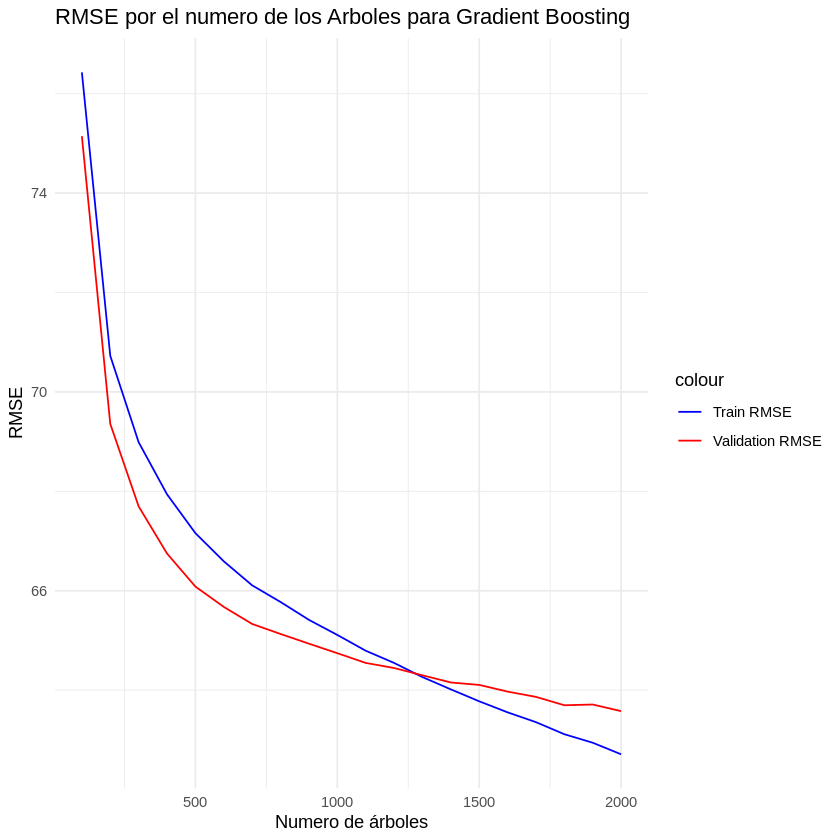

In [ ]:
ggplot(df_metricas, aes(x = n_estimators)) +
    geom_line(aes(y = train_rmse, color = "Train RMSE")) +
    geom_line(aes(y = val_rmse, color = "Validation RMSE")) +
    labs(title = "RMSE por el numero de los Arboles para Gradient Boosting",
         x = "Numero de árboles",
         y = "RMSE") +
    scale_color_manual(values = c("Train RMSE" = "blue", "Validation RMSE" = "red")) +
    theme_minimal()

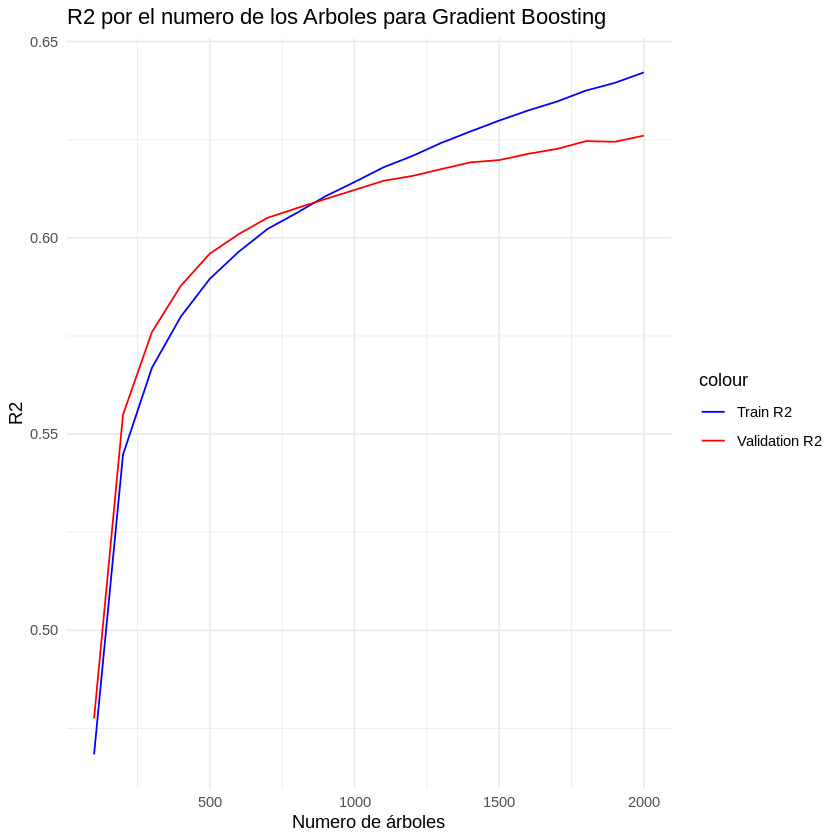

In [ ]:
ggplot(df_metricas, aes(x = n_estimators)) +
    geom_line(aes(y = train_r2, color = "Train R2")) +
    geom_line(aes(y = val_r2, color = "Validation R2")) +
    labs(title = "R2 por el numero de los Arboles para Gradient Boosting",
         x = "Numero de árboles",
         y = "R2") +
    scale_color_manual(values = c("Train R2" = "blue", "Validation R2" = "red")) +
    theme_minimal()

In [ ]:
df_metricas[df_metricas$n_estimators==1300,]

,n_estimators,train_rmse,train_mae,train_r2,val_rmse,val_mae,val_r2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
13,1300,64.26221,36.54856,0.6242005,64.29778,36.68961,0.6175121


Entrenamos el modelo optimal con max_depth = 20 y n_estimators = 1000

In [ ]:
learning_rate <-  0.01
max_depth <- 20
n_estimators <- 1000

start_time <- Sys.time()
model_gbm = gbm(formula=formula, data = train_data5,
                 distribution = "gaussian",
                 cv.folds = 10,
                 shrinkage = learning_rate,
                 n.trees = n_estimators,
                 interaction.depth = max_depth)
end_time <- Sys.time()
training_time8 <- end_time - start_time
cat("Training time: ", training_time8, "\n")

# Predecir con el conjunto de entrenamiento
train_predictions <- predict(model_gbm, newdata = train_data5)

# Calcular métricas de rendimiento para el conjunto de entrenamiento
train_actuals <- train_data5$downtime_gross
train_rmse <- sqrt(mean((train_predictions - train_actuals)^2))
train_mae <- mean(abs(train_predictions - train_actuals))
train_r2 <- 1 - (sum((train_predictions - train_actuals)^2) / sum((train_actuals - mean(train_actuals))^2))

cat("Train RMSE: ", train_rmse, "\n")
cat("Train MAE: ", train_mae, "\n")
cat("Train R-squared: ", train_r2, "\n\n")

# Predecir con el conjunto de validación
test_predictions <- predict(model_gbm, newdata = test_data5)

# Calcular métricas de rendimiento para el conjunto de validación
test_actuals <- test_data5$downtime_gross
test_rmse <- sqrt(mean((test_predictions - test_actuals)^2))
test_mae <- mean(abs(test_predictions - test_actuals))
test_r2 <- 1 - (sum((test_predictions - test_actuals)^2) / sum((test_actuals - mean(test_actuals))^2))

cat("Test RMSE: ", test_rmse, "\n")
cat("Test MAE: ", test_mae, "\n")
cat("Test R-squared: ", test_r2, "\n")

Training time:  55.47118 


Using 1000 trees...




Train RMSE:  65.07887 
Train MAE:  36.95624 
Train R-squared:  0.6145882 



Using 1000 trees...




Test RMSE:  65.25275 
Test MAE:  37.07412 
Test R-squared:  0.6043307 


# **MODELO RED NEURAL**

In [ ]:
install.packages("tensorflow")
library(tensorflow)
install.packages("keras3")
library(keras3)
install.packages("tidyverse")
library(tidyverse)
install.packages("tidymodels")
library(tidymodels)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RcppTOML’, ‘here’, ‘png’, ‘config’, ‘reticulate’, ‘tfruns’, ‘tfautograph’



Attaching package: ‘tensorflow’


The following object is masked from ‘package:caret’:

    train


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘zeallot’



Attaching package: ‘keras3’


The following objects are masked from ‘package:tensorflow’:

    set_random_seed, shape


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats 1.0.0     ✔ tibble  3.2.1
✔ purrr   1.0.2     ✔ tidyr   1.3.1
✔ stringr 1.5.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ scales::col_factor()    masks readr::col_factor()
✖ randomForest::combine() masks dplyr::combine()
✖ purrr::discard()  

In [ ]:
dim(train_data4)
dim(validation_data4)
dim(test_data4)

[1] 104343     17

[1] 29812    17

[1] 14907    17

In [ ]:
formula

downtime_gross ~ changed_pcs + mechanic + operation + cause_desc + 
    problem_desc + Age + base_model + action_desc + failure_desc + 
    Days_Between_Failures + Cumulative_Maintenance_Cost + parts_cost

**Creamos el conjunto de datos del entrenamiento y de la evaluación**

In [ ]:
encoder1 <- LabelEncoder$new()
encoder2 <- LabelEncoder$new()
encoder3 <- LabelEncoder$new()
encoder4 <- LabelEncoder$new()
encoder5 <- LabelEncoder$new()
encoder6 <- LabelEncoder$new()
encoder7 <- LabelEncoder$new()

data_for_rn <- rbind(rbind(train_data4, validation_data4), test_data4)

data_for_rn$operation <- encoder1$fit_transform(data_for_rn$operation)
data_for_rn$base_model <- encoder2$fit_transform(data_for_rn$base_model)
data_for_rn$problem_desc <- encoder3$fit_transform(data_for_rn$problem_desc)
data_for_rn$failure_desc <- encoder4$fit_transform(data_for_rn$failure_desc)
data_for_rn$cause_desc <- encoder5$fit_transform(data_for_rn$cause_desc)
data_for_rn$action_desc <- encoder6$fit_transform(data_for_rn$action_desc)
data_for_rn$mechanic <- encoder7$fit_transform(data_for_rn$mechanic)

data_for_rn <- data_for_rn[, c("changed_pcs", "mechanic", "operation", "cause_desc",
                               "problem_desc", "Age", "base_model", "action_desc", "failure_desc",
                               "Days_Between_Failures", "Cumulative_Maintenance_Cost", "parts_cost",
                               "downtime_gross")]
head(data_for_rn, 6)


changed_pcs,mechanic,operation,cause_desc,problem_desc,Age,base_model,action_desc,failure_desc,Days_Between_Failures,Cumulative_Maintenance_Cost,parts_cost,downtime_gross
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,21,0,0,0,65,52.44,0.0,70
1,1,1,0,0,6,1,0,0,401,0.00,0.0,30
1,2,2,0,0,19,2,0,0,22,2407.95,0.0,75
0,3,3,1,0,20,3,1,1,7,1489.20,25.0,15
0,4,1,2,0,13,1,2,0,130,38.70,38.7,15
1,5,1,3,0,25,4,3,2,0,185.48,1.0,280


In [ ]:
summary(data_for_rn)

  changed_pcs        mechanic      operation       cause_desc   
 Min.   : 0.000   Min.   : 0.0   Min.   : 0.00   Min.   :  0.0  
 1st Qu.: 0.000   1st Qu.: 7.0   1st Qu.: 3.00   1st Qu.:  2.0  
 Median : 1.000   Median :29.0   Median : 7.00   Median :  9.0  
 Mean   : 1.011   Mean   :34.6   Mean   :12.71   Mean   : 26.7  
 3rd Qu.: 1.000   3rd Qu.:57.0   3rd Qu.:20.00   3rd Qu.: 34.0  
 Max.   :14.000   Max.   :91.0   Max.   :58.00   Max.   :279.0  
                                                                
  problem_desc         Age          base_model      action_desc    
 Min.   :0.0000   Min.   : 3.00   Min.   :  0.00   Min.   :  0.00  
 1st Qu.:0.0000   1st Qu.:18.00   1st Qu.:  8.00   1st Qu.:  2.00  
 Median :0.0000   Median :21.00   Median : 12.00   Median : 12.00  
 Mean   :0.3911   Mean   :19.88   Mean   : 18.71   Mean   : 26.96  
 3rd Qu.:1.0000   3rd Qu.:25.00   3rd Qu.: 23.00   3rd Qu.: 33.00  
 Max.   :2.0000   Max.   :27.00   Max.   :122.00   Max.   :278.00  
    

In [ ]:
# Cambiamos los valores NA de la variable Age por la mediana
mediana_Age <- median(data_for_rn$Age, na.rm = TRUE)
data_for_rn$Age[is.na(data_for_rn$Age)] <- mediana_Age
summary(data_for_rn$Age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   3.00   18.00   21.00   19.89   24.00   27.00 

In [ ]:
# Crear conjuntos de entrenamiento y de prueba para el modelo Red Neural

train_data6 <- data_for_rn[1:(nrow(train_data4) + nrow(validation_data4)),]
test_data6 <- data_for_rn[(nrow(train_data4) + nrow(validation_data4)+1):(nrow(train_data4) + nrow(validation_data4)+nrow(test_data4)),]

dim(train_data6)
dim(test_data6)

[1] 134155     13

[1] 14907    13

In [ ]:
# Dividimos datasets por características y etiquetas para entrenar luego el modelo

X_train <- as.matrix(select(train_data6, -downtime_gross))
Y_train <- as.matrix(select(train_data6, downtime_gross))

X_test <- as.matrix(select(test_data6, -downtime_gross))
Y_test <- as.matrix(select(test_data6, downtime_gross))

print("Dimenciones del conjunto de datos de entrenamiento: ")
dim(X_train)
dim(Y_train)

print("Dimenciones del conjunto de datos de prueba: ")
dim(X_test)
dim(Y_test)

[1] "Dimenciones del conjunto de datos de entrenamiento: "


[1] 134155     12

[1] 134155      1

[1] "Dimenciones del conjunto de datos de prueba: "


[1] 14907    12

[1] 14907     1

**Creamos el modelo optimo**

In [ ]:
normalizer <- layer_normalization(axis = -1L)
normalizer %>% adapt(X_train)

In [ ]:
print(normalizer$mean)

tf.Tensor(
[[1.0114121e+00 3.4606880e+01 1.2722410e+01 2.6707077e+01 3.9104766e-01
  1.9879826e+01 1.8692856e+01 2.6959808e+01 1.2004547e+00 1.9760456e+01
  4.6934875e+02 1.3403198e+01]], shape=(1, 12), dtype=float32)


In [ ]:
model_rn_optimo <- keras_model_sequential(shape=c(12)) %>%
    normalizer() %>%
    layer_dense(64, activation = 'relu') %>%
    layer_dense(64, activation = 'relu') %>%
    layer_dense(1)

model_rn_optimo %>% compile(
    loss = 'mean_squared_error',
    optimizer = optimizer_adam(0.01),
    metrics = "r2_score")

summary(model_rn_optimo)

Model: "sequential_2"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape           ┃     Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━┩
│ normalization (Normalization) │ (None, 12)             │          25 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_6 (Dense)               │ (None, 64)             │         832 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_7 (Dense)               │ (None, 64)             │       4,160 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_8 (Dense)               │ (None, 1)              │          65 │   Y   │
└───────────────────────────────┴────────────────────────┴─────────────┴───────┘
 Total params: 5,082 (19.86 KB)
 Trainable params: 5,057 (19.75 KB)
 Non-trainable para

In [ ]:
history <- model_rn_optimo %>% fit(
  x = X_train,
  y = Y_train,
  validation_split = 0.2,
  verbose = 2,
  epochs = 80)

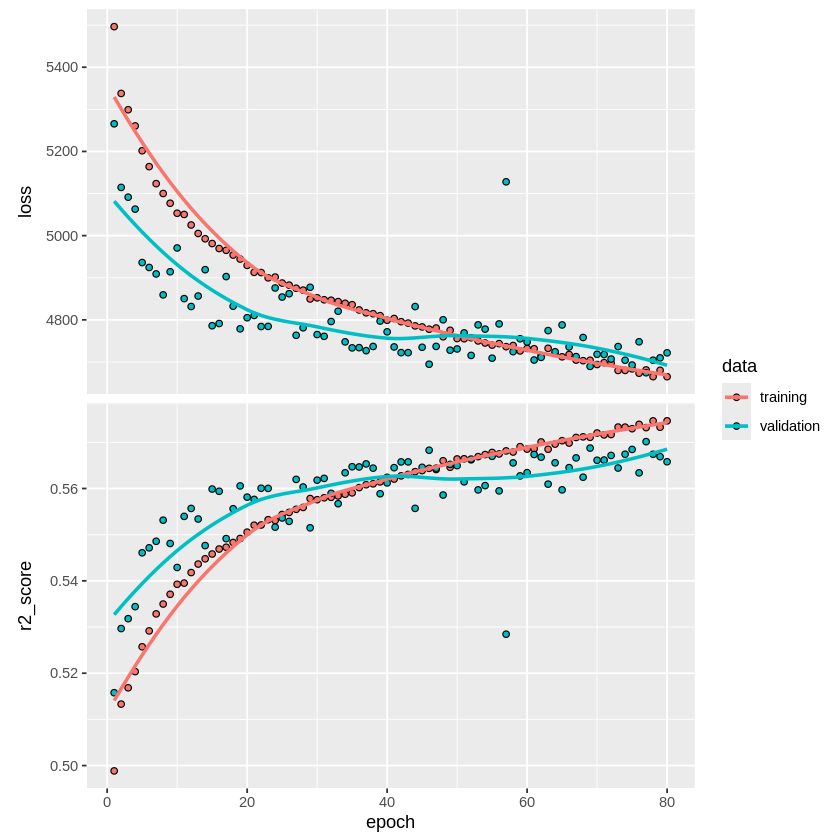

In [ ]:
plot(history)

In [ ]:
history


Final epoch (plot to see history):
        loss: 4,665
    r2_score: 0.5747
    val_loss: 4,722
val_r2_score: 0.5658 

In [ ]:
# Predecir con el conjunto de entrenamiento
train_predictions <- predict(model_rn_optimo, X_train)

# Calcular métricas de rendimiento para el conjunto de entrenamiento
train_actuals <- Y_train #train_data6$downtime_gross
train_rmse <- sqrt(mean((train_predictions - train_actuals)^2))
train_mae <- mean(abs(train_predictions - train_actuals))
train_r2 <- 1 - (sum((train_predictions - train_actuals)^2) / sum((train_actuals - mean(train_actuals))^2))

cat("Train RMSE: ", train_rmse, "\n")
cat("Train MAE: ", train_mae, "\n")
cat("Train R-squared: ", train_r2, "\n\n")

# Predecir con el conjunto de validación
test_predictions <- predict(model_rn_optimo, X_test)

# Calcular métricas de rendimiento para el conjunto de validación
test_actuals <- Y_test #test_data6$downtime_gross
test_rmse <- sqrt(mean((test_predictions - test_actuals)^2))
test_mae <- mean(abs(test_predictions - test_actuals))
test_r2 <- 1 - (sum((test_predictions - test_actuals)^2) / sum((test_actuals - mean(test_actuals))^2))

cat("Test RMSE: ", test_rmse, "\n")
cat("Test MAE: ", test_mae, "\n")
cat("Test R-squared: ", test_r2, "\n")

Train RMSE:  68.1262 
Train MAE:  40.36343 
Train R-squared:  0.5761048 

Test RMSE:  68.86171 
Test MAE:  40.79231 
Test R-squared:  0.5593535 


**Pruebas de los modelos**

In [ ]:
model_rn <- keras_model_sequential(shape=c(12)) %>%
    normalizer() %>%
    layer_dense(64, activation = 'relu') %>%
    layer_dense(64, activation = 'relu') %>%
    layer_dense(1)

model_rn %>% compile(
    loss = 'mean_squared_error',
    optimizer = optimizer_adam(0.01),
    metrics = "r2_score")

summary(model_rn)

Model: "sequential_75"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape           ┃     Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━┩
│ normalization_21              │ (None, 12)             │          25 │   Y   │
│ (Normalization)               │                        │             │       │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_207 (Dense)             │ (None, 64)             │         832 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_208 (Dense)             │ (None, 64)             │       4,160 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_209 (Dense)             │ (None, 1)              │          65 │   Y   │
└───────────────────────────────┴────────────────────────┴─────────────┴───────┘
 Tota

In [ ]:
history <- model_rn %>% fit(
  x = X_train,
  y = Y_train,
  validation_split = 0.2,
  verbose = 2,
  epochs = 100)

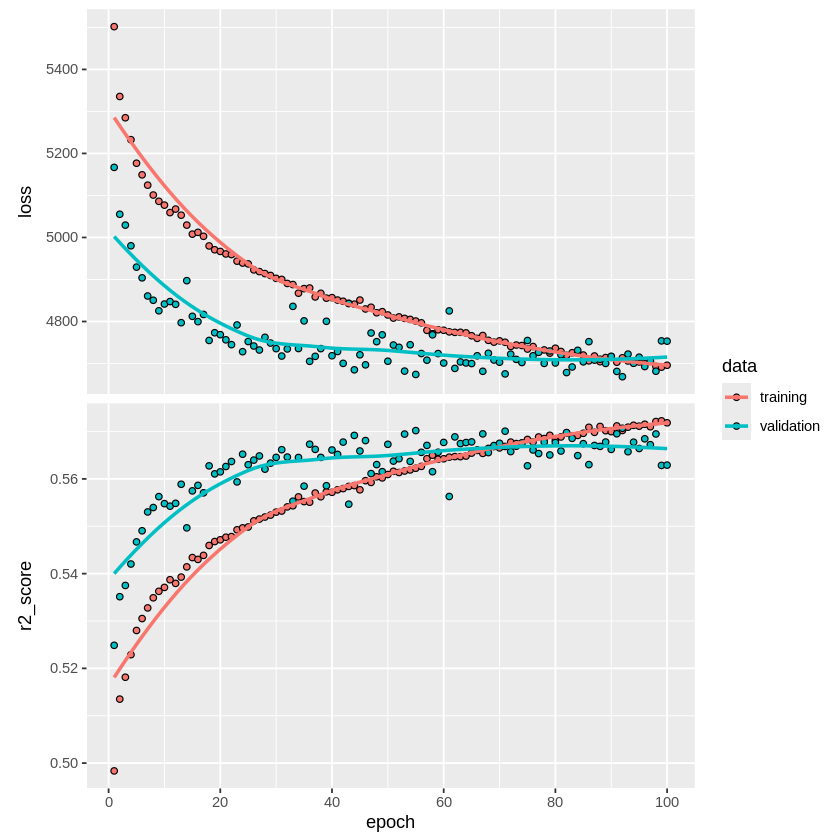

In [ ]:
plot(history)

In [ ]:
history


Final epoch (plot to see history):
        loss: 5,470
    r2_score: 0.5012
    val_loss: 5,248
val_r2_score: 0.5174 

In [ ]:
model_rn2 <- keras_model_sequential(shape=c(12)) %>%
    normalizer() %>%
    layer_dense(1)

model_rn2 %>% compile(
    loss = 'mean_squared_error',
    optimizer = optimizer_adam(0.01),
    metrics = "r2_score")

summary(model_rn2)

Model: "sequential_76"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape           ┃     Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━┩
│ normalization_21              │ (None, 12)             │          25 │   Y   │
│ (Normalization)               │                        │             │       │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_210 (Dense)             │ (None, 1)              │          13 │   Y   │
└───────────────────────────────┴────────────────────────┴─────────────┴───────┘
 Total params: 38 (156.00 B)
 Trainable params: 13 (52.00 B)
 Non-trainable params: 25 (104.00 B)


In [ ]:
history2 <- model_rn2 %>% fit(
  x = X_train,
  y = Y_train,
  validation_split = 0.2,
  verbose = 2,
  epochs = 100)

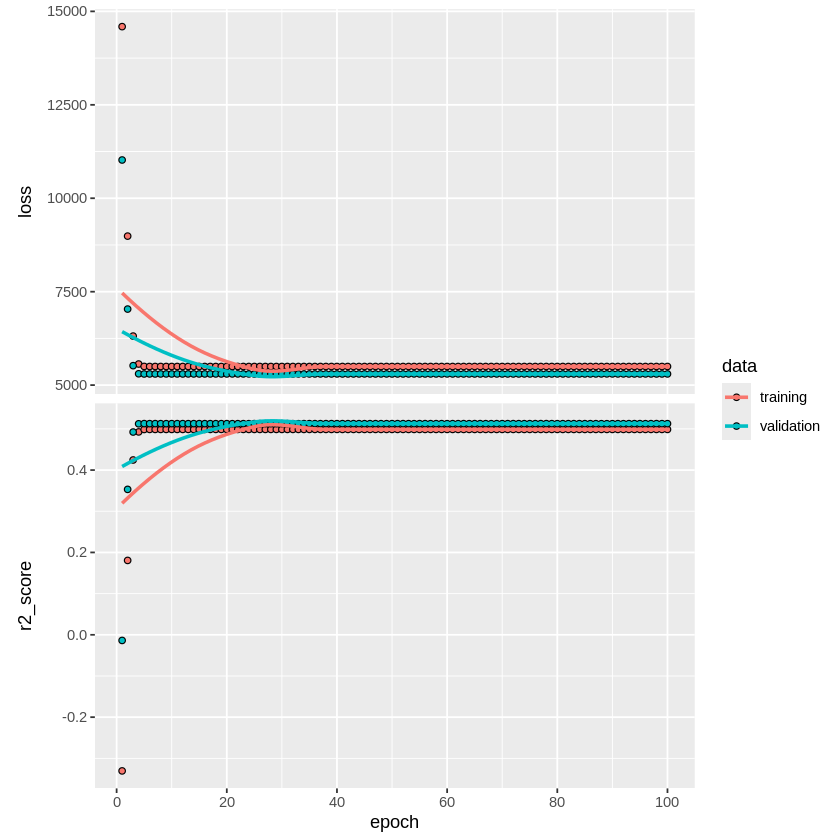

In [ ]:
plot(history2)

In [ ]:
model_rn3 <- keras_model_sequential(shape=c(12)) %>%
    normalizer() %>%
    layer_dense(64, activation = 'relu') %>%
    layer_dense(64, activation = 'relu') %>%
    layer_dense(1)

model_rn3 %>% compile(
    loss = 'mean_absolute_error',
    optimizer = optimizer_adam(0.001),
    metrics = "r2_score")

summary(model_rn3)

Model: "sequential_77"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape           ┃     Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━┩
│ normalization_21              │ (None, 12)             │          25 │   Y   │
│ (Normalization)               │                        │             │       │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_211 (Dense)             │ (None, 64)             │         832 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_212 (Dense)             │ (None, 64)             │       4,160 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_213 (Dense)             │ (None, 1)              │          65 │   Y   │
└───────────────────────────────┴────────────────────────┴─────────────┴───────┘
 Tota

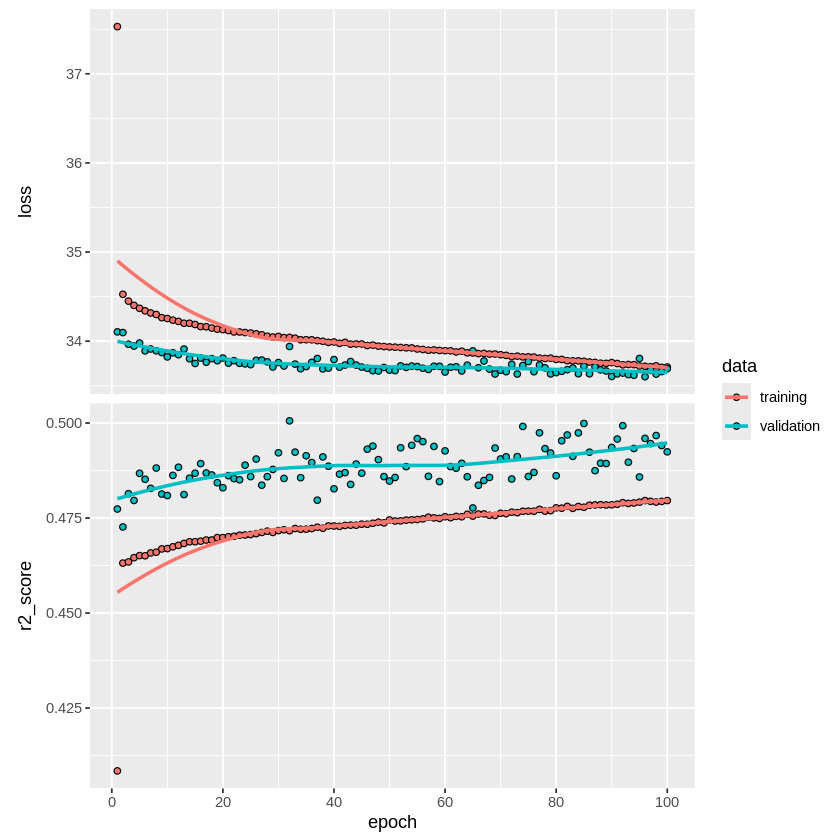

In [ ]:
history3 <- model_rn3 %>% fit(
  x = X_train,
  y = Y_train,
  validation_split = 0.2,
  verbose = 2,
  epochs = 100)

plot(history3)

In [ ]:
model_rn4 <- keras_model_sequential(shape=c(12)) %>%
    normalizer() %>%
    layer_dense(1)

model_rn4 %>% compile(
    loss = 'mean_absolute_error',
    optimizer = optimizer_adam(0.001),
    metrics = "r2_score")

summary(model_rn4)

Model: "sequential_78"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape           ┃     Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━┩
│ normalization_21              │ (None, 12)             │          25 │   Y   │
│ (Normalization)               │                        │             │       │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_214 (Dense)             │ (None, 1)              │          13 │   Y   │
└───────────────────────────────┴────────────────────────┴─────────────┴───────┘
 Total params: 38 (156.00 B)
 Trainable params: 13 (52.00 B)
 Non-trainable params: 25 (104.00 B)


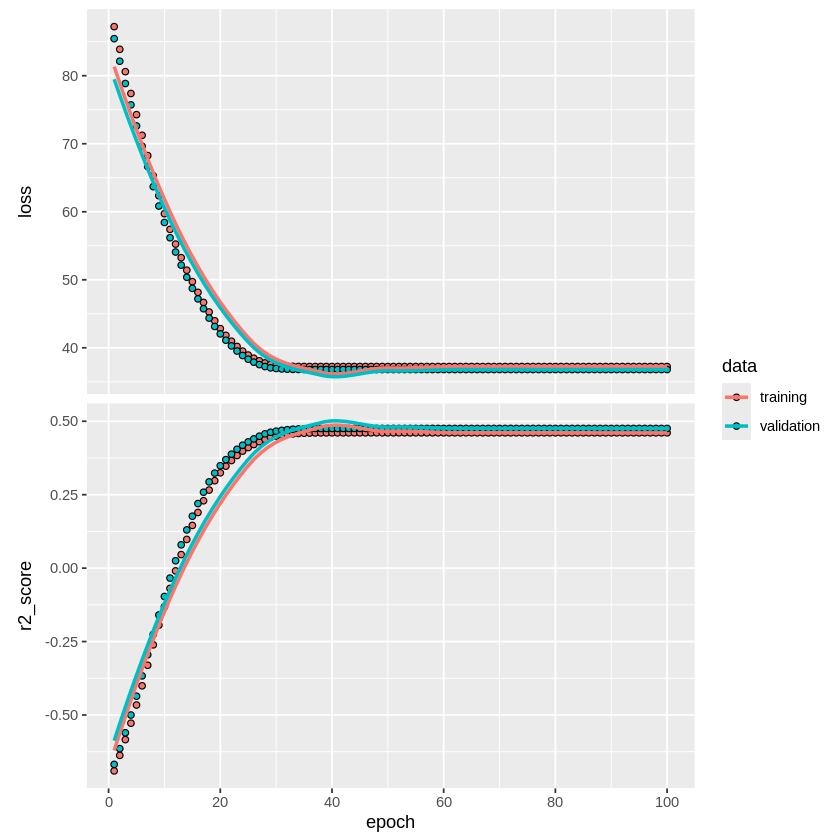

In [ ]:
history4 <- model_rn4 %>% fit(
  x = X_train,
  y = Y_train,
  validation_split = 0.2,
  verbose = 2,
  epochs = 100)

plot(history4)

In [ ]:
model_rn5 <- keras_model_sequential(shape=c(12)) %>%
    normalizer() %>%
    layer_dense(64, activation = 'relu') %>%
    layer_dense(64, activation = 'relu') %>%
    layer_dense(1)

model_rn5 %>% compile(
    loss = 'mean_squared_error',
    optimizer = optimizer_adam(0.001),
    metrics = "r2_score")

summary(model_rn5)

Model: "sequential_79"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape           ┃     Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━┩
│ normalization_21              │ (None, 12)             │          25 │   Y   │
│ (Normalization)               │                        │             │       │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_215 (Dense)             │ (None, 64)             │         832 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_216 (Dense)             │ (None, 64)             │       4,160 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_217 (Dense)             │ (None, 1)              │          65 │   Y   │
└───────────────────────────────┴────────────────────────┴─────────────┴───────┘
 Tota

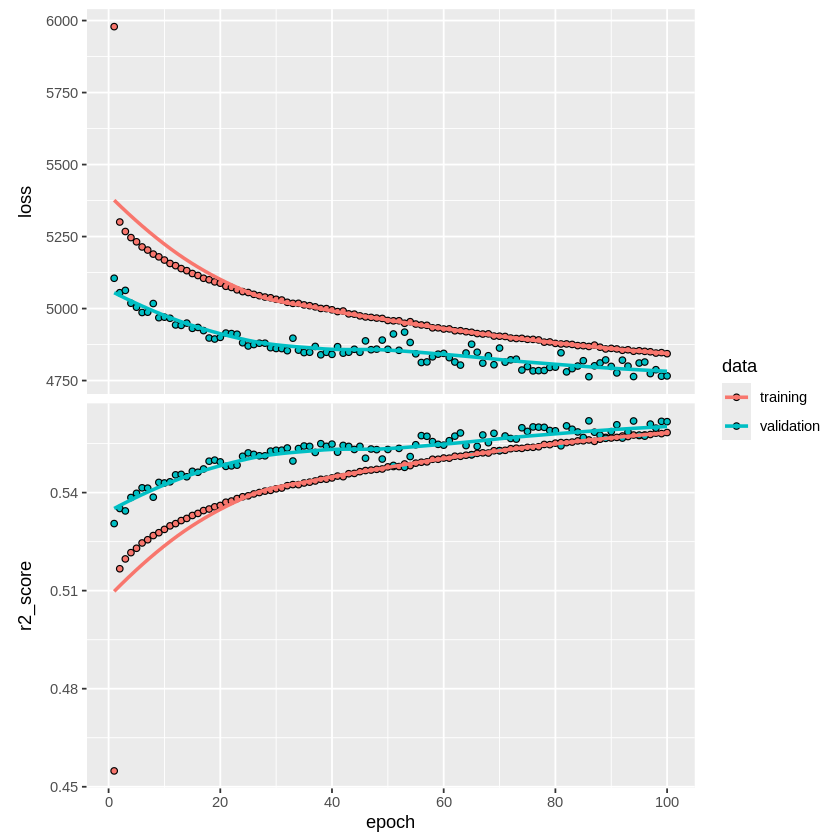

In [ ]:
history5 <- model_rn5 %>% fit(
  x = X_train,
  y = Y_train,
  validation_split = 0.2,
  verbose = 2,
  epochs = 100)

  plot(history5)

In [ ]:
model_rn6 <- keras_model_sequential(shape=c(12)) %>%
    normalizer() %>%
    layer_dense(64, activation = 'relu') %>%
    layer_dense(64, activation = 'relu') %>%
    layer_dense(64, activation = 'relu') %>%
    layer_dense(1)

model_rn6 %>% compile(
    loss = 'mean_squared_error',
    optimizer = optimizer_adam(0.001),
    metrics = "r2_score")

summary(model_rn6)

Model: "sequential"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape           ┃     Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━┩
│ normalization (Normalization) │ (None, 12)             │          25 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense (Dense)                 │ (None, 64)             │         832 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_1 (Dense)               │ (None, 64)             │       4,160 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_2 (Dense)               │ (None, 64)             │       4,160 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_3 (Dense)               │ (None, 1)              │          65 │   Y   │
└───────

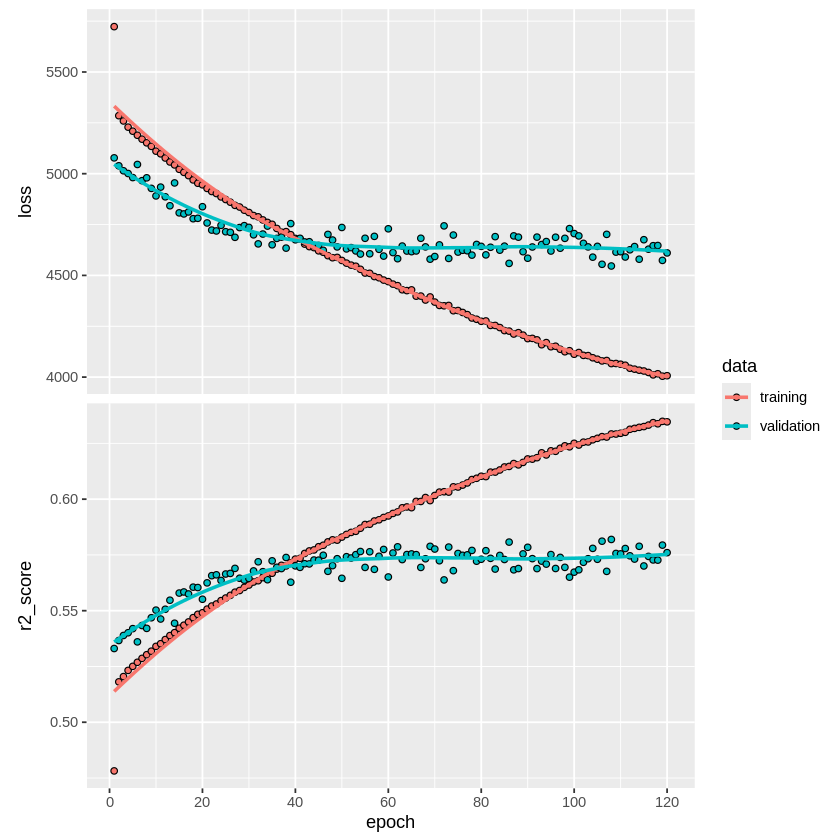

In [ ]:
history6 <- model_rn6 %>% fit(
  x = X_train,
  y = Y_train,
  validation_split = 0.2,
  verbose = 2,
  epochs = 120)

  plot(history6)

In [ ]:
model_rn7 <- keras_model_sequential(shape=c(12)) %>%
    normalizer() %>%
    layer_dense(64, activation = 'relu') %>%
    layer_dense(64, activation = 'relu') %>%
    layer_dense(64, activation = 'relu') %>%
    layer_dense(1)

model_rn7 %>% compile(
    loss = 'mean_squared_error',
    optimizer = optimizer_adam(0.01),
    metrics = "r2_score")

summary(model_rn7)

Model: "sequential_2"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape           ┃     Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━┩
│ normalization (Normalization) │ (None, 12)             │          25 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_8 (Dense)               │ (None, 64)             │         832 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_9 (Dense)               │ (None, 64)             │       4,160 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_10 (Dense)              │ (None, 64)             │       4,160 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_11 (Dense)              │ (None, 1)              │          65 │   Y   │
└─────

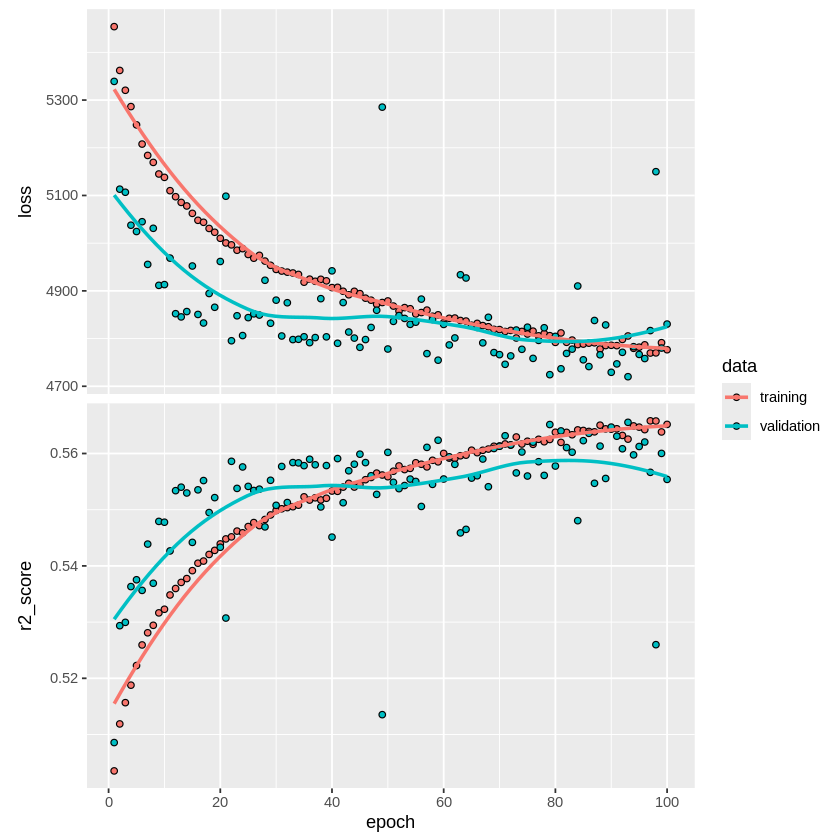

In [ ]:
history7 <- model_rn7 %>% fit(
  x = X_train,
  y = Y_train,
  validation_split = 0.3,
  verbose = 2,
  epochs = 100)

  plot(history7)

In [ ]:
model_rn8 <- keras_model_sequential(shape=c(12)) %>%
    normalizer() %>%
    layer_dense(64, activation = 'relu') %>%
    layer_dense(128, activation = 'relu') %>%
    layer_dropout(0.2) %>%
    layer_dense(64, activation = 'relu') %>%
    layer_dense(1)

model_rn8 %>% compile(
    loss = 'mean_squared_error',
    optimizer = optimizer_adam(0.001),
    metrics = "r2_score")

summary(model_rn8)

Model: "sequential_9"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape           ┃     Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━┩
│ normalization (Normalization) │ (None, 12)             │          25 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_34 (Dense)              │ (None, 64)             │         832 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_35 (Dense)              │ (None, 128)            │       8,320 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dropout_6 (Dropout)           │ (None, 128)            │           0 │   -   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_36 (Dense)              │ (None, 64)             │       8,256 │   Y   │
├─────

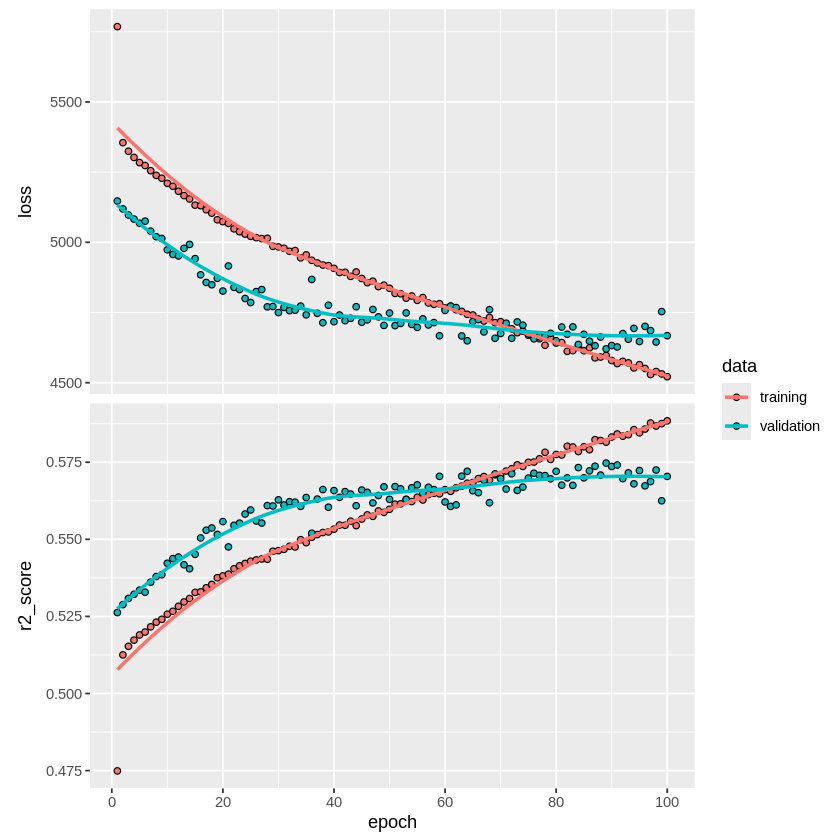

In [ ]:
history8 <- model_rn8 %>% fit(
  x = X_train,
  y = Y_train,
  validation_split = 0.3,
  verbose = 2,
  epochs = 100)

  plot(history8)